<a href="https://colab.research.google.com/github/Mbaiornom/Essai/blob/main/Fernand_stage_SNCF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importation des bibliothèques necessaires

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
!pip install pandas matplotlib seaborn
import seaborn as sns
from tabulate import tabulate
from matplotlib.patches import Patch
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
!pip install pandas matplotlib prince
import prince

Connection au drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


Importation de la base des données

In [ ]:
base_2023 = pd.read_csv('/content/drive/MyDrive/Stage_SNCF/Baro_SNCF_2023_Data_2023.csv',sep=';')

Base_2023 = pd.DataFrame(base_2023)

print(base_2023.shape)
#print(Base_2023)

(99123, 393)


Vue globale de la base

In [ ]:
#Base_2023.describe(include="all")

### verification du fait que chaque employé est rattaché à au moins un etablissement

In [ ]:
etablissement_columns = [col for col in Base_2023.columns if col.startswith('ETABLISSEMENT_')]

Base_2023['Nombre_etablissement']=Base_2023[etablissement_columns].sum(axis=1)

individu_pas_etbl=Base_2023[Base_2023['Nombre_etablissement']==0]

individu_pas_etbl=pd.DataFrame(individu_pas_etbl)

print(individu_pas_etbl.shape)
print(individu_pas_etbl)

(1324, 394)
       ID BDD  ANNEE  SEXE  CLASSE  L1   L2    L3  Q1  Q2  Q3  ...  \
40         41   2023     1       4   1  5.0  32.0   3   2   3  ...   
687       688   2023     1       3   1  5.0  32.0   1   1   2  ...   
831       832   2023     1       7   1  5.0  28.0   4   2   2  ...   
1016     1017   2023     2       2   1  5.0  32.0   4   4   4  ...   
1165     1166   2023     1       4   1  5.0  32.0   3   2   2  ...   
...       ...    ...   ...     ...  ..  ...   ...  ..  ..  ..  ...   
98177   98178   2023     2       7   1  4.0  31.0   5   4   4  ...   
98199   98200   2023     2       9   1  4.0  31.0   1   2   2  ...   
98233   98234   2023     1       8   1  5.0  28.0   4   2   1  ...   
98241   98242   2023     1       1   1  5.0  18.0   2   2   2  ...   
99089   99090   2023     2       4   1  4.0   NaN   2   2   2  ...   

       ETABLISSEMENT_395  ETABLISSEMENT_396  ETABLISSEMENT_397  \
40                     0                  0                  0   
687            

Transformation de la base: création de la variable etablissement

### Premiere approche

In [ ]:
# Sélectionner les colonnes d'établissements
etablissement_columns = [col for col in Base_2023.columns if col.startswith('ETABLISSEMENT_')]

# Créer une nouvelle colonne "ETABLISSEMENT" en trouvant le dernier établissement auquel l'individu appartient
Base_2023['ETABLISSEMENT'] = Base_2023[etablissement_columns].apply(lambda row: row[::-1].idxmax() if row.any() else np.nan, axis=1)

# Extraire le numéro de l'établissement
Base_2023['ETABLISSEMENT'] = Base_2023['ETABLISSEMENT'].apply(lambda x: int(x.split('_')[1]) if not pd.isnull(x) else np.nan)

# Compter le nombre de valeurs NaN dans la colonne 'ETABLISSEMENT'
nombre_Na_etabl = Base_2023['ETABLISSEMENT'].isna().sum()

# Afficher le DataFrame avec la nouvelle colonne "ETABLISSEMENT"
print("/nDataFrame avec la colonne 'ETABLISSEMENT':")
print(Base_2023)

# Afficher le nombre de valeurs NaN dans la colonne 'ETABLISSEMENT'
print(nombre_Na_etabl)


/nDataFrame avec la colonne 'ETABLISSEMENT':
       ID BDD  ANNEE  SEXE  CLASSE  L1   L2    L3  Q1  Q2  Q3  ...  \
0           1   2023     1       4   1  5.0  32.0   4   3   3  ...   
1           2   2023     1       2   1  5.0  34.0   1   1   1  ...   
2           3   2023     1       4   1  5.0  32.0   3   2   3  ...   
3           4   2023     1       5   1  5.0  34.0   3   2   2  ...   
4           5   2023     1       2   1  5.0  32.0   1   1   1  ...   
...       ...    ...   ...     ...  ..  ...   ...  ..  ..  ..  ...   
99118   99119   2023     1      15   1  2.0   1.0   1   1   1  ...   
99119   99120   2023     1       6   1  3.0  36.0   4   1   1  ...   
99120   99121   2023     2       5   1  5.0  34.0   3   2   2  ...   
99121   99122   2023     2       1   1  4.0  24.0   3   2   1  ...   
99122   99123   2023     1       3   1  4.0  24.0   2   1   1  ...   

       ETABLISSEMENT_396  ETABLISSEMENT_397  ETABLISSEMENT_398  \
0                      0                  0     

In [ ]:
print(Base_2023[Base_2023['Nombre_etablissement']==0])

       ID BDD  ANNEE  SEXE  CLASSE  L1   L2    L3  Q1  Q2  Q3  ...  \
40         41   2023     1       4   1  5.0  32.0   3   2   3  ...   
687       688   2023     1       3   1  5.0  32.0   1   1   2  ...   
831       832   2023     1       7   1  5.0  28.0   4   2   2  ...   
1016     1017   2023     2       2   1  5.0  32.0   4   4   4  ...   
1165     1166   2023     1       4   1  5.0  32.0   3   2   2  ...   
...       ...    ...   ...     ...  ..  ...   ...  ..  ..  ..  ...   
98177   98178   2023     2       7   1  4.0  31.0   5   4   4  ...   
98199   98200   2023     2       9   1  4.0  31.0   1   2   2  ...   
98233   98234   2023     1       8   1  5.0  28.0   4   2   1  ...   
98241   98242   2023     1       1   1  5.0  18.0   2   2   2  ...   
99089   99090   2023     2       4   1  4.0   NaN   2   2   2  ...   

       ETABLISSEMENT_396  ETABLISSEMENT_397  ETABLISSEMENT_398  \
40                     0                  0                  0   
687                    0   

### Deuxième approche

In [ ]:
Base_2023 = pd.DataFrame(Base_2023)

# Identifier les colonnes d'établissements

etablissement_columns = [col for col in Base_2023.columns if col.startswith('ETABLISSEMENT_')]

# Créer une nouvelle colonne "Etablissement" avec le plus grand numéro d'établissement auquel l'individu appartient

Base_2023['ETABLISSEMENTS'] = Base_2023[etablissement_columns].apply(
    lambda row: max([int(col.split('_')[1]) for col in etablissement_columns if row[col] == 1], default=None),
    axis=1
)

#remplacer les na par des 0

Base_2023['ETABLISSEMENTS'] = Base_2023['ETABLISSEMENTS'].fillna(0)

nombre_Na_etabls = Base_2023['ETABLISSEMENTS'].isna().sum()

# Afficher le DataFrame avec la nouvelle colonne "Etablissement"
print("/nDataFrame avec la colonne 'Etablissement':")
print(Base_2023)
print(nombre_Na_etabls)


/nDataFrame avec la colonne 'Etablissement':
       ID BDD  ANNEE  SEXE  CLASSE  L1   L2    L3  Q1  Q2  Q3  ...  \
0           1   2023     1       4   1  5.0  32.0   4   3   3  ...   
1           2   2023     1       2   1  5.0  34.0   1   1   1  ...   
2           3   2023     1       4   1  5.0  32.0   3   2   3  ...   
3           4   2023     1       5   1  5.0  34.0   3   2   2  ...   
4           5   2023     1       2   1  5.0  32.0   1   1   1  ...   
...       ...    ...   ...     ...  ..  ...   ...  ..  ..  ..  ...   
99118   99119   2023     1      15   1  2.0   1.0   1   1   1  ...   
99119   99120   2023     1       6   1  3.0  36.0   4   1   1  ...   
99120   99121   2023     2       5   1  5.0  34.0   3   2   2  ...   
99121   99122   2023     2       1   1  4.0  24.0   3   2   1  ...   
99122   99123   2023     1       3   1  4.0  24.0   2   1   1  ...   

       ETABLISSEMENT_397  ETABLISSEMENT_398  ETABLISSEMENT_399  \
0                      0                  0     

In [ ]:
print(Base_2023[Base_2023['Nombre_etablissement']==0])

       ID BDD  ANNEE  SEXE  CLASSE  L1   L2    L3  Q1  Q2  Q3  ...  \
40         41   2023     1       4   1  5.0  32.0   3   2   3  ...   
687       688   2023     1       3   1  5.0  32.0   1   1   2  ...   
831       832   2023     1       7   1  5.0  28.0   4   2   2  ...   
1016     1017   2023     2       2   1  5.0  32.0   4   4   4  ...   
1165     1166   2023     1       4   1  5.0  32.0   3   2   2  ...   
...       ...    ...   ...     ...  ..  ...   ...  ..  ..  ..  ...   
98177   98178   2023     2       7   1  4.0  31.0   5   4   4  ...   
98199   98200   2023     2       9   1  4.0  31.0   1   2   2  ...   
98233   98234   2023     1       8   1  5.0  28.0   4   2   1  ...   
98241   98242   2023     1       1   1  5.0  18.0   2   2   2  ...   
99089   99090   2023     2       4   1  4.0   NaN   2   2   2  ...   

       ETABLISSEMENT_397  ETABLISSEMENT_398  ETABLISSEMENT_399  \
40                     0                  0                  0   
687                    0   

###Comparaison des deux approches

In [ ]:
Base_2023["diff"]=Base_2023["ETABLISSEMENT"]-Base_2023["ETABLISSEMENTS"]

comparaison = Base_2023[Base_2023['diff']!= 0]

print(comparaison)


       ID BDD  ANNEE  SEXE  CLASSE  L1   L2    L3  Q1  Q2  Q3  ...  \
40         41   2023     1       4   1  5.0  32.0   3   2   3  ...   
687       688   2023     1       3   1  5.0  32.0   1   1   2  ...   
831       832   2023     1       7   1  5.0  28.0   4   2   2  ...   
1016     1017   2023     2       2   1  5.0  32.0   4   4   4  ...   
1165     1166   2023     1       4   1  5.0  32.0   3   2   2  ...   
...       ...    ...   ...     ...  ..  ...   ...  ..  ..  ..  ...   
98177   98178   2023     2       7   1  4.0  31.0   5   4   4  ...   
98199   98200   2023     2       9   1  4.0  31.0   1   2   2  ...   
98233   98234   2023     1       8   1  5.0  28.0   4   2   1  ...   
98241   98242   2023     1       1   1  5.0  18.0   2   2   2  ...   
99089   99090   2023     2       4   1  4.0   NaN   2   2   2  ...   

       ETABLISSEMENT_398  ETABLISSEMENT_399  ETABLISSEMENT_400  \
40                     0                  0                  0   
687                    0   

### Supprimer les colonnes correspondant aux etablissements

In [ ]:
Base_2023.drop(columns=etablissement_columns, inplace=True)
#Base_2023 = Base_2023[Base_2023['Nombre_etablissement']!=0]
Base_2023.drop(columns='Nombre_etablissement', inplace=True)
Base_2023.drop(columns=['ETABLISSEMENTS','diff'],inplace=True)

#print(Base_2023)

In [ ]:
print(len(Base_2023))

99123


In [ ]:
print(Base_2023.columns)

Index(['ID BDD', 'ANNEE', 'SEXE', 'CLASSE', 'L1', 'L2', 'L3', 'Q1', 'Q2', 'Q3',
       'Q4', 'Q5', 'Q6A', 'Q6', 'Q7', 'Q8', 'Q9_1_1', 'Q9_2_2', 'Q9_3_3',
       'Q9_4_4', 'Q9_5_5', 'Q9_6_6', 'Q9_7_7', 'Q9_8_8', 'Q10A', 'Q10', 'Q11',
       'Q12', 'Q13', 'Q13A_01', 'Q13A_02', 'Q13A_03', 'Q13B_01', 'Q13B_02',
       'Q13B_03', 'Q14_01', 'Q14_02', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19',
       'Q20_1_1', 'Q20_2_2', 'Q20_3_3', 'Q20_4_4', 'Q21_01', 'Q21_02',
       'Q21BIS_01', 'Q21BIS_02', 'Q22', 'Q23_1_1', 'Q23_2_2', 'Q23_3_3',
       'Q23_4_4', 'Q23_5_5', 'Q23_6_6', 'Q23_7_7', 'Q23_8_8', 'Q27BIS',
       'Q28B_1', 'Q28B_2', 'Q28B_3', 'Q28B_4', 'Q28B_5', 'Q28B_6', 'Q28B_7',
       'Q28B_8', 'Q29B_1_1', 'Q29B_2_2', 'Q29B_3_3', 'Q29B_4_4', 'Q29B_5_5',
       'Q29B_6_6', 'Q26', 'Q31B', 'Q27', 'Q33B', 'Q33B_BT', 'Q29', 'Q31',
       'Q32', 'Q33', 'Q38B_1', 'Q38B_2', 'Q38B_3', 'Q38B_4', 'Q38B_5',
       'Q39A_1_1', 'Q39A_2_2', 'Q39B', 'Q39C', 'ETABLISSEMENT'],
      dtype='object')


Renommer les noms des colonnes

In [ ]:
Base_2023_renamed = Base_2023.rename(columns={
'L1':'SNCF_Group','L2':'Niveau SA','L3':'Niveau 3','Q1':'etat_desprit','Q2':'aimer_travailler_pour_SNCF','Q3':'etre_fier_de_travailler_pour_SNCF',
'Q4':'recommander_SNCF','Q5':'confiance_ensonavenir_SNCF','Q6A':'Posibilite_evolution_ausein_SNCF','Q6':'satisfaction_ambiance_ausein_equipe','Q7':'satisfaction_environnement_travail','Q8':'satisfaction_equilibre_travail_vie_personnelle',
'Q9_1_1':'satisfaction_moyens_materiels','Q9_2_2':'satisfaction_moyens_humains','Q9_3_3':'satisfaction_moyens_autonomie_et_marges_manoeuvres',
'Q9_4_4':'satisfaction_outils_informatiques','Q9_5_5':'satisfaction_soutient_descollegues','Q9_6_6':'satisfaction_soutient_mon_manage',
'Q9_7_7':'satisfaction_acces_informations_metiers','Q9_8_8':'satisfaction_temps','Q10A':'irritants_quotidien_traites','Q10':'benefier_informations_necessaires_montravail',
'Q11':'encourager_apartager_bonnes_idees_avec_collectif','Q12':'reussites_reconnu_etvaloriseesomonequipe','Q13':'travail_adu_sens_pour_moi','Q13A_01':'premiere_raison_tsprmoi',
'Q13A_02':'deuxieme_raison_tsprmoi','Q13A_03':'troisieme_raison_tsprmoi','Q13B_01':'premiere_raison_tvl_pas_sensprmoi','Q13B_02':'deuxieme_raison_tvl_pas_sensprmoi','Q13B_03':'troisieme_raison_tvl_pas_sensprmoi',
'Q14_01':'premier_sujet_prioritaire_desconditions_detravail','Q14_02':'deuxieme_sujet_prioritaire_desconditions_detravail',
'Q15':'effort_contribution_resultats_reconnues_parmanager','Q16':'comprendre_montravail_contribue_objectifs_equipe','Q17':'echanges_reguliers_manager_pointfs_fortsetfaibles','Q18':'monmanager_ttentif_auxretours','Q19':'monmanager_valorise','Q20_1_1':'sentiment_etretrate_equitable_Promotion_professionnelle',
'Q20_2_2':'sentiment_etretrate_equitable_remuneration','Q20_3_3':'sentiment_etretrate_equitable_repartition_charge_tvl','Q20_4_4':'sentiment_etretrate_equitable_dvpmt_competences','Q21_01':'premier_point_fort_avec_monmanager',
'Q21_02':'deuxieme_point_fort_avec_monmanager','Q21BIS_01':'premiere_amelioration_attendue_avec_monmanager','Q21BIS_02':'deuxieme_amelioration_attendue_avec_monmanager','Q22':'encadrez_vous_uneouplusieurs_personnes','Q23_1_1':'entantquemanager_satisfaction_moyens_humains',
'Q23_2_2':'entantquemanager_satisfaction_moyens_materiels','Q23_3_3':'entantquemanager_satisfaction_appui_accompagnement_devotrehierarch','Q23_4_4':'entantquemanager_assistance_accompagenement_RH','Q23_5_5':'entantquemanager_satisfaction_marges_manoeuvre','Q23_6_6':'entantquemanager_satisfaction_informations_menerabienses_missions',
'Q23_7_7':'entantquemanager_satisfaction_formation_encadrement_equipe','Q23_8_8':'entantquemanager_satisfaction_temps_management_desquipes','Q27BIS':'satisfait_accompagenement_proposeparSNCF_evenement_perso_ou_prof','Q28B_1':'observe_entenu_propos_ou_comportement_discriminatoires_enraison_genre',
'Q28B_2':'observe_entenu_propos_ou_comportement_discriminatoires_enraison_orientation_sexuelle','Q28B_3':'observe_entenu_propos_ou_comportement_discriminatoires_enraison_age','Q28B_4':'observe_entenu_propos_ou_comportement_discriminatoires_enraison_origine_ethnik','Q28B_5':'observe_entenu_propos_ou_comportement_discriminatoires_enraison_convicti_regilieuse',
'Q28B_6':'observe_entenu_propos_ou_comportement_discriminatoires_enraison_handicap','Q28B_7':'observe_entenu_propos_ou_comportement_discriminatoires_enraison_autre','Q29B_1_1':'personnelma_impacte_pardes_comportementoupropos_discriminatoires_enraison_genre','Q29B_2_2':'personnelma_impacte_pardes_comportementoupropos_discriminatoires_enraison_orientation_sexuel',
 'Q29B_3_3':'personnelma_impacte_pardes_comportementoupropos_discriminatoires_enraison_age','Q29B_4_4':'personnelma_impacte_pardes_comportementoupropos_discriminatoires_enraison_origine_ethnik','Q29B_5_5':'personnelma_impacte_pardes_comportementoupropos_discriminatoires_enraison_convictions_relig','Q29B_6_6':'personnelma_impacte_pardes_comportementoupropos_discriminatoires_enraison_handicap',
 'Q26':'prise_encompte_signalement_RH_management_parlegroupeSNCF','Q31B':'connaissance_dispositif_alerte_dugroupSNCF','Q27':'avoir_entendu_parler_duprojet_demonetablisma_ouentite_danslecadre_projetTOUSSNCF','Q33B':'Avoir_entendu_parler_duprojet_TOUSSNCF_de_votre_equipe','Q29':'croire_aux_orientations_du_projet_TOUSSNCF_dans_mon_établissement_ou_entité_ou_équipe_les_soutenir', 'Q38b':'Etre_engage_action_interet_gen_prop_par_SNCF'
})
# Afficher le DataFrame avec les colonnes renommées
#print("/nDataFrame avec colonnes renommées:")
#print(Base_2023_renamed.head(5))


Presentation des differences entre les trois questionnaires(bases)

In [ ]:
volet_engagement=[
    ["Questions sur l' engagement","Année 2021","Année 2022","Année 2023"],
    ["votre état d'esprit aujourd'hui dans votre travail ","oui","oui","oui"],
    ["Aimer travailler au sein du Groupe SNCF ","oui","oui","oui"],
    ["Etre fier/fière de travailler pour le Groupe SNCF","oui","oui","oui"],
    ["Recommander le Groupe SNCF pour y travailler","oui","oui","oui"],
    ["Confiant/confiante dans son avenir au sein du Groupe SNCF","oui","oui","oui"],
    ["Possibilité d’évoluer dans mon parcours professionnel au sein du Groupe SNCF ","non","oui","oui"],
]

# Afficher le tableau
volet_engagement = tabulate(volet_engagement, headers="firstrow", tablefmt="grid")
#print(volet_engagement)


In [ ]:
 volet_QVT= [
     ["Questions sur la qualité de vie au travail","Année 2021","Année 2022","Année 2023"],
     ["Etre satisfait/satisfaite de l’ambiance de travail au sein de l’équipe ","oui","oui","oui"],
     ["Q6_A ","non","oui","non"],
    ["Etre satisfait/satisfaite de mon environnement de travail","oui","oui","oui"],
    ["Etre satisfait/satisfaite de l’équilibre entre ma vie professionnelle et ma vie privée","oui","oui","oui"],
    ["Etre satisfait /satisfaite des moyens matériels à disposition ","oui","oui","oui"],
    ["Etre satisfait /satisfaite des moyens humains à disposition","oui","oui","oui"],
    ["Etre satisfait /satisfaite de l'autonomie et des marges de manoeuvre","oui","oui","oui"],
    ["Etre satisfait /satisfaite du soutien des collegues","oui","oui","oui"],
    ["Etre satisfait /satisfaite du sputien de son manager","oui","oui","oui"],
    ["Etre satisfait /satisfaite de l'accès aux informations métiers","oui","oui","oui"],
    ["Etre satisfait /satisfaite des moyens du temps","oui","oui","oui"],
    ["Traitement des irritants du quotidien","non","oui","oui"],
    ["Bénéficier des formations nécessaires pour bien faire son travail","oui","oui","oui"],
    ["Les réussites sont reconnues et valorisées dans mon équipe ","oui","oui","oui"],
    ["Faire un travail qui a du sens pour soi","oui","oui","oui"],
    ["Prémière raison qui fait que le travail a du sens pour soi ","non","non","oui"],
    ["Seconde raison qui fait que le travail a du sens pour soi","non","non","oui"],
    ["Prémière raison qui fait que le travail n'a pas du sens pour soi","non","non","oui"],
    ["Seconde raison qui fait que le travail n'a pas du sens pour soi","non","non","oui"],
    ["Prémier sujet sur lequel l'entité doit progresser","oui","oui","oui"],
    ["Second sujet sur lequel l'entité doit progresser","oui","oui","oui"],
]
# Afficher le tableau
volet_QVT=tabulate(volet_QVT, headers="firstrow", tablefmt="grid")
#print(volet_QVT)

In [ ]:
volet_management= [
     ["Questions sur l' engagement","Année 2021","Année 2022","Année 2023"],

  ["Mes efforts et ma contribution aux résultats sont reconnus par mon manager", "oui","oui","oui"],
  ["Comprendre en quoi mon travail contribue aux objectifs de mon équipe", "oui","oui","oui"],
  ["Avoir des temps d’échanges réguliers avec mon manager qui me permettent d’identifier mes points forts et mes axes de progrès ","oui","oui","oui"],
  ["Mon manager est attentif aux retours que je lui fais et s’efforce d’en tenir compte ","oui","oui","oui"],
  ["Avoir le sentiment d’être traité/traitée de manière équitable en matière de promotion professionnelle ","oui","oui","oui"],
  ["Avoir le sentiment d’être traité/traitée de manière équitable en matière de rémunération ","oui","oui","oui"],
  ["Avoir le sentiment d’être traité/traitée de manière équitable en matière de répartition de la charge de travail","oui","oui","oui"],
  ["Avoir le sentiment d’être traité/traitée de manière équitable en matière de développement des compétences","oui","oui","oui"],
  ["Prémier point fort de ma relation avec mon manager","oui","oui","oui"],
  ["Second point fort de ma relation avec mon manager","oui","oui","oui"],
  ["Premier point à améliorer dans ma relation avec mon manager","oui","oui","oui"],
  ["Second point à améliorer dans ma relation avec mon manager","oui","oui","oui"],
  ["Encadrer une ou plusieurs personnes","oui","oui","oui"],
]

volet_management=tabulate(volet_management, headers="firstrow", tablefmt="grid")
#print(volet_management)

### Transformation de certaines modalités en questions


####Fonction pour créer des variables dichotomiques

In [ ]:
print(len(Base_2023_renamed))

99123


In [ ]:
def create_dummies(Base_2023_renamed,inclusion):
    for col in inclusion:
      if col in Base_2023_renamed.columns:
        # Créer des variables dichotomiques avec un préfixe basé sur le nom de la colonne
          dummies = pd.get_dummies(Base_2023_renamed[col], prefix=col)
          dummies = dummies.astype(int)
          # Fusionner avec le DataFrame original
          Base_2023_renamed = pd.concat([Base_2023_renamed, dummies], axis=1)
          Base_2023_renamed=pd.DataFrame(Base_2023_renamed)
    return Base_2023_renamed

In [ ]:
inclusion_1=['etat_desprit', 'aimer_travailler_pour_SNCF',
       'etre_fier_de_travailler_pour_SNCF', 'recommander_SNCF',
       'confiance_ensonavenir_SNCF', 'Posibilite_evolution_ausein_SNCF',
       'satisfaction_ambiance_ausein_equipe',
       'satisfaction_environnement_travail',
       'satisfaction_equilibre_travail_vie_personnelle',
       'satisfaction_moyens_materiels', 'satisfaction_moyens_humains',
       'satisfaction_moyens_autonomie_et_marges_manoeuvres',
       'satisfaction_outils_informatiques',
       'satisfaction_soutient_descollegues',
       'satisfaction_soutient_mon_manage',
       'satisfaction_acces_informations_metiers', 'satisfaction_temps',
       'irritants_quotidien_traites',
       'benefier_informations_necessaires_montravail',
       'encourager_apartager_bonnes_idees_avec_collectif',
       'reussites_reconnu_etvaloriseesomonequipe', 'travail_adu_sens_pour_moi']

inclusion_2=['effort_contribution_resultats_reconnues_parmanager',
       'comprendre_montravail_contribue_objectifs_equipe',
       'echanges_reguliers_manager_pointfs_fortsetfaibles',
       'monmanager_ttentif_auxretours', 'monmanager_valorise',
       'sentiment_etretrate_equitable_Promotion_professionnelle',
       'sentiment_etretrate_equitable_remuneration',
       'sentiment_etretrate_equitable_repartition_charge_tvl',
       'sentiment_etretrate_equitable_dvpmt_competences']

inclusion_3=['satisfait_accompagenement_proposeparSNCF_evenement_perso_ou_prof',
       'observe_entenu_propos_ou_comportement_discriminatoires_enraison_genre',
       'observe_entenu_propos_ou_comportement_discriminatoires_enraison_orientation_sexuelle',
       'observe_entenu_propos_ou_comportement_discriminatoires_enraison_age',
       'observe_entenu_propos_ou_comportement_discriminatoires_enraison_origine_ethnik',
       'observe_entenu_propos_ou_comportement_discriminatoires_enraison_convicti_regilieuse',
       'observe_entenu_propos_ou_comportement_discriminatoires_enraison_handicap',
       'observe_entenu_propos_ou_comportement_discriminatoires_enraison_autre',
       'personnelma_impacte_pardes_comportementoupropos_discriminatoires_enraison_genre',
       'personnelma_impacte_pardes_comportementoupropos_discriminatoires_enraison_orientation_sexuel',
       'personnelma_impacte_pardes_comportementoupropos_discriminatoires_enraison_age',
       'personnelma_impacte_pardes_comportementoupropos_discriminatoires_enraison_origine_ethnik',
       'personnelma_impacte_pardes_comportementoupropos_discriminatoires_enraison_convictions_relig',
       'personnelma_impacte_pardes_comportementoupropos_discriminatoires_enraison_handicap',
       'prise_encompte_signalement_RH_management_parlegroupeSNCF']
inclusion_4=['connaissance_dispositif_alerte_dugroupSNCF',
       'avoir_entendu_parler_duprojet_demonetablisma_ouentite_danslecadre_projetTOUSSNCF',
       'Avoir_entendu_parler_duprojet_TOUSSNCF_de_votre_equipe',
       'croire_aux_orientations_du_projet_TOUSSNCF_dans_mon_établissement_ou_entité_ou_équipe_les_soutenir']

In [ ]:
Base_2023_renamed=create_dummies(Base_2023_renamed,inclusion_1)
Base_2023_renamed=create_dummies(Base_2023_renamed,inclusion_2)
Base_2023_renamed=create_dummies(Base_2023_renamed,inclusion_3)
Base_2023_renamed=create_dummies(Base_2023_renamed,inclusion_4)

In [ ]:
#print(Base_2023_renamed.columns)

In [ ]:
##Sauvegarde de la base

#import shutil

#Base_2023_renamed.to_csv('C:\\Users\\0104865J\\OneDrive - SNCF\\Documents\\Documents stage Fernand SCNF\\Base_2023_transformed.csv', index=False)

# Monter Google Drive
#drive.mount('/content/drive')

# Copier le fichier vers Google Drive
#shutil.copy('Base_2023_transformed.xlsx','/content/drive/MyDrive/Stage_SNCF/Base_2023_transformed.xlsx')

#shutil.copy('Base_2023_transformed.xlsx','/content/drive/MyDrive/Stage_SNCF/Base_2023_transformed.xlsx')

#### Création des variables engagement,QVT,connaissance du projet et croyance en TOUS SNCF

In [ ]:
##Connaissance du projet TOUS SNCF de l'établissement

print( Base_2023_renamed['avoir_entendu_parler_duprojet_demonetablisma_ouentite_danslecadre_projetTOUSSNCF'].value_counts())
groupe={1:1,2:1,3:0,4:0}

Base_2023_renamed['connaisance_projet_etablissement'] = Base_2023_renamed['avoir_entendu_parler_duprojet_demonetablisma_ouentite_danslecadre_projetTOUSSNCF'].map(groupe)

print( Base_2023_renamed['connaisance_projet_etablissement'].value_counts()/len(Base_2023_renamed))

avoir_entendu_parler_duprojet_demonetablisma_ouentite_danslecadre_projetTOUSSNCF
2    47633
3    29775
1    20550
4     1165
Name: count, dtype: int64
connaisance_projet_etablissement
1    0.687863
0    0.312137
Name: count, dtype: float64


In [ ]:
##deuxime methode: un employé ne connait pas le projet TOUS SNCF s'il n'a jamais entendu parler de ce projet
# au niveau de son etablissement et au niveau de son équipe

Base_2023_renamed['indicateur_connaissance_1']=np.where((Base_2023_renamed['Avoir_entendu_parler_duprojet_TOUSSNCF_de_votre_equipe_3'] ==1) &
 (Base_2023_renamed['avoir_entendu_parler_duprojet_demonetablisma_ouentite_danslecadre_projetTOUSSNCF_3']==1),0,1)

tab_1=100*Base_2023_renamed['connaisance_projet_etablissement'].value_counts()/len(Base_2023_renamed)
print(tab_1)

tab_2=100*Base_2023_renamed['indicateur_connaissance_1'].value_counts()/len(Base_2023_renamed)
print(tab_2)

#print(len(Base_2023_renamed))

connaisance_projet_etablissement
1    68.786255
0    31.213745
Name: count, dtype: float64
indicateur_connaissance_1
1    100.0
Name: count, dtype: float64


##### Connaissance du projet niveau equipe sans regroupement des modalités


In [ ]:
###Connaissance du projet TOUS SNCF au niveau de l'équipe: Là j'ai supposé que les valeurs vides corespondent à 0 c'est-à-dire que les employés ne connaissent pas TOUS SNCF

print(Base_2023_renamed['Avoir_entendu_parler_duprojet_TOUSSNCF_de_votre_equipe'].value_counts()/len(Base_2023_renamed))
# Remplacer les valeurs vides et les espaces par '0'

Base_2023_renamed['Avoir_entendu_parler_duprojet_TOUSSNCF_de_votre_equipe'] = Base_2023_renamed['Avoir_entendu_parler_duprojet_TOUSSNCF_de_votre_equipe'].replace(['', ' '], '0')

# Convertir en entier

Base_2023_renamed['Avoir_entendu_parler_duprojet_TOUSSNCF_de_votre_equipe'] = Base_2023_renamed['Avoir_entendu_parler_duprojet_TOUSSNCF_de_votre_equipe'].astype(int)

# Afficher les valeurs comptées

#print("\nValeurs comptées après nettoyage:")

#print(Base_2023_renamed['Avoir_entendu_parler_duprojet_TOUSSNCF_de_votre_equipe'].value_counts())

# Créer la nouvelle variable selon la condition donnée
Base_2023_renamed['connaissance_projet_equipe'] = np.where(
    Base_2023_renamed['Avoir_entendu_parler_duprojet_TOUSSNCF_de_votre_equipe'].isin([1, 2]), 1, 0
)

print(100*Base_2023_renamed['connaissance_projet_equipe'].value_counts()/len(Base_2023_renamed))


Avoir_entendu_parler_duprojet_TOUSSNCF_de_votre_equipe
2    0.348022
     0.312137
1    0.183873
3    0.145627
4    0.010341
Name: count, dtype: float64
connaissance_projet_equipe
1    53.189472
0    46.810528
Name: count, dtype: float64


In [ ]:
###Connaissance du projet TOUS SNCF au niveau de l'équipe: Là j'ai supposé que les valeurs vides corespondent à 0 c'est-à-dire que les employés ne connaissent pas TOUS SNCF
print(100*Base_2023_renamed['Avoir_entendu_parler_duprojet_TOUSSNCF_de_votre_equipe'].value_counts()/len(Base_2023_renamed))

Avoir_entendu_parler_duprojet_TOUSSNCF_de_votre_equipe
2    34.802215
0    31.213745
1    18.387256
3    14.562715
4     1.034069
Name: count, dtype: float64


In [ ]:
##indicateur d'Engagement: approche des etudes passées

#discrétisation des 5 variables

grouping = {
    1: 1,
    2: 1,
    3: 0,
    4: 0,
    5: 0
}

Base_2023_renamed['aimer_travailler_bis']=Base_2023_renamed['aimer_travailler_pour_SNCF'].map(grouping)

Base_2023_renamed['fier_travailler_pourSNCF_bis']=Base_2023_renamed['etre_fier_de_travailler_pour_SNCF'].map(grouping)

Base_2023_renamed['recommander_SNCF_pour_travailler_bis']=Base_2023_renamed['recommander_SNCF'].map(grouping)

Base_2023_renamed['confiance_ensonavenir_SNCF_bis']=Base_2023_renamed['confiance_ensonavenir_SNCF'].map(grouping)

Base_2023_renamed['Posibilite_evolution_ausein_SNCF_bis']=Base_2023_renamed['Posibilite_evolution_ausein_SNCF'].map(grouping)

#variable engagement

engagement_variable=['aimer_travailler_bis','fier_travailler_pourSNCF_bis','recommander_SNCF_pour_travailler_bis','confiance_ensonavenir_SNCF_bis',
                     'Posibilite_evolution_ausein_SNCF_bis']

Base_2023_renamed['engagement'] = Base_2023_renamed[engagement_variable].sum(axis=1)

print(Base_2023_renamed['engagement'])

Base_2023_renamed['engagement_indicateur']=np.where(Base_2023_renamed['engagement']>=3,1,0)

tab=Base_2023_renamed['engagement_indicateur'].value_counts()

print(tab)

0        0
1        5
2        2
3        4
4        5
        ..
99118    5
99119    4
99120    3
99121    3
99122    5
Name: engagement, Length: 99123, dtype: int64
engagement_indicateur
1    68505
0    30618
Name: count, dtype: int64


In [ ]:
engagement_variable_bis=['aimer_travailler_pour_SNCF_1','aimer_travailler_pour_SNCF_2','etre_fier_de_travailler_pour_SNCF_1',
                         'etre_fier_de_travailler_pour_SNCF_2','recommander_SNCF_1','recommander_SNCF_2','confiance_ensonavenir_SNCF_1','confiance_ensonavenir_SNCF_2',
                         'Posibilite_evolution_ausein_SNCF_1','Posibilite_evolution_ausein_SNCF_2']

Base_2023_renamed[engagement_variable_bis].describe(include='all')

,aimer_travailler_pour_SNCF_1,aimer_travailler_pour_SNCF_2,etre_fier_de_travailler_pour_SNCF_1,etre_fier_de_travailler_pour_SNCF_2,recommander_SNCF_1,recommander_SNCF_2,confiance_ensonavenir_SNCF_1,confiance_ensonavenir_SNCF_2,Posibilite_evolution_ausein_SNCF_1,Posibilite_evolution_ausein_SNCF_2
count,99123.000000,99123.000000,99123.000000,99123.000000,99123.000000,99123.000000,99123.000000,99123.000000,99123.000000,99123.000000
mean,0.270946,0.552092,0.238149,0.501972,0.163807,0.386722,0.119760,0.386348,0.188594,0.469084
std,0.444451,0.497282,0.425953,0.499999,0.370102,0.487001,0.324683,0.486914,0.391188,0.499046
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
## Indicateur d'engagement: autre approche numérique

engagement_variable_bis=['aimer_travailler_pour_SNCF_1','aimer_travailler_pour_SNCF_2','etre_fier_de_travailler_pour_SNCF_1',
                         'etre_fier_de_travailler_pour_SNCF_2','recommander_SNCF_1','recommander_SNCF_2','confiance_ensonavenir_SNCF_1','confiance_ensonavenir_SNCF_2',
                         'Posibilite_evolution_ausein_SNCF_1','Posibilite_evolution_ausein_SNCF_2']

Base_2023_renamed['engagement_bis'] = Base_2023_renamed[engagement_variable_bis].sum(axis=1)/5


print(Base_2023_renamed['engagement_bis'].describe())

##Création des classes d'engagement

classe = [0, 0.4, 0.8,1]

Base_2023_renamed['classe_engagement'] = pd.cut(Base_2023_renamed['engagement_bis'], bins=classe,labels=['faiblement engagé', 'moyennement engagé', 'fortement engagé'])


tabs=Base_2023_renamed['classe_engagement'].value_counts()/len(Base_2023_renamed['classe_engagement'])

print(tabs)


count    99123.000000
mean         0.655495
std          0.346643
min          0.000000
25%          0.400000
50%          0.800000
75%          1.000000
max          1.000000
Name: engagement_bis, dtype: float64
classe_engagement
fortement engagé      0.359442
moyennement engagé    0.331669
faiblement engagé     0.194970
Name: count, dtype: float64


In [ ]:
##Qualité de vie au travail
grouping = {
    1: 1,
    2: 1,
    3: 0,
    4: 0,
    5: 0
}

Base_2023_renamed['satisfaction_ambiance_ausein_equipe_bis']=Base_2023_renamed['satisfaction_ambiance_ausein_equipe'].map(grouping)
Base_2023_renamed['satisfaction_environnement_travail_bis']=Base_2023_renamed['satisfaction_environnement_travail'].map(grouping)
Base_2023_renamed['satisfaction_equilibre_travail_vie_personnelle_bis']=Base_2023_renamed['satisfaction_equilibre_travail_vie_personnelle'].map(grouping)
Base_2023_renamed['satisfaction_moyens_materiels_bis']=Base_2023_renamed['satisfaction_moyens_materiels'].map(grouping)
Base_2023_renamed['satisfaction_moyens_humains_bis']=Base_2023_renamed['satisfaction_moyens_humains'].map(grouping)
Base_2023_renamed['satisfaction_moyens_autonomie_et_marges_manoeuvres_bis']=Base_2023_renamed['satisfaction_moyens_autonomie_et_marges_manoeuvres'].map(grouping)
Base_2023_renamed['satisfaction_outils_informatiques_bis']=Base_2023_renamed['satisfaction_outils_informatiques'].map(grouping)
Base_2023_renamed['satisfaction_soutient_descollegues_bis']=Base_2023_renamed['satisfaction_soutient_descollegues'].map(grouping)
Base_2023_renamed['satisfaction_soutient_mon_manage_bis']=Base_2023_renamed['satisfaction_soutient_mon_manage'].map(grouping)
Base_2023_renamed['satisfaction_acces_informations_metiers_bis']=Base_2023_renamed['satisfaction_acces_informations_metiers'].map(grouping)
Base_2023_renamed['satisfaction_temps_bis']=Base_2023_renamed['satisfaction_temps'].map(grouping)
Base_2023_renamed['benefier_informations_necessaires_montravail_bis']=Base_2023_renamed['benefier_informations_necessaires_montravail'].map(grouping)


QVT_variable=['benefier_informations_necessaires_montravail_bis','satisfaction_temps_bis','satisfaction_acces_informations_metiers_bis',
              'satisfaction_soutient_mon_manage_bis','satisfaction_soutient_descollegues_bis','satisfaction_outils_informatiques_bis',
              'satisfaction_moyens_autonomie_et_marges_manoeuvres_bis','satisfaction_moyens_humains_bis','satisfaction_moyens_materiels_bis',
              'satisfaction_equilibre_travail_vie_personnelle_bis','satisfaction_environnement_travail_bis','satisfaction_ambiance_ausein_equipe_bis']

Base_2023_renamed['QVT_somme'] = Base_2023_renamed[QVT_variable].sum(axis=1)

print(Base_2023_renamed['QVT_somme'])

Base_2023_renamed['QVT_indicateur']=np.where(Base_2023_renamed['QVT_somme']>=6,1,0)

tab=Base_2023_renamed['QVT_indicateur'].value_counts()

print(tab)

##deuxième approche:

Base_2023_renamed['QVT_indicateur_bis']=Base_2023_renamed['QVT_somme']/12

Base_2023_renamed['QVT_indicateur_bis'].describe()

##Création des classes de qualité de vie au travail

classe = [0, 0.58, 0.83,0.92,1]

Base_2023_renamed['classe_QVT'] = pd.cut(Base_2023_renamed['QVT_indicateur_bis'], bins=classe,labels=['Qualité de vie faible', 'Qualité de vie moyenne', 'Qualité de vie élevée','Qualité de vie très elevée'])


tabs_qvt=Base_2023_renamed['classe_QVT'].value_counts()/len(Base_2023_renamed['classe_QVT'])

print(tabs_qvt)


0         0
1        12
2         7
3        11
4        12
         ..
99118     6
99119     8
99120    12
99121    12
99122    12
Name: QVT_somme, Length: 99123, dtype: int64
QVT_indicateur
1    83346
0    15777
Name: count, dtype: int64
classe_QVT
Qualité de vie élevée         0.272924
Qualité de vie moyenne        0.266215
Qualité de vie très elevée    0.243748
Qualité de vie faible         0.199147
Name: count, dtype: float64


In [ ]:
##vérification avec les resultats PROGRESSEO

indicateurs = ['connaisance_projet_etablissement','connaissance_projet_equipe','indicateur_connaissance_1', 'QVT_indicateur','QVT_indicateur_bis',
               'engagement_bis','engagement','engagement_indicateur']

indicateurs_etablissements = Base_2023_renamed.groupby('ETABLISSEMENT')[indicateurs].mean().reset_index()

print("Moyennes par modalité de Genre:\n", indicateurs_etablissements)

Moyennes par modalité de Genre:
      ETABLISSEMENT  connaisance_projet_etablissement  \
0              2.0                          0.688213   
1              3.0                          0.904762   
2              6.0                          0.695652   
3              7.0                          0.866469   
4              9.0                          0.840580   
..             ...                               ...   
288          399.0                          0.760309   
289          400.0                          0.609012   
290          401.0                          0.695652   
291          402.0                          0.543333   
292          403.0                          0.613445   

     connaissance_projet_equipe  indicateur_connaissance_1  QVT_indicateur  \
0                      0.463878                        1.0        0.946768   
1                      0.782313                        1.0        0.972789   
2                      0.460358                        1.0  

### Caractéristiques socio-démographiques des employés de la SNCF

#####Connaissance du projet TOUS SNCF DU GROUPE

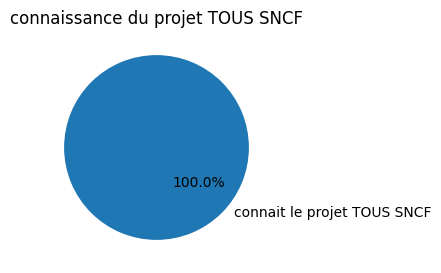

In [ ]:
labels_mapping = {
    1: "connait le projet TOUS SNCF",
    0: "Ne connait pas le projet TOUS SNCF"
}

# Comptage des valeurs pour le graphique

value_counts = Base_2023_renamed['indicateur_connaissance_1'].value_counts()

# Générer les labels en utilisant le labels_mapping

labels = [labels_mapping[int(k)] for k in value_counts.index]

# Création du diagramme en secteurs avec les étiquettes personnalisées
plt.figure(figsize=(3,3))
plt.pie(
    value_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140
)
plt.title('connaissance du projet TOUS SNCF')
plt.ylabel('')  # Supprime l'étiquette de l'axe y pour plus de clarté
plt.show()



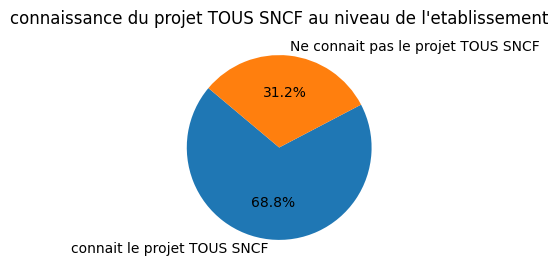

In [ ]:
labels_mapping = {
    1: "connait le projet TOUS SNCF",
    0: "Ne connait pas le projet TOUS SNCF"
}

# Comptage des valeurs pour le graphique

value_counts = Base_2023_renamed['connaisance_projet_etablissement'].value_counts()

# Générer les labels en utilisant le labels_mapping

labels = [labels_mapping[int(k)] for k in value_counts.index]

# Création du diagramme en secteurs avec les étiquettes personnalisées
plt.figure(figsize=(3,3))
plt.pie(
    value_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140
)
plt.title("connaissance du projet TOUS SNCF au niveau de l'etablissement")
plt.ylabel('')  # Supprime l'étiquette de l'axe y pour plus de clarté
plt.show()

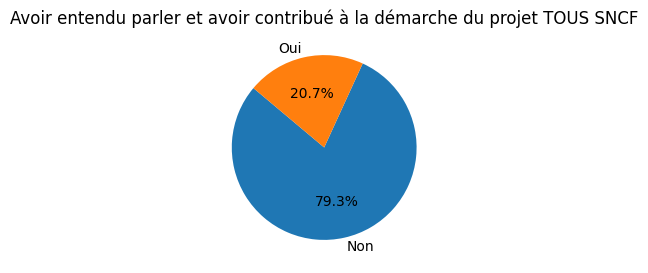

In [ ]:
labels_mapping = {
    1: "Oui",
    0: "Non"
}

# Comptage des valeurs pour le graphique

value_counts = Base_2023_renamed['avoir_entendu_parler_duprojet_demonetablisma_ouentite_danslecadre_projetTOUSSNCF_1'].value_counts()

# Générer les labels en utilisant le labels_mapping

labels = [labels_mapping[int(k)] for k in value_counts.index]

# Création du diagramme en secteurs avec les étiquettes personnalisées
plt.figure(figsize=(3,3))
plt.pie(
    value_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140
)
plt.title('Avoir entendu parler et avoir contribué à la démarche du projet TOUS SNCF')
plt.ylabel('')  # Supprime l'étiquette de l'axe y pour plus de clarté
plt.show()


<ipython-input-38-55ef9a061e57>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=results.index, y=results['Proportion (%)'], palette='viridis')


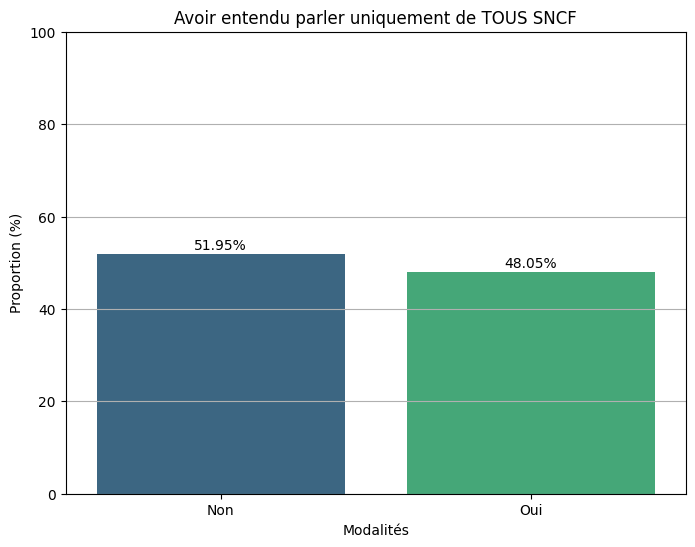

In [ ]:
frequencies = Base_2023_renamed['avoir_entendu_parler_duprojet_demonetablisma_ouentite_danslecadre_projetTOUSSNCF_2'].value_counts()

proportions = (frequencies / len(Base_2023_renamed)) * 100

# Remplacer les modalités 0 et 1 par Non et Oui dans l'index

frequencies.index = frequencies.index.map({0: 'Non', 1: 'Oui'})
proportions.index = proportions.index.map({0: 'Non', 1: 'Oui'})

results = pd.DataFrame({
    'Frequency': frequencies,
    'Proportion (%)': proportions
})

# Visualiser les résultats avec seaborn

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=results.index, y=results['Proportion (%)'], palette='viridis')

# Ajouter les pourcentages au-dessus des barres
for index, row in results.iterrows():
    ax.text(index, row['Proportion (%)'] + 1, f"{row['Proportion (%)']:.2f}%", ha='center')

plt.title('Avoir entendu parler uniquement de TOUS SNCF')
plt.ylabel('Proportion (%)')
plt.xlabel('Modalités')
plt.ylim(0, 100)  # Limiter l'axe des Y pour correspondre à 100%
plt.xticks(rotation=0)  # Rotation des labels de l'axe X
plt.grid(axis='y')  # Ajouter une grille horizontale
plt.show()


In [ ]:
frequence = Base_2023_renamed['avoir_entendu_parler_duprojet_demonetablisma_ouentite_danslecadre_projetTOUSSNCF_3'].value_counts()

Pourcentage = (frequence/ len(Base_2023_renamed)) * 100

# Remplacer les modalités 0 et 1 par Non et Oui dans l'index
frequence.index = frequence.index.map({0: 'Non', 1: 'Oui'})
Pourcentage.index = Pourcentage.index.map({0: 'Non', 1: 'Oui'})

results = pd.DataFrame({
    'Frequency': frequence,
    'Proportion (%)': Pourcentage
})

print(results)



                                                    Frequency  Proportion (%)
avoir_entendu_parler_duprojet_demonetablisma_ou...                           
Non                                                     69348       69.961563
Oui                                                     29775       30.038437


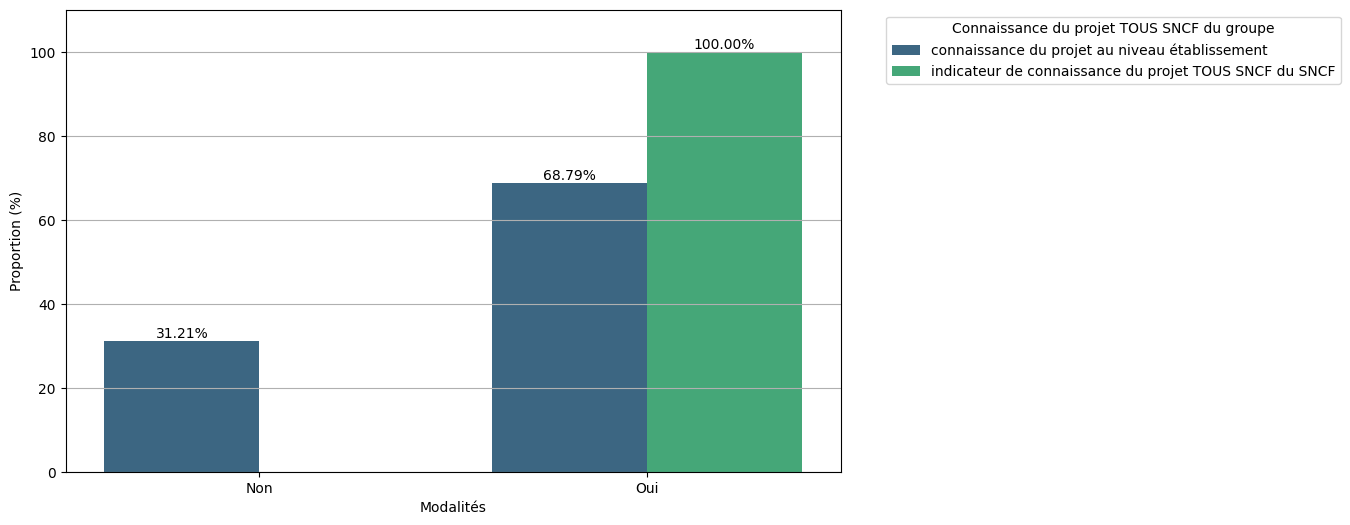

In [ ]:
##indicteur de connaissance du projet TOUS SNCF de l'entité

Variable=['connaisance_projet_etablissement','indicateur_connaissance_1']

variable_mapping={'connaisance_projet_etablissement':'connaissance du projet au niveau établissement',
                  'indicateur_connaissance_1':'indicateur de connaissance du projet TOUS SNCF du SNCF'}

# Transformer les données en format long

Base_2023_renamed_long = pd.melt(Base_2023_renamed[Variable], var_name='Variable', value_name='Modality')

Base_2023_renamed_long['Modality'] = Base_2023_renamed_long['Modality'].map({0: 'Non', 1: 'Oui'})

Base_2023_renamed_long['Variable'] = Base_2023_renamed_long['Variable'].map(variable_mapping)

# Calculer les fréquences

frequencies = Base_2023_renamed_long.groupby(['Variable', 'Modality']).size().reset_index(name='Frequency')

# Calculer les proportions

frequencies['Proportion (%)'] = (frequencies['Frequency'] / len(Base_2023_renamed)) * 100


plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Modality', y='Proportion (%)', hue='Variable', data=frequencies, palette='viridis')

# Ajouter les pourcentages au-dessus des barres
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%')

plt.title('')
plt.ylabel('Proportion (%)')
plt.xlabel('Modalités')
plt.xticks(rotation=0)  # Rotation des labels de l'axe X
plt.ylim(0, frequencies['Proportion (%)'].max() + 10)  # Ajuster l'axe Y
plt.grid(axis='y')  # Ajouter une grille horizontale
plt.legend(title='Connaissance du projet TOUS SNCF du groupe', bbox_to_anchor=(1.05, 1), loc='upper left')  # Positionner la légende
plt.show()

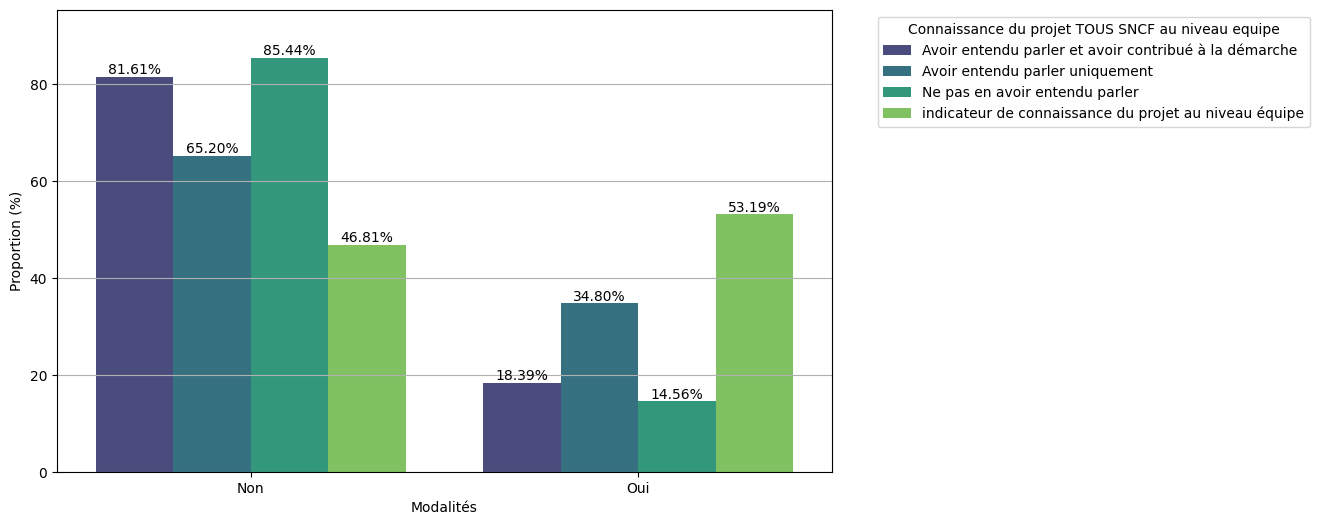

In [ ]:
###Au niveau équipe


Variable=['Avoir_entendu_parler_duprojet_TOUSSNCF_de_votre_equipe_1','connaissance_projet_equipe',
          'Avoir_entendu_parler_duprojet_TOUSSNCF_de_votre_equipe_2','Avoir_entendu_parler_duprojet_TOUSSNCF_de_votre_equipe_3']

variable_mapping={'Avoir_entendu_parler_duprojet_TOUSSNCF_de_votre_equipe_1':'Avoir entendu parler et avoir contribué à la démarche',
                  'Avoir_entendu_parler_duprojet_TOUSSNCF_de_votre_equipe_2':'Avoir entendu parler uniquement',
                  'Avoir_entendu_parler_duprojet_TOUSSNCF_de_votre_equipe_3':'Ne pas en avoir entendu parler',
                  'connaissance_projet_equipe':'indicateur de connaissance du projet au niveau équipe'}

# Transformer les données en format long

Base_2023_renamed_long = pd.melt(Base_2023_renamed[Variable], var_name='Variable', value_name='Modality')

Base_2023_renamed_long['Modality'] = Base_2023_renamed_long['Modality'].map({0: 'Non', 1: 'Oui'})

Base_2023_renamed_long['Variable'] = Base_2023_renamed_long['Variable'].map(variable_mapping)

# Calculer les fréquences

frequencies = Base_2023_renamed_long.groupby(['Variable', 'Modality']).size().reset_index(name='Frequency')

# Calculer les proportions

frequencies['Proportion (%)'] = (frequencies['Frequency'] / len(Base_2023_renamed)) * 100


plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Modality', y='Proportion (%)', hue='Variable', data=frequencies, palette='viridis')

# Ajouter les pourcentages au-dessus des barres
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%')

plt.title('')
plt.ylabel('Proportion (%)')
plt.xlabel('Modalités')
plt.xticks(rotation=0)  # Rotation des labels de l'axe X
plt.ylim(0, frequencies['Proportion (%)'].max() + 10)  # Ajuster l'axe Y
plt.grid(axis='y')  # Ajouter une grille horizontale
plt.legend(title='Connaissance du projet TOUS SNCF au niveau equipe', bbox_to_anchor=(1.05, 1), loc='upper left')  # Positionner la légende
plt.show()




######repartition suivant la SA,le sexe et la classe

<ipython-input-42-6ff1b79990bb>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=results.index, y=results['Proportion (%)'], palette='viridis')


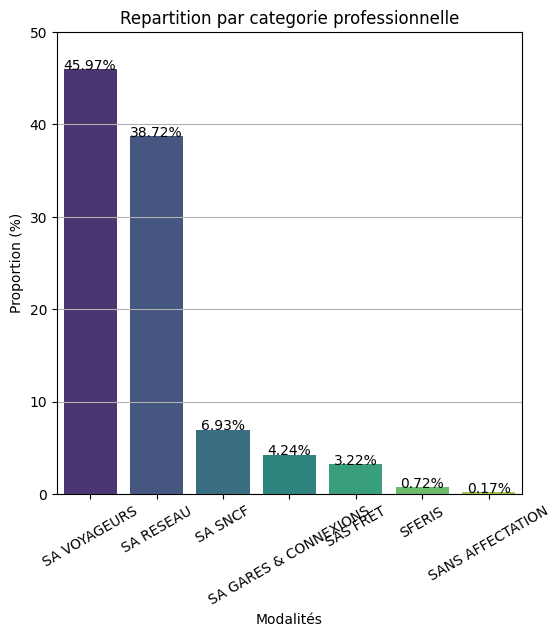

In [ ]:
#mape={'1':'SAS FRET','2':'SA GARES & CONNEXIONS','3':'SA RESEAU','4': 'SA SNCF','5': 'SA VOYAGEURS','6':'SFERIS','8':'SANS AFFECTATION','9':'Sans réponse'}

#Base_2023_renamed['Niveau_SA'] = Base_2023_renamed['Niveau SA'].map(mape)

frequencies = Base_2023_renamed['Niveau SA'].value_counts()

proportions = (frequencies / len(Base_2023_renamed)) * 100

# Remplacer les modalités 0 et 1 par Non et Oui dans l'index

frequencies.index = frequencies.index.map({1:'SAS FRET',2:'SA GARES & CONNEXIONS',3:'SA RESEAU',4: 'SA SNCF',5: 'SA VOYAGEURS',6:'SFERIS',8:'SANS AFFECTATION'})
proportions.index = proportions.index.map({1:'SAS FRET',2:'SA GARES & CONNEXIONS',3:'SA RESEAU',4: 'SA SNCF',5: 'SA VOYAGEURS',6:'SFERIS',8:'SANS AFFECTATION'})

results = pd.DataFrame({
    'Frequency': frequencies,
    'Proportion (%)': proportions
})

# Visualiser les résultats avec seaborn

plt.figure(figsize=(6,6))
ax = sns.barplot(x=results.index, y=results['Proportion (%)'], palette='viridis')

# Ajouter les pourcentages au-dessus des barres
for index, row in results.iterrows():
    ax.text(index, row['Proportion (%)'], f"{row['Proportion (%)']:.2f}%", ha='center')

plt.title('Repartition par categorie professionnelle')
plt.ylabel('Proportion (%)')
plt.xlabel('Modalités')
plt.ylim(0, 50)  # Limiter l'axe des Y pour correspondre à 100%
plt.xticks(rotation=30)  # Rotation des labels de l'axe X
plt.grid(axis='y')  # Ajouter une grille horizontale
plt.show()


         sex  sex_prop(%)
SEXE                     
Homme  75504    76.172029
Femme  22704    22.904876
autre    915     0.923096


<ipython-input-43-7a06a20fe0e6>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=results.index, y=results['sex_prop(%)'], palette='viridis')


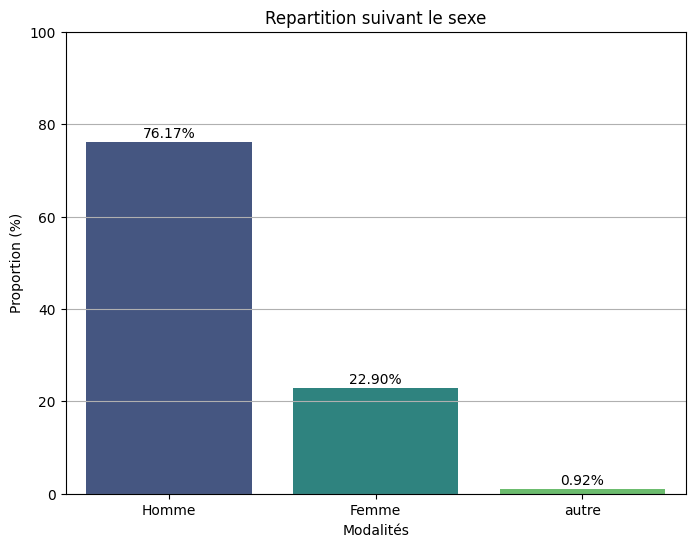

In [ ]:
##Sexe

sex = Base_2023_renamed['SEXE'].value_counts()

sex_prop = (sex/len(Base_2023_renamed)) * 100

# Remplacer les modalités 0 et 1 par Non et Oui dans l'index

sex.index = sex.index.map({1: 'Homme', 2: 'Femme',3:'autre'})
sex_prop.index = sex_prop.index.map({1: 'Homme', 2: 'Femme',3: 'autre'})

results = pd.DataFrame({
    'sex': sex,
    'sex_prop(%)': sex_prop
})

print(results)
# Visualiser les résultats avec seaborn

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=results.index, y=results['sex_prop(%)'], palette='viridis')

# Ajouter les pourcentages au-dessus des barres
for index, row in results.iterrows():
    ax.text(index, row['sex_prop(%)'] + 1, f"{row['sex_prop(%)']:.2f}%", ha='center')

plt.title('Repartition suivant le sexe')
plt.ylabel('Proportion (%)')
plt.xlabel('Modalités')
plt.ylim(0, 100)  # Limiter l'axe des Y pour correspondre à 100%
plt.xticks(rotation=0)  # Rotation des labels de l'axe X
plt.grid(axis='y')  # Ajouter une grille horizontale
plt.show()


In [ ]:
print(Base_2023_renamed['CLASSE'].value_counts())

CLASSE
4     22274
3     18051
6     13634
5     12917
2     10756
7      8183
8      5383
1      3592
9      2265
15     2032
11       31
10        5
Name: count, dtype: int64


<ipython-input-45-d4b10415c085>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=results.index, y=results['Classe_prop(%)'], palette='viridis')


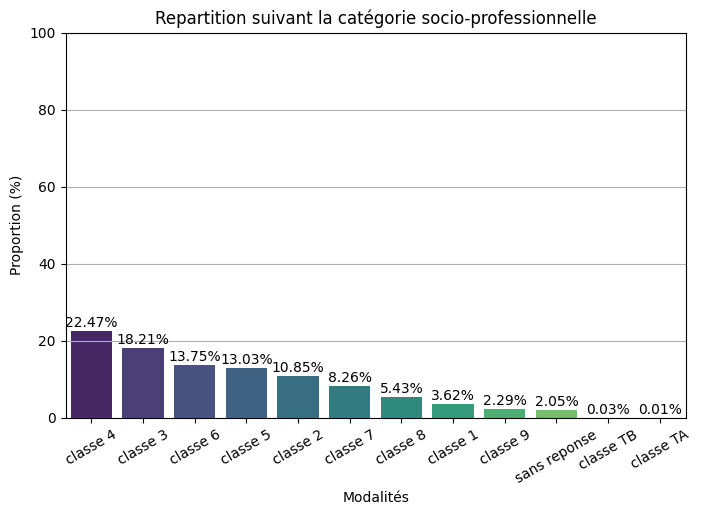

In [ ]:
##catégorie professionnelle

Classe = Base_2023_renamed['CLASSE'].value_counts()

Classe_prop = (Classe/len(Base_2023_renamed)) * 100

# Remplacer les modalités 0 et 1 par Non et Oui dans l'index

Classe.index = Classe.index.map({1: 'classe 1', 2: 'classe 2',3:'classe 3',4:'classe 4',5:'classe 5',6:'classe 6',7:'classe 7',8:'classe 8',
                              9:'classe 9',10:'classe TA',11:'classe TB',15:'sans reponse'})
Classe_prop.index = Classe_prop.index.map({1: 'classe 1', 2: 'classe 2',3:'classe 3',4:'classe 4',5:'classe 5',6:'classe 6',7:'classe 7',8:'classe 8',
                                        9:'classe 9',10:'classe TA',11:'classe TB',15:'sans reponse'})

results = pd.DataFrame({
    'Classe': Classe,
    'Classe_prop(%)': Classe_prop
})

# Visualiser les résultats avec seaborn

plt.figure(figsize=(8,5))
ax = sns.barplot(x=results.index, y=results['Classe_prop(%)'], palette='viridis')

# Ajouter les pourcentages au-dessus des barres
for index, row in results.iterrows():
    ax.text(index, row['Classe_prop(%)'] + 1, f"{row['Classe_prop(%)']:.2f}%", ha='center')

plt.title('Repartition suivant la catégorie socio-professionnelle')
plt.ylabel('Proportion (%)')
plt.xlabel('Modalités')
plt.ylim(0, 100)  # Limiter l'axe des Y pour correspondre à 100%
plt.xticks(rotation=30)  # Rotation des labels de l'axe X
plt.grid(axis='y')  # Ajouter une grille horizontale
plt.show()

#####	Etat d’esprit, Engagement et qualité de vie au travail des employés de la SNCF

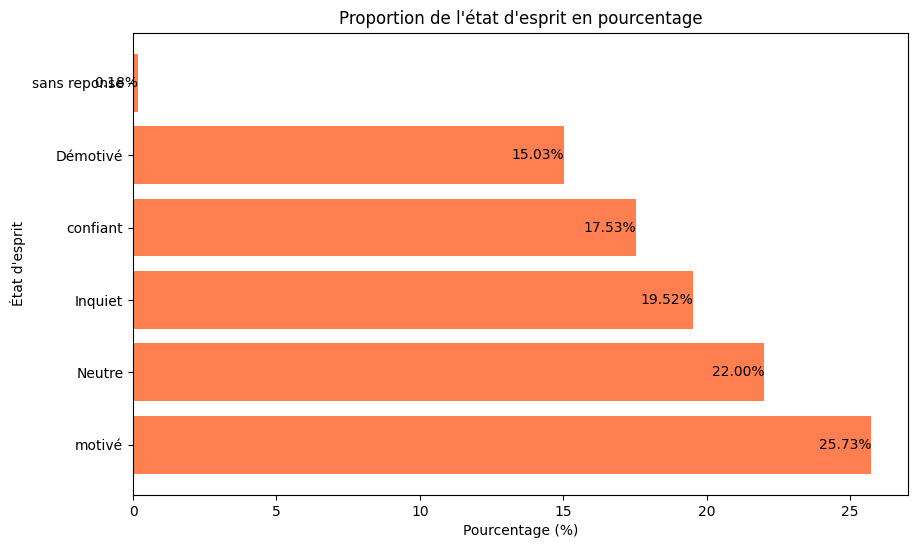

In [ ]:

# Comptage des valeurs pour le graphique
etat_desprit = Base_2023_renamed['etat_desprit'].value_counts()

# Calcul des proportions en pourcentage
etat_desprit_prop = (etat_desprit / len(Base_2023_renamed)) * 100

# Remplacer les modalités numériques par des labels
labels_mapping = {
    1: 'motivé',
    2: 'confiant',
    3: 'Neutre',
    4: 'Inquiet',
    5: 'Démotivé',
    6: 'sans reponse'
}

# Appliquer les labels
etat_desprit.index = etat_desprit.index.map(labels_mapping)
etat_desprit_prop.index = etat_desprit_prop.index.map(labels_mapping)

# Création de l'histogramme horizontal des proportions
plt.figure(figsize=(10, 6))  # Taille de la figure
plt.barh(etat_desprit_prop.index, etat_desprit_prop.values, color='coral')

# Ajouter des labels et un titre
plt.xlabel('Pourcentage (%)')
plt.ylabel('État d\'esprit')
plt.title('Proportion de l\'état d\'esprit en pourcentage')

# Afficher les valeurs sur les barres
for index, value in enumerate(etat_desprit_prop.values):
    plt.text(value, index, f'{value:.2f}%', va='center', ha='right')

# Afficher le graphique
plt.show()


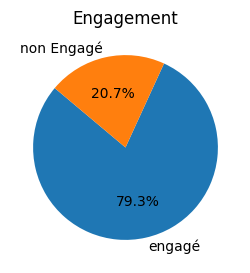

In [ ]:
#engagement

labels_mapping = {
    1: 'engagé',
    0: 'non Engagé'
 }

# Comptage des valeurs pour le graphique classe_engagement


valuecount = Base_2023_renamed['engagement_indicateur'].value_counts()

# Générer les labels en utilisant le labels_mapping

labels = [labels_mapping[int(k)] for k in valuecount.index]

# Création du diagramme en secteurs avec les étiquettes personnalisées

plt.figure(figsize=(3,3))
plt.pie(
    value_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140
)
plt.title('Engagement')
plt.ylabel('')  # Supprime l'étiquette de l'axe y pour plus de clarté
plt.show()



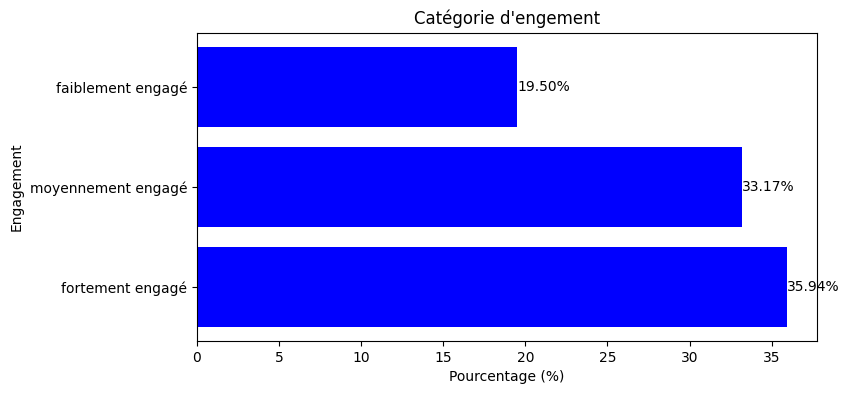

In [ ]:
##repartition suivant la classe d'negagement

classe_engag = Base_2023_renamed['classe_engagement'].value_counts()

# Calcul des proportions en pourcentage
classe_engag_prop = (classe_engag / len(Base_2023_renamed)) * 100

#print(classe_engag_prop)
# Remplacer les modalités numériques par des labels

#classe_engag.index = classe_engag.index.map({1: 'motivé', 2: 'confiant', 3: 'Neutre', 4: 'Inquiet', 5: 'Démotivé',6:'sans reponse'})
#classe_engag_prop.index = classe_engag_prop.index.map({1: 'motivé', 2: 'confiant', 3: 'Neutre', 4: 'Inquiet', 5: 'Démotivé',6:'sans reponse'})

# Assurez-vous que les index sont des chaînes de caractères pour éviter les erreurs
#classe_engag.index = classe_engag.index.astype(str)
#classe_engag_prop.index = classe_engag_prop.index.astype(str)

# Création de l'histogramme horizontal des proportions
plt.figure(figsize=(8, 4))  # Taille de la figure
plt.barh(classe_engag_prop.index, classe_engag_prop.values, color='blue')

# Ajouter des labels et un titre
plt.xlabel('Pourcentage (%)')
plt.ylabel('Engagement')
plt.title("Catégorie d'engement")

# Afficher les valeurs sur les barres
for index, value in enumerate(classe_engag_prop.values):
    plt.text(value, index, f'{value:.2f}%', va='center')

# Afficher le graphique
plt.show()

                                                    croyance_TOUSSNCF  \
croire_aux_orientations_du_projet_TOUSSNCF_dans...                      
croit moyennement                                               44267   
ne croit pas faiblement                                         25321   
ne croit pas fortement                                          15034   
croit fortement                                                  9280   
neutre                                                           5221   

                                                    croyance_TOUSSNCF_prop(%)  
croire_aux_orientations_du_projet_TOUSSNCF_dans...                             
croit moyennement                                                   44.658656  
ne croit pas faiblement                                             25.545030  
ne croit pas fortement                                              15.167015  
croit fortement                                                      9.362106  
neutre  

<ipython-input-49-7983f324a0a9>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=results.index, y=results['croyance_TOUSSNCF_prop(%)'], palette='viridis')


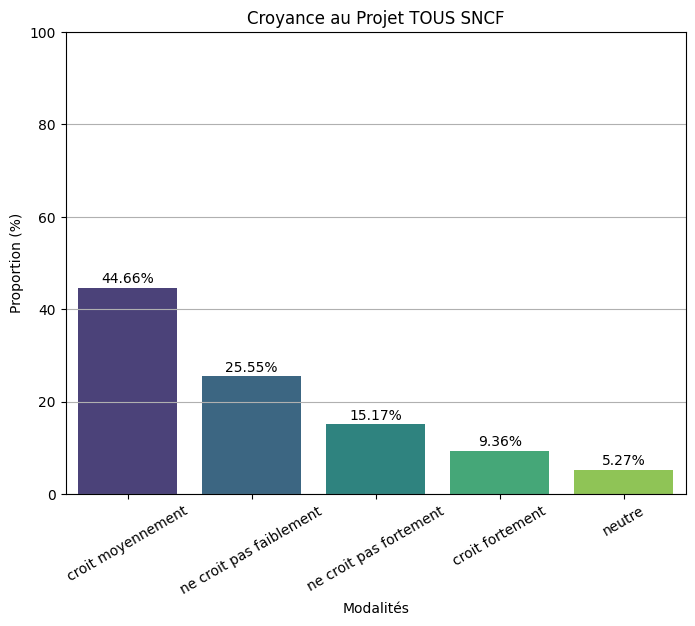

In [ ]:
##croyance au projet TOUS SNCF

croyance_TOUSSNCF = Base_2023_renamed['croire_aux_orientations_du_projet_TOUSSNCF_dans_mon_établissement_ou_entité_ou_équipe_les_soutenir'].value_counts()

croyance_TOUSSNCF_prop = (croyance_TOUSSNCF/len(Base_2023_renamed)) * 100

# Remplacer les modalités 0 et 1 par Non et Oui dans l'index

croyance_TOUSSNCF.index = croyance_TOUSSNCF.index.map({1: 'croit fortement', 2: 'croit moyennement',3:'ne croit pas faiblement',4:'ne croit pas fortement',5:'neutre'})
croyance_TOUSSNCF_prop.index = croyance_TOUSSNCF_prop.index.map({1: 'croit fortement', 2: 'croit moyennement',3:'ne croit pas faiblement',4:'ne croit pas fortement',5:'neutre'})

results = pd.DataFrame({
    'croyance_TOUSSNCF': croyance_TOUSSNCF,
    'croyance_TOUSSNCF_prop(%)': croyance_TOUSSNCF_prop
})

print(results)
# Visualiser les résultats avec seaborn

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=results.index, y=results['croyance_TOUSSNCF_prop(%)'], palette='viridis')

# Ajouter les pourcentages au-dessus des barres
for index, row in results.iterrows():
    ax.text(index, row['croyance_TOUSSNCF_prop(%)'] + 1, f"{row['croyance_TOUSSNCF_prop(%)']:.2f}%", ha='center')

plt.title('Croyance au Projet TOUS SNCF')
plt.ylabel('Proportion (%)')
plt.xlabel('Modalités')
plt.ylim(0, 100)  # Limiter l'axe des Y pour correspondre à 100%
plt.xticks(rotation=30)  # Rotation des labels de l'axe X
plt.grid(axis='y')  # Ajouter une grille horizontale
plt.show()



### Etat d’esprit, engagement et qualité de vie selon la SA, l’établissement et le sexe

  etat_desprit SEXE_label  count  percentage
0     Démotivé      autre     45    0.301993
1     Démotivé      femme   3445   23.119254
2     Démotivé      homme  11411   76.578753
3      Inquiet      autre     71    0.366887
4      Inquiet      femme   3747   19.362340


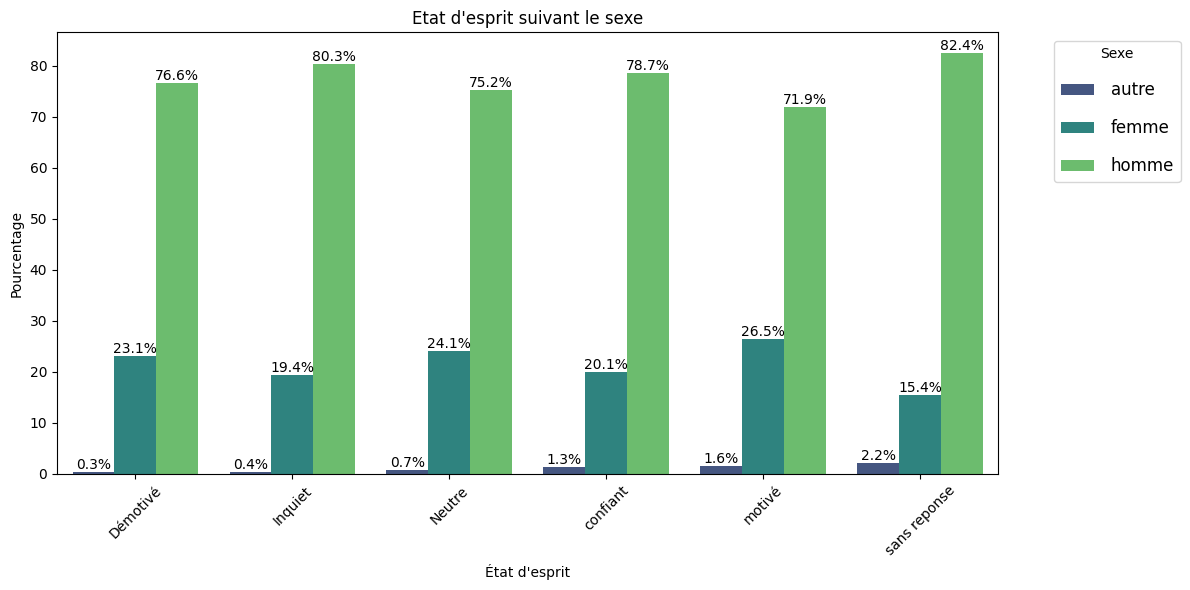

,ID BDD,ANNEE,SEXE,CLASSE,SNCF_Group,Niveau SA,Niveau 3,etat_desprit,aimer_travailler_pour_SNCF,etre_fier_de_travailler_pour_SNCF,...,satisfaction_outils_informatiques_bis,satisfaction_soutient_descollegues_bis,satisfaction_soutient_mon_manage_bis,satisfaction_acces_informations_metiers_bis,satisfaction_temps_bis,benefier_informations_necessaires_montravail_bis,QVT_somme,QVT_indicateur,QVT_indicateur_bis,classe_QVT
0,1,2023,1,4,1,5.0,32.0,Inquiet,3,3,...,0,0,0,0,0,0,0,0,0.000000,NaN
1,2,2023,1,2,1,5.0,34.0,motivé,1,1,...,1,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée
2,3,2023,1,4,1,5.0,32.0,Neutre,2,3,...,0,1,1,1,0,1,7,1,0.583333,Qualité de vie moyenne
3,4,2023,1,5,1,5.0,34.0,Neutre,2,2,...,1,1,1,1,1,1,11,1,0.916667,Qualité de vie élevée
4,5,2023,1,2,1,5.0,32.0,motivé,1,1,...,1,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99118,99119,2023,1,15,1,2.0,1.0,motivé,1,1,...,0,1,1,0,1,0,6,1,0.500000,Qualité de vie faible
99119,99120,2023,1,6,1,3.0,36.0,Inquiet,1,1,...,1,1,1,1,0,1,8,1,0.666667,Qualité de vie moyenne
99120,99121,2023,2,5,1,5.0,34.0,Neutre,2,2,...,1,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée
99121,99122,2023,2,1,1,4.0,24.0,Neutre,2,1,...,1,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée


In [ ]:
# Mappings
label_sex = {1: 'homme', 2: 'femme', 3: 'autre'}
labels_mapping = {
    1: 'motivé',
    2: 'confiant',
    3: 'Neutre',
    4: 'Inquiet',
    5: 'Démotivé',
    6: 'sans reponse'
}

# Appliquer les mappings
Base_2023_renamed['SEXE_label'] = Base_2023_renamed['SEXE'].map(label_sex)
Base_2023_renamed['etat_desprit'] = Base_2023_renamed['etat_desprit'].map(labels_mapping)

# Calculer les pourcentages
percentage_df = (
    Base_2023_renamed.groupby(['etat_desprit', 'SEXE_label'])
    .size()
    .reset_index(name='count')
    .groupby('etat_desprit')
    .apply(lambda x: x.assign(percentage=100 * x['count'] / x['count'].sum()))
    .reset_index(drop=True)
)

# Vérifiez les pourcentages calculés
print(percentage_df.head())

# Définir une palette de couleurs
palette = sns.color_palette('viridis', n_colors=3)

# Tracer le graphique
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=percentage_df, x='etat_desprit', y='percentage', hue='SEXE_label', palette=palette)

# Ajustements esthétiques
plt.title("Etat d'esprit suivant le sexe")
plt.xlabel('État d\'esprit')
plt.ylabel('Pourcentage')

# Configurer les étiquettes des abscisses
plt.xticks(rotation=45)

# Créer une légende manuelle
legend_labels = label_sex
legend_colors = palette


# Ajouter la légende au graphique
plt.legend(title='Sexe', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large', title_fontsize='10', labelspacing=1.2, handletextpad=1)

# Annoter les barres avec les pourcentages
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=10)

# Ajustement de la mise en page
plt.tight_layout()

# Affichage
plt.show()

Base_2023_renamed.drop(columns='SEXE_label')

In [ ]:
print(Base_2023_renamed['etat_desprit'].value_counts())

etat_desprit
motivé          25504
Neutre          21803
Inquiet         19352
confiant        17381
Démotivé        14901
sans reponse      182
Name: count, dtype: int64


  etat_desprit SEXE_label  count  percentage
0     Démotivé      autre     45    4.918033
1      Inquiet      autre     71    7.759563
2       Neutre      autre    162   17.704918
3     confiant      autre    223   24.371585
4       motivé      autre    410   44.808743


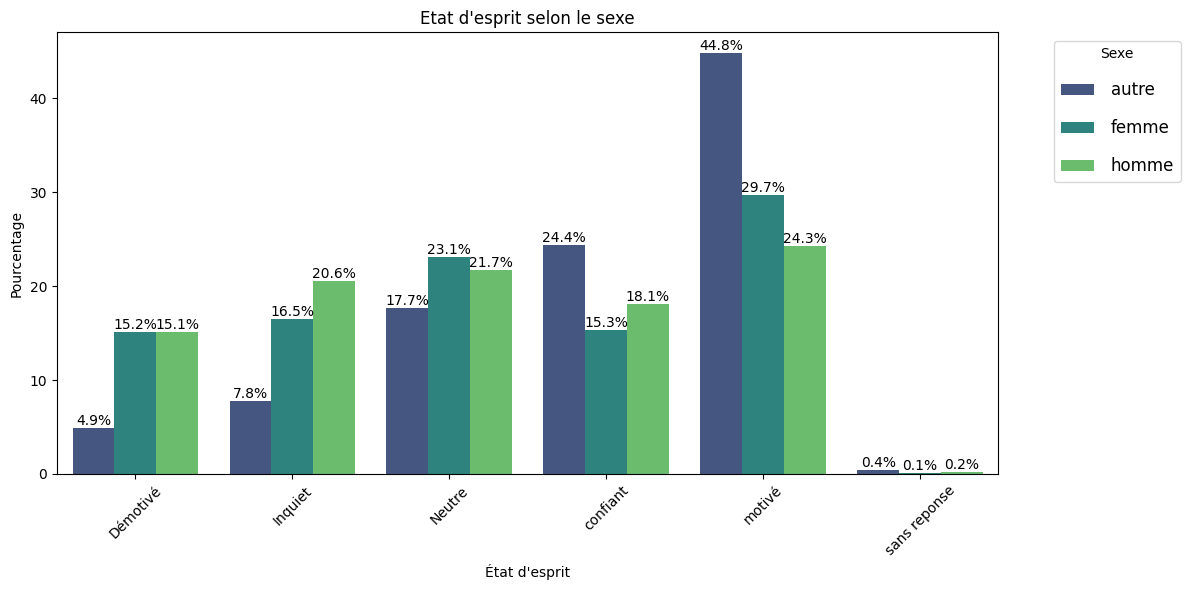

,ID BDD,ANNEE,SEXE,CLASSE,SNCF_Group,Niveau SA,Niveau 3,etat_desprit,aimer_travailler_pour_SNCF,etre_fier_de_travailler_pour_SNCF,...,satisfaction_outils_informatiques_bis,satisfaction_soutient_descollegues_bis,satisfaction_soutient_mon_manage_bis,satisfaction_acces_informations_metiers_bis,satisfaction_temps_bis,benefier_informations_necessaires_montravail_bis,QVT_somme,QVT_indicateur,QVT_indicateur_bis,classe_QVT
0,1,2023,1,4,1,5.0,32.0,Inquiet,3,3,...,0,0,0,0,0,0,0,0,0.000000,NaN
1,2,2023,1,2,1,5.0,34.0,motivé,1,1,...,1,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée
2,3,2023,1,4,1,5.0,32.0,Neutre,2,3,...,0,1,1,1,0,1,7,1,0.583333,Qualité de vie moyenne
3,4,2023,1,5,1,5.0,34.0,Neutre,2,2,...,1,1,1,1,1,1,11,1,0.916667,Qualité de vie élevée
4,5,2023,1,2,1,5.0,32.0,motivé,1,1,...,1,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99118,99119,2023,1,15,1,2.0,1.0,motivé,1,1,...,0,1,1,0,1,0,6,1,0.500000,Qualité de vie faible
99119,99120,2023,1,6,1,3.0,36.0,Inquiet,1,1,...,1,1,1,1,0,1,8,1,0.666667,Qualité de vie moyenne
99120,99121,2023,2,5,1,5.0,34.0,Neutre,2,2,...,1,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée
99121,99122,2023,2,1,1,4.0,24.0,Neutre,2,1,...,1,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée


In [ ]:
# Mappings

label_sex = {1: 'homme', 2: 'femme', 3: 'autre'}

labels_mapping = {
    1: 'motivé',
    2: 'confiant',
    3: 'Neutre',
    4: 'Inquiet',
    5: 'Démotivé',
    6: 'sans reponse'
}

# Appliquer les mappings

Base_2023_renamed['SEXE_label'] = Base_2023_renamed['SEXE'].map(label_sex)
#Base_2023_renamed['etat_desprit_label'] = Base_2023_renamed['etat_desprit'].map(labels_mapping)

# Calculer les pourcentages

percentage_df = (
    Base_2023_renamed.groupby(['etat_desprit','SEXE_label'])
    .size()
    .reset_index(name='count')
    .groupby('SEXE_label')
    .apply(lambda x: x.assign(percentage=100 * x['count'] / x['count'].sum()))
    .reset_index(drop=True)
)

# Vérifiez les pourcentages calculés

print(percentage_df.head())

# Définir une palette de couleurs
palette = sns.color_palette('viridis', n_colors=3)

# Tracer le graphique
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=percentage_df, x='etat_desprit', y='percentage', hue='SEXE_label', palette=palette)

# Ajustements esthétiques

plt.title("Etat d'esprit selon le sexe")
plt.xlabel('État d\'esprit')
plt.ylabel('Pourcentage')

# Configurer les étiquettes des abscisses
plt.xticks(rotation=45)

# Créer une légende manuelle
legend_labels = label_sex
legend_colors = palette


# Ajouter la légende au graphique

plt.legend(title='Sexe', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large', title_fontsize='10', labelspacing=1.2, handletextpad=1)

# Annoter les barres avec les pourcentages
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=10)

# Ajustement de la mise en page
plt.tight_layout()

# Affichage

plt.show()
Base_2023_renamed.drop(columns='SEXE_label')

  etat_desprit        Niveau_SA_label  count  percentage_sa
0     Démotivé  SA GARES & CONNEXIONS    441       2.960129
1     Démotivé              SA RESEAU   5555      37.286884
2     Démotivé                SA SNCF    811       5.443684
3     Démotivé           SA VOYAGEURS   7418      49.791918
4     Démotivé       SANS AFFECTATION     16       0.107397


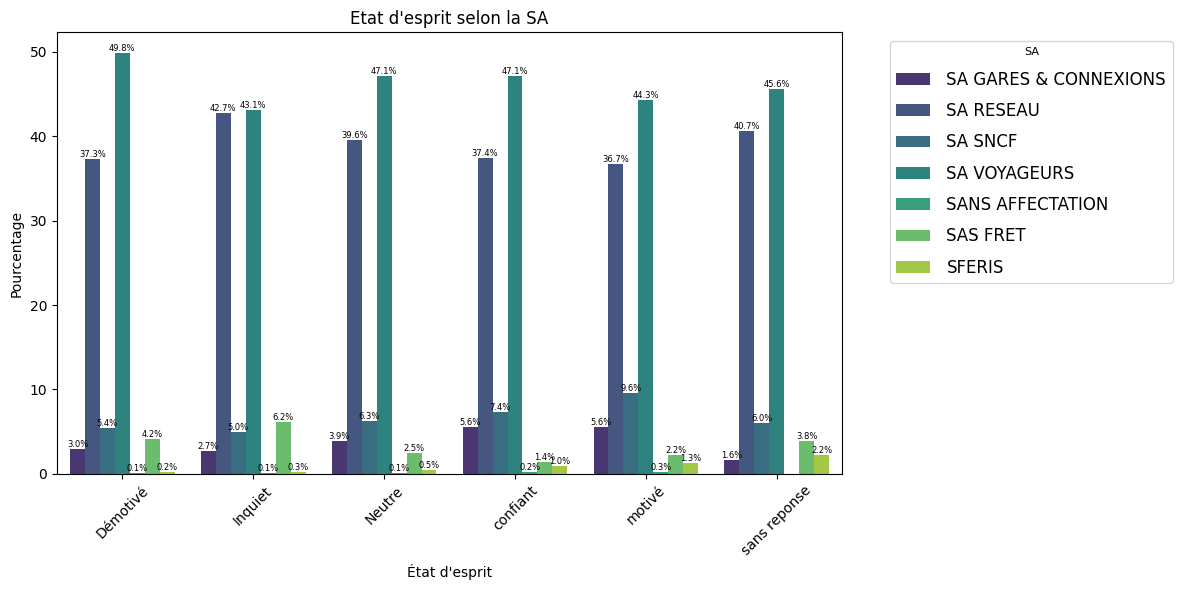

,ID BDD,ANNEE,SEXE,CLASSE,SNCF_Group,Niveau SA,Niveau 3,etat_desprit,aimer_travailler_pour_SNCF,etre_fier_de_travailler_pour_SNCF,...,satisfaction_soutient_descollegues_bis,satisfaction_soutient_mon_manage_bis,satisfaction_acces_informations_metiers_bis,satisfaction_temps_bis,benefier_informations_necessaires_montravail_bis,QVT_somme,QVT_indicateur,QVT_indicateur_bis,classe_QVT,SEXE_label
0,1,2023,1,4,1,5.0,32.0,Inquiet,3,3,...,0,0,0,0,0,0,0,0.000000,NaN,homme
1,2,2023,1,2,1,5.0,34.0,motivé,1,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme
2,3,2023,1,4,1,5.0,32.0,Neutre,2,3,...,1,1,1,0,1,7,1,0.583333,Qualité de vie moyenne,homme
3,4,2023,1,5,1,5.0,34.0,Neutre,2,2,...,1,1,1,1,1,11,1,0.916667,Qualité de vie élevée,homme
4,5,2023,1,2,1,5.0,32.0,motivé,1,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99118,99119,2023,1,15,1,2.0,1.0,motivé,1,1,...,1,1,0,1,0,6,1,0.500000,Qualité de vie faible,homme
99119,99120,2023,1,6,1,3.0,36.0,Inquiet,1,1,...,1,1,1,0,1,8,1,0.666667,Qualité de vie moyenne,homme
99120,99121,2023,2,5,1,5.0,34.0,Neutre,2,2,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme
99121,99122,2023,2,1,1,4.0,24.0,Neutre,2,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme


In [ ]:
##Etat d'esprit selon la SA

label_SA = {1:'SAS FRET',2:'SA GARES & CONNEXIONS',3:'SA RESEAU',4: 'SA SNCF',5: 'SA VOYAGEURS',6:'SFERIS',8:'SANS AFFECTATION'}

labels_mapping = {
    1: 'motivé',
    2: 'confiant',
    3: 'Neutre',
    4: 'Inquiet',
    5: 'Démotivé',
    6: 'sans reponse'
}

# Appliquer les mappings

Base_2023_renamed['Niveau_SA_label'] = Base_2023_renamed['Niveau SA'].map(label_SA)
#Base_2023_renamed['etat_desprit'] = Base_2023_renamed['etat_desprit'].map(labels_mapping)

# Calculer les pourcentages

percentage_df_SA = (
    Base_2023_renamed.groupby(['etat_desprit', 'Niveau_SA_label'])
    .size()
    .reset_index(name='count')
    .groupby('etat_desprit')
    .apply(lambda x: x.assign(percentage_sa=100 * x['count'] / x['count'].sum()))
    .reset_index(drop=True)
)

# Vérifiez les pourcentages calculés
print(percentage_df_SA.head())

# Définir une palette de couleurs
palette = sns.color_palette('viridis', n_colors=7)

# Tracer le graphique
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=percentage_df_SA, x='etat_desprit', y='percentage_sa', hue='Niveau_SA_label', palette=palette)

# Ajustements esthétiques
plt.title("Etat d'esprit selon la SA")
plt.xlabel('État d\'esprit')
plt.ylabel('Pourcentage')

plt.xticks(rotation=45)

legend_labels = label_SA
legend_colors = palette

#legend_patches = [Patch(color=legend_colors[i], label=legend_labels[i], edgecolor='black', linewidth=1.5) for i in range(len(legend_labels))]
plt.legend(title='SA', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large', title_fontsize='8', labelspacing=0.8, handletextpad=1)

# Annoter les barres avec les pourcentages
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=6)

# Ajustement de la mise en page
plt.tight_layout()

# Affichage
plt.show()

Base_2023_renamed.drop(columns='Niveau_SA_label')


    etat_desprit        Niveau_SA_label  count  percentage_sa
0       Démotivé  SA GARES & CONNEXIONS    441      10.502501
1        Inquiet  SA GARES & CONNEXIONS    520      12.383901
2         Neutre  SA GARES & CONNEXIONS    841      20.028578
3       confiant  SA GARES & CONNEXIONS    967      23.029293
4         motivé  SA GARES & CONNEXIONS   1427      33.984282
5   sans reponse  SA GARES & CONNEXIONS      3       0.071446
6       Démotivé              SA RESEAU   5555      14.473684
7        Inquiet              SA RESEAU   8264      21.532048
8         Neutre              SA RESEAU   8629      22.483064
9       confiant              SA RESEAU   6498      16.930693
10        motivé              SA RESEAU   9360      24.387702
11  sans reponse              SA RESEAU     74       0.192809
12      Démotivé                SA SNCF    811      11.803231
13       Inquiet                SA SNCF    964      14.029981
14        Neutre                SA SNCF   1370      19.938874
15      

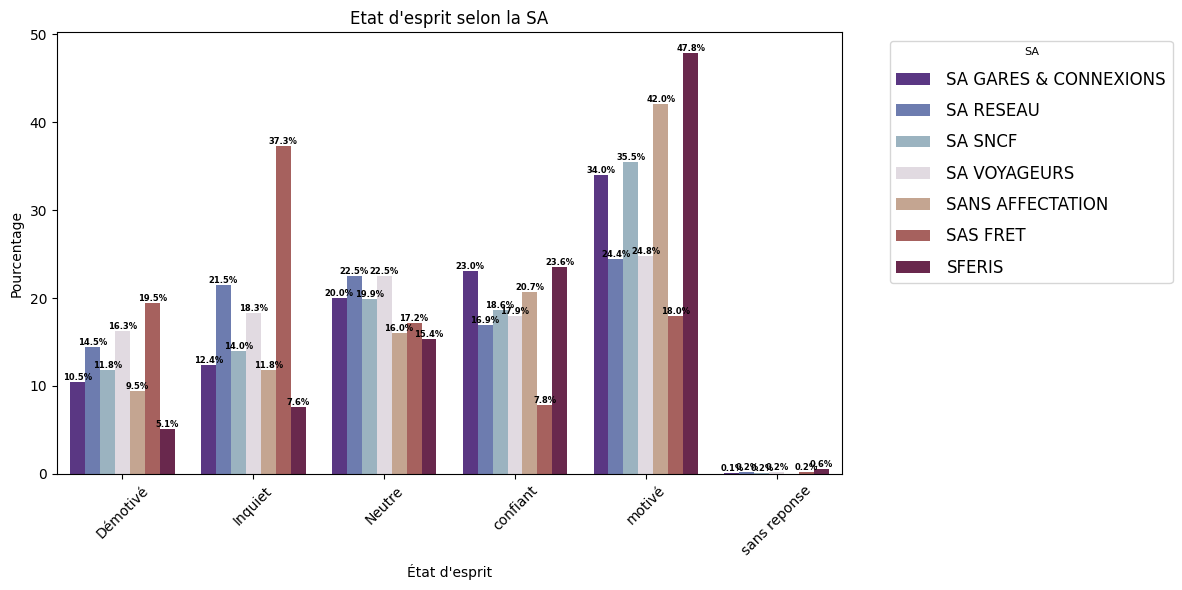

,ID BDD,ANNEE,SEXE,CLASSE,SNCF_Group,Niveau SA,Niveau 3,etat_desprit,aimer_travailler_pour_SNCF,etre_fier_de_travailler_pour_SNCF,...,satisfaction_soutient_descollegues_bis,satisfaction_soutient_mon_manage_bis,satisfaction_acces_informations_metiers_bis,satisfaction_temps_bis,benefier_informations_necessaires_montravail_bis,QVT_somme,QVT_indicateur,QVT_indicateur_bis,classe_QVT,SEXE_label
0,1,2023,1,4,1,5.0,32.0,Inquiet,3,3,...,0,0,0,0,0,0,0,0.000000,NaN,homme
1,2,2023,1,2,1,5.0,34.0,motivé,1,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme
2,3,2023,1,4,1,5.0,32.0,Neutre,2,3,...,1,1,1,0,1,7,1,0.583333,Qualité de vie moyenne,homme
3,4,2023,1,5,1,5.0,34.0,Neutre,2,2,...,1,1,1,1,1,11,1,0.916667,Qualité de vie élevée,homme
4,5,2023,1,2,1,5.0,32.0,motivé,1,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99118,99119,2023,1,15,1,2.0,1.0,motivé,1,1,...,1,1,0,1,0,6,1,0.500000,Qualité de vie faible,homme
99119,99120,2023,1,6,1,3.0,36.0,Inquiet,1,1,...,1,1,1,0,1,8,1,0.666667,Qualité de vie moyenne,homme
99120,99121,2023,2,5,1,5.0,34.0,Neutre,2,2,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme
99121,99122,2023,2,1,1,4.0,24.0,Neutre,2,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme


In [ ]:
##Etat d'esprit selon la SA

label_SA = {1:'SAS FRET',2:'SA GARES & CONNEXIONS',3:'SA RESEAU',4: 'SA SNCF',5: 'SA VOYAGEURS',6:'SFERIS',8:'SANS AFFECTATION'}

labels_mapping = {
    1: 'motivé',
    2: 'confiant',
    3: 'Neutre',
    4: 'Inquiet',
    5: 'Démotivé',
    6: 'sans reponse'
}

# Appliquer les mappings

Base_2023_renamed['Niveau_SA_label'] = Base_2023_renamed['Niveau SA'].map(label_SA)
#Base_2023_renamed['etat_desprit'] = Base_2023_renamed['etat_desprit'].map(labels_mapping)

# Calculer les pourcentages

percentage_df_SA = (
    Base_2023_renamed.groupby(['etat_desprit', 'Niveau_SA_label'])
    .size()
    .reset_index(name='count')
    .groupby('Niveau_SA_label')
    .apply(lambda x: x.assign(percentage_sa=100 * x['count'] / x['count'].sum()))
    .reset_index(drop=True)
)

# Vérifiez les pourcentages calculés

print(percentage_df_SA)

# Définir une palette de couleurs
palette = sns.color_palette('twilight_shifted', n_colors=7)

# Tracer le graphique
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=percentage_df_SA, x='etat_desprit', y='percentage_sa', hue='Niveau_SA_label', palette=palette)

# Ajustements esthétiques
plt.title("Etat d'esprit selon la SA")
plt.xlabel('État d\'esprit')
plt.ylabel('Pourcentage')

plt.xticks(rotation=45)

legend_labels = label_SA
legend_colors = palette

#legend_patches = [Patch(color=legend_colors[i], label=legend_labels[i], edgecolor='black', linewidth=1.5) for i in range(len(legend_labels))]
plt.legend(title='SA', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large', title_fontsize='8', labelspacing=0.8, handletextpad=1)

# Annoter les barres avec les pourcentages
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=6,fontweight='bold')

# Ajustement de la mise en page
plt.tight_layout()

# Affichage
plt.show()

Base_2023_renamed.drop(columns='Niveau_SA_label')


In [ ]:
print(Base_2023_renamed['engagement_indicateur'].value_counts())

engagement_indicateur
1    68505
0    30618
Name: count, dtype: int64


  engagement_indicateur SEXE_label  count  percentage_engag
0                engagé      autre    812         88.743169
1            non engagé      autre    103         11.256831
2                engagé      femme  16090         70.868569
3            non engagé      femme   6614         29.131431
4                engagé      homme  51603         68.344723


<ipython-input-56-ad6a73d39004>:31: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  bar_plot = sns.barplot(data=percentage_df_enga, x='engagement_indicateur', y='percentage_engag', hue='SEXE_label', palette=palette)


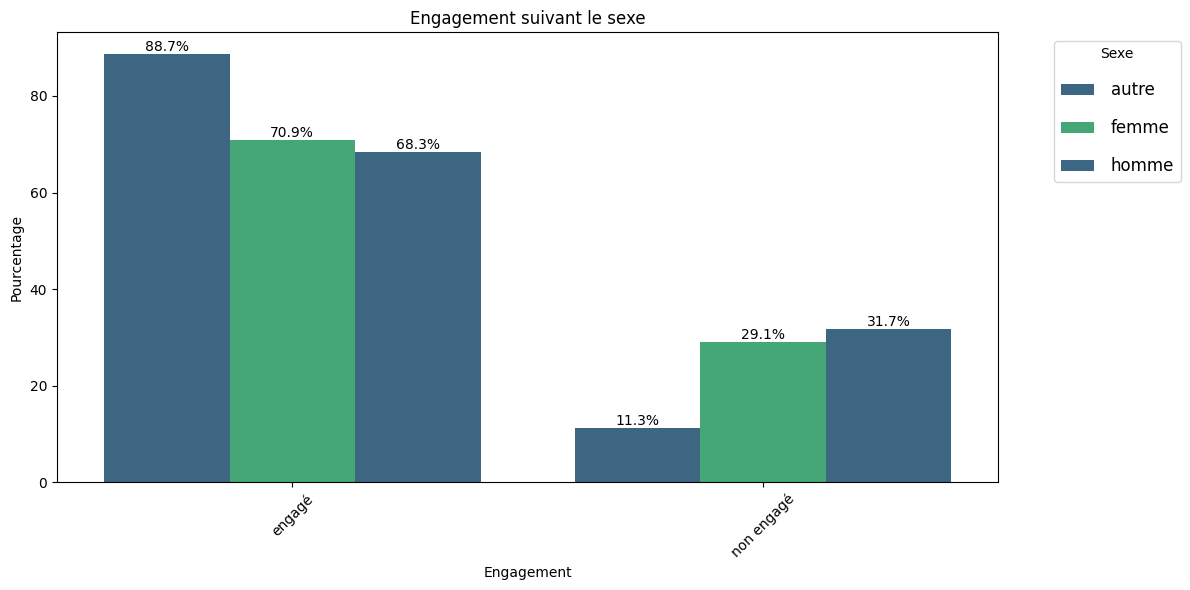

,ID BDD,ANNEE,SEXE,CLASSE,SNCF_Group,Niveau SA,Niveau 3,etat_desprit,aimer_travailler_pour_SNCF,etre_fier_de_travailler_pour_SNCF,...,satisfaction_soutient_descollegues_bis,satisfaction_soutient_mon_manage_bis,satisfaction_acces_informations_metiers_bis,satisfaction_temps_bis,benefier_informations_necessaires_montravail_bis,QVT_somme,QVT_indicateur,QVT_indicateur_bis,classe_QVT,Niveau_SA_label
0,1,2023,1,4,1,5.0,32.0,Inquiet,3,3,...,0,0,0,0,0,0,0,0.000000,NaN,SA VOYAGEURS
1,2,2023,1,2,1,5.0,34.0,motivé,1,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,SA VOYAGEURS
2,3,2023,1,4,1,5.0,32.0,Neutre,2,3,...,1,1,1,0,1,7,1,0.583333,Qualité de vie moyenne,SA VOYAGEURS
3,4,2023,1,5,1,5.0,34.0,Neutre,2,2,...,1,1,1,1,1,11,1,0.916667,Qualité de vie élevée,SA VOYAGEURS
4,5,2023,1,2,1,5.0,32.0,motivé,1,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,SA VOYAGEURS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99118,99119,2023,1,15,1,2.0,1.0,motivé,1,1,...,1,1,0,1,0,6,1,0.500000,Qualité de vie faible,SA GARES & CONNEXIONS
99119,99120,2023,1,6,1,3.0,36.0,Inquiet,1,1,...,1,1,1,0,1,8,1,0.666667,Qualité de vie moyenne,SA RESEAU
99120,99121,2023,2,5,1,5.0,34.0,Neutre,2,2,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,SA VOYAGEURS
99121,99122,2023,2,1,1,4.0,24.0,Neutre,2,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,SA SNCF


In [ ]:
##Engagement selon le sexe

label_sex = {1: 'homme', 2: 'femme', 3: 'autre'}
labels_mapping_engage = {
    1: 'engagé',
    0: 'non engagé'
}

# Appliquer les mappings
Base_2023_renamed['SEXE_label'] = Base_2023_renamed['SEXE'].map(label_sex)
Base_2023_renamed['engagement_indicateur'] = Base_2023_renamed['engagement_indicateur'].map(labels_mapping_engage)

# Calculer les pourcentages
percentage_df_enga= (
    Base_2023_renamed.groupby(['engagement_indicateur', 'SEXE_label'])
    .size()
    .reset_index(name='count')
    .groupby('SEXE_label')
    .apply(lambda x: x.assign(percentage_engag=100 * x['count'] / x['count'].sum()))
    .reset_index(drop=True)
)

# Vérifiez les pourcentages calculés
print(percentage_df_enga.head())

# Définir une palette de couleurs
palette = sns.color_palette('viridis', n_colors=2)

# Tracer le graphique
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=percentage_df_enga, x='engagement_indicateur', y='percentage_engag', hue='SEXE_label', palette=palette)

# Ajustements esthétiques
plt.title("Engagement suivant le sexe")
plt.xlabel('Engagement')
plt.ylabel('Pourcentage')

# Configurer les étiquettes des abscisses
plt.xticks(rotation=45)

# Créer une légende manuelle
#legend_labels = label_sex
#legend_colors = palette


# Ajouter la légende au graphique
plt.legend(title='Sexe', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large', title_fontsize='10', labelspacing=1.2, handletextpad=1)

# Annoter les barres avec les pourcentages
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=10)

# Ajustement de la mise en page
plt.tight_layout()

# Affichage
plt.show()

Base_2023_renamed.drop(columns='SEXE_label')


In [ ]:
print(Base_2023_renamed['engagement_indicateur'].value_counts())

engagement_indicateur
engagé        68505
non engagé    30618
Name: count, dtype: int64


  engagement_indicateur SEXE_label  count  percentage_engage
0                engagé      autre    812           1.185315
1                engagé      femme  16090          23.487337
2                engagé      homme  51603          75.327348
3            non engagé      autre    103           0.336403
4            non engagé      femme   6614          21.601672


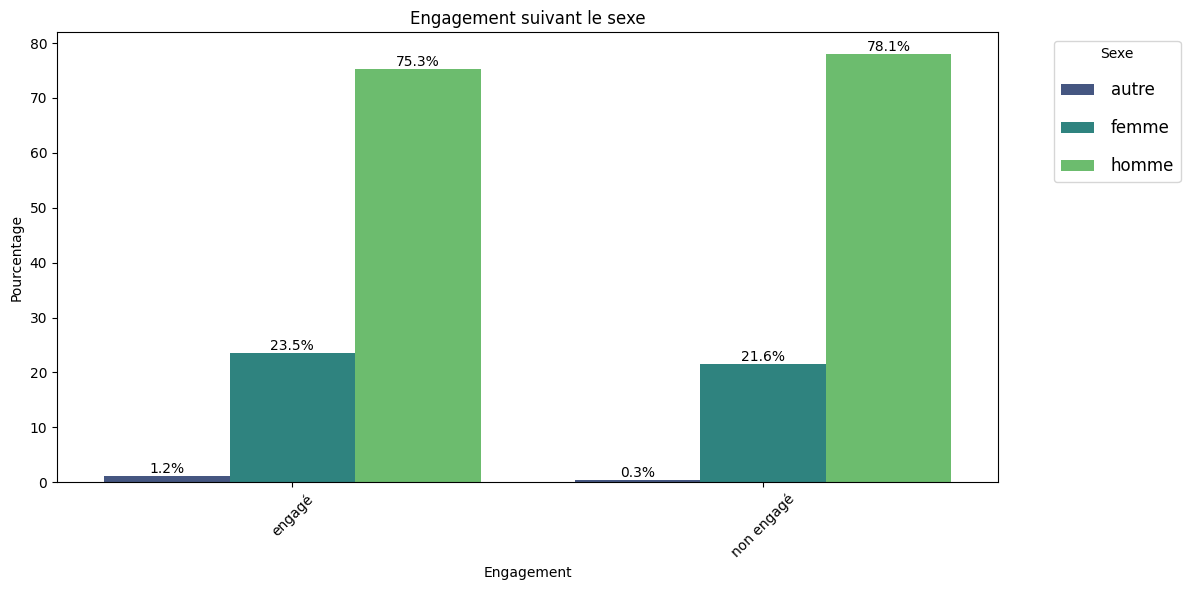

,ID BDD,ANNEE,SEXE,CLASSE,SNCF_Group,Niveau SA,Niveau 3,etat_desprit,aimer_travailler_pour_SNCF,etre_fier_de_travailler_pour_SNCF,...,satisfaction_soutient_descollegues_bis,satisfaction_soutient_mon_manage_bis,satisfaction_acces_informations_metiers_bis,satisfaction_temps_bis,benefier_informations_necessaires_montravail_bis,QVT_somme,QVT_indicateur,QVT_indicateur_bis,classe_QVT,Niveau_SA_label
0,1,2023,1,4,1,5.0,32.0,Inquiet,3,3,...,0,0,0,0,0,0,0,0.000000,NaN,SA VOYAGEURS
1,2,2023,1,2,1,5.0,34.0,motivé,1,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,SA VOYAGEURS
2,3,2023,1,4,1,5.0,32.0,Neutre,2,3,...,1,1,1,0,1,7,1,0.583333,Qualité de vie moyenne,SA VOYAGEURS
3,4,2023,1,5,1,5.0,34.0,Neutre,2,2,...,1,1,1,1,1,11,1,0.916667,Qualité de vie élevée,SA VOYAGEURS
4,5,2023,1,2,1,5.0,32.0,motivé,1,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,SA VOYAGEURS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99118,99119,2023,1,15,1,2.0,1.0,motivé,1,1,...,1,1,0,1,0,6,1,0.500000,Qualité de vie faible,SA GARES & CONNEXIONS
99119,99120,2023,1,6,1,3.0,36.0,Inquiet,1,1,...,1,1,1,0,1,8,1,0.666667,Qualité de vie moyenne,SA RESEAU
99120,99121,2023,2,5,1,5.0,34.0,Neutre,2,2,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,SA VOYAGEURS
99121,99122,2023,2,1,1,4.0,24.0,Neutre,2,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,SA SNCF


In [ ]:
##Engagement selon le sexe

label_sex = {1: 'homme', 2: 'femme', 3: 'autre'}
labels_mapping_engage = {
    1: 'engagé',
    0: 'non engagé'
}

# Appliquer les mappings

Base_2023_renamed['SEXE_label'] = Base_2023_renamed['SEXE'].map(label_sex)
#Base_2023_renamed['engagement_indicateur'] = Base_2023_renamed['engagement_indicateur'].map(labels_mapping_engage)

# Calculer les pourcentages

percentage_df_enga= (
    Base_2023_renamed.groupby(['engagement_indicateur', 'SEXE_label'])
    .size()
    .reset_index(name='count')
    .groupby('engagement_indicateur')
    .apply(lambda x: x.assign(percentage_engage=100 * x['count'] / x['count'].sum()))
    .reset_index(drop=True)
)

# Vérifiez les pourcentages calculés
print(percentage_df_enga.head())

# Définir une palette de couleurs
palette = sns.color_palette('viridis', n_colors=3)

# Tracer le graphique
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=percentage_df_enga, x='engagement_indicateur', y='percentage_engage', hue='SEXE_label', palette=palette)

# Ajustements esthétiques
plt.title("Engagement suivant le sexe")
plt.xlabel('Engagement')
plt.ylabel('Pourcentage')

# Configurer les étiquettes des abscisses
plt.xticks(rotation=45)

# Créer une légende manuelle
#legend_labels = label_sex
#legend_colors = palette
# Ajouter la légende au graphique
plt.legend(title='Sexe', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large', title_fontsize='10', labelspacing=1.2, handletextpad=1)

# Annoter les barres avec les pourcentages
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=10)

# Ajustement de la mise en page
plt.tight_layout()

# Affichage
plt.show()

Base_2023_renamed.drop(columns='SEXE_label')


In [ ]:
print(Base_2023_renamed['SEXE'].value_counts())

SEXE
1    75504
2    22704
3      915
Name: count, dtype: int64


    classe_engagement SEXE_label  count  percentage_engag
0   faiblement engagé      autre     68          7.727273
1  moyennement engagé      autre    250         28.409091
2    fortement engagé      autre    562         63.863636
3   faiblement engagé      femme   4266         20.956966
4  moyennement engagé      femme   7769         38.165651


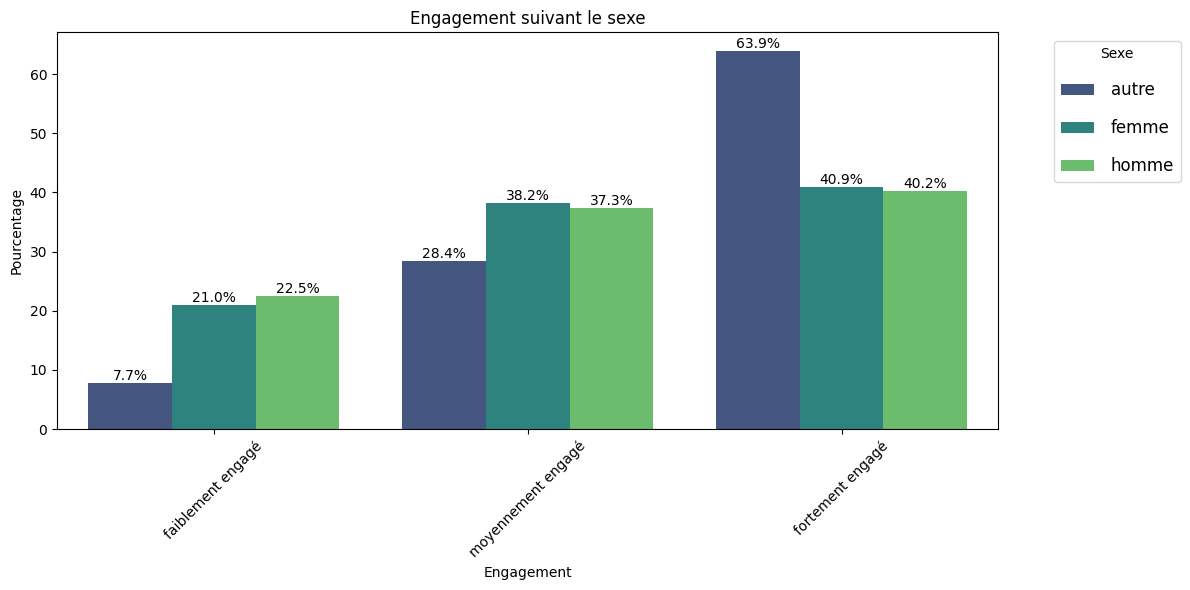

,ID BDD,ANNEE,SEXE,CLASSE,SNCF_Group,Niveau SA,Niveau 3,etat_desprit,aimer_travailler_pour_SNCF,etre_fier_de_travailler_pour_SNCF,...,satisfaction_soutient_descollegues_bis,satisfaction_soutient_mon_manage_bis,satisfaction_acces_informations_metiers_bis,satisfaction_temps_bis,benefier_informations_necessaires_montravail_bis,QVT_somme,QVT_indicateur,QVT_indicateur_bis,classe_QVT,Niveau_SA_label
0,1,2023,1,4,1,5.0,32.0,Inquiet,3,3,...,0,0,0,0,0,0,0,0.000000,NaN,SA VOYAGEURS
1,2,2023,1,2,1,5.0,34.0,motivé,1,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,SA VOYAGEURS
2,3,2023,1,4,1,5.0,32.0,Neutre,2,3,...,1,1,1,0,1,7,1,0.583333,Qualité de vie moyenne,SA VOYAGEURS
3,4,2023,1,5,1,5.0,34.0,Neutre,2,2,...,1,1,1,1,1,11,1,0.916667,Qualité de vie élevée,SA VOYAGEURS
4,5,2023,1,2,1,5.0,32.0,motivé,1,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,SA VOYAGEURS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99118,99119,2023,1,15,1,2.0,1.0,motivé,1,1,...,1,1,0,1,0,6,1,0.500000,Qualité de vie faible,SA GARES & CONNEXIONS
99119,99120,2023,1,6,1,3.0,36.0,Inquiet,1,1,...,1,1,1,0,1,8,1,0.666667,Qualité de vie moyenne,SA RESEAU
99120,99121,2023,2,5,1,5.0,34.0,Neutre,2,2,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,SA VOYAGEURS
99121,99122,2023,2,1,1,4.0,24.0,Neutre,2,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,SA SNCF


In [ ]:
##classe d'negagement selon le sexe

label_sex = {1: 'homme', 2: 'femme', 3: 'autre'}

labels_mapping_engage = {
    1: 'engagé',
    0: 'non engagé'
}

# Appliquer les mappings
Base_2023_renamed['SEXE_label'] = Base_2023_renamed['SEXE'].map(label_sex)
#Base_2023_renamed['engagement_indicateur'] = Base_2023_renamed['engagement_indicateur'].map(labels_mapping_engage)

# Calculer les pourcentages
percentage_df_enga= (
    Base_2023_renamed.groupby(['classe_engagement', 'SEXE_label'])
    .size()
    .reset_index(name='count')
    .groupby('SEXE_label')
    .apply(lambda x: x.assign(percentage_engag=100 * x['count'] / x['count'].sum()))
    .reset_index(drop=True)
)

# Vérifiez les pourcentages calculés
print(percentage_df_enga.head())

# Définir une palette de couleurs
palette = sns.color_palette('viridis', n_colors=3)

# Tracer le graphique
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=percentage_df_enga, x='classe_engagement', y='percentage_engag', hue='SEXE_label', palette=palette)

# Ajustements esthétiques
plt.title("Engagement suivant le sexe")
plt.xlabel('Engagement')
plt.ylabel('Pourcentage')

# Configurer les étiquettes des abscisses
plt.xticks(rotation=45)

# Créer une légende manuelle
#legend_labels = label_sex
#legend_colors = palette


# Ajouter la légende au graphique
plt.legend(title='Sexe', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large', title_fontsize='10', labelspacing=1.2, handletextpad=1)

# Annoter les barres avec les pourcentages
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=10)

# Ajustement de la mise en page
plt.tight_layout()

# Affichage

plt.show()

Base_2023_renamed.drop(columns='SEXE_label')


    classe_engagement SEXE_label  count  percentage_engag
0   faiblement engagé      autre     68          0.351858
1   faiblement engagé      femme   4266         22.073890
2   faiblement engagé      homme  14992         77.574252
3  moyennement engagé      autre    250          0.760433
4  moyennement engagé      femme   7769         23.631220


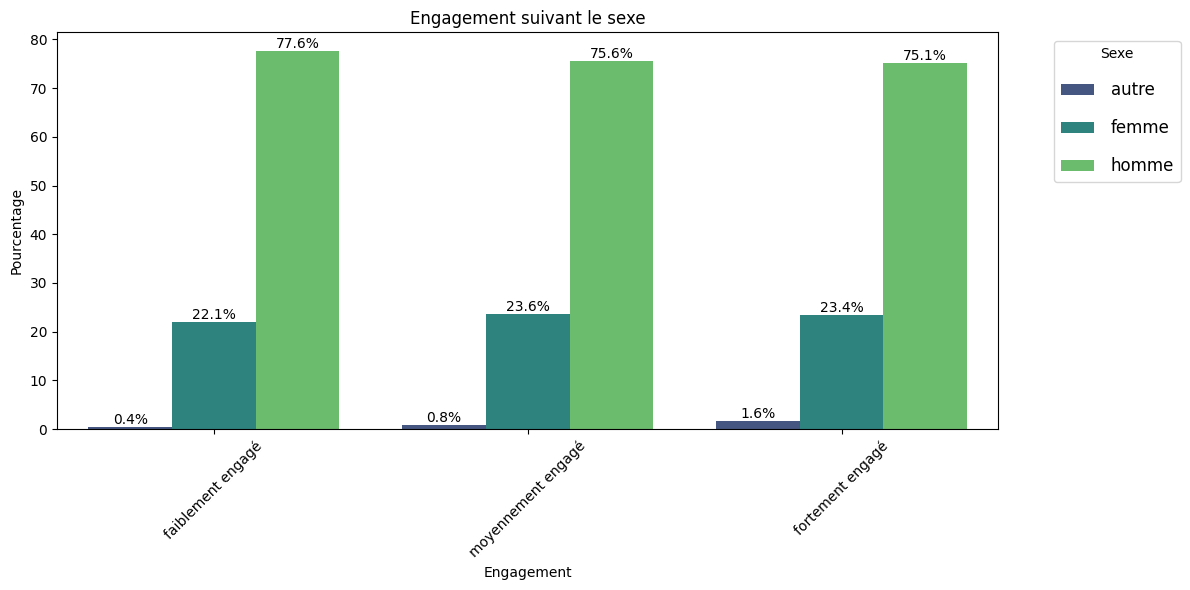

,ID BDD,ANNEE,SEXE,CLASSE,SNCF_Group,Niveau SA,Niveau 3,etat_desprit,aimer_travailler_pour_SNCF,etre_fier_de_travailler_pour_SNCF,...,satisfaction_soutient_descollegues_bis,satisfaction_soutient_mon_manage_bis,satisfaction_acces_informations_metiers_bis,satisfaction_temps_bis,benefier_informations_necessaires_montravail_bis,QVT_somme,QVT_indicateur,QVT_indicateur_bis,classe_QVT,Niveau_SA_label
0,1,2023,1,4,1,5.0,32.0,Inquiet,3,3,...,0,0,0,0,0,0,0,0.000000,NaN,SA VOYAGEURS
1,2,2023,1,2,1,5.0,34.0,motivé,1,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,SA VOYAGEURS
2,3,2023,1,4,1,5.0,32.0,Neutre,2,3,...,1,1,1,0,1,7,1,0.583333,Qualité de vie moyenne,SA VOYAGEURS
3,4,2023,1,5,1,5.0,34.0,Neutre,2,2,...,1,1,1,1,1,11,1,0.916667,Qualité de vie élevée,SA VOYAGEURS
4,5,2023,1,2,1,5.0,32.0,motivé,1,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,SA VOYAGEURS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99118,99119,2023,1,15,1,2.0,1.0,motivé,1,1,...,1,1,0,1,0,6,1,0.500000,Qualité de vie faible,SA GARES & CONNEXIONS
99119,99120,2023,1,6,1,3.0,36.0,Inquiet,1,1,...,1,1,1,0,1,8,1,0.666667,Qualité de vie moyenne,SA RESEAU
99120,99121,2023,2,5,1,5.0,34.0,Neutre,2,2,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,SA VOYAGEURS
99121,99122,2023,2,1,1,4.0,24.0,Neutre,2,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,SA SNCF


In [ ]:
##classe d'negagement selon le sexe

label_sex = {1: 'homme', 2: 'femme', 3: 'autre'}

labels_mapping_engage = {
    1: 'engagé',
    0: 'non engagé'
}

# Appliquer les mappings
Base_2023_renamed['SEXE_label'] = Base_2023_renamed['SEXE'].map(label_sex)
#Base_2023_renamed['engagement_indicateur'] = Base_2023_renamed['engagement_indicateur'].map(labels_mapping_engage)

# Calculer les pourcentages
percentage_df_enga= (
    Base_2023_renamed.groupby(['classe_engagement', 'SEXE_label'])
    .size()
    .reset_index(name='count')
    .groupby('classe_engagement')
    .apply(lambda x: x.assign(percentage_engag=100 * x['count'] / x['count'].sum()))
    .reset_index(drop=True)
)

# Vérifiez les pourcentages calculés
print(percentage_df_enga.head())

# Définir une palette de couleurs
palette = sns.color_palette('viridis', n_colors=3)

# Tracer le graphique
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=percentage_df_enga, x='classe_engagement', y='percentage_engag', hue='SEXE_label', palette=palette)

# Ajustements esthétiques
plt.title("Engagement suivant le sexe")
plt.xlabel('Engagement')
plt.ylabel('Pourcentage')

# Configurer les étiquettes des abscisses
plt.xticks(rotation=45)

# Créer une légende manuelle
#legend_labels = label_sex
#legend_colors = palette


# Ajouter la légende au graphique
plt.legend(title='Sexe', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large', title_fontsize='10', labelspacing=1.2, handletextpad=1)

# Annoter les barres avec les pourcentages
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=10)

# Ajustement de la mise en page
plt.tight_layout()

# Affichage
plt.show()

Base_2023_renamed.drop(columns='SEXE_label')


In [ ]:
##Taux d'engagement moyen par sexe
label_sex = {1: 'homme', 2: 'femme', 3: 'autre'}

Base_2023_renamed['SEXE_label'] = Base_2023_renamed['SEXE'].map(label_sex)

# Calculer les pourcentages
percentage_df_enga= (
    Base_2023_renamed.groupby(['SEXE_label'])
    .mean('engagement_bis'))

# Vérifiez les pourcentages calculés
print(percentage_df_enga['engagement_bis'].head())

SEXE_label
autre    0.836940
femme    0.668666
homme    0.649335
Name: engagement_bis, dtype: float64


In [ ]:
print(Base_2023_renamed['Niveau SA'].value_counts())

Niveau SA
5.0    45571
3.0    38380
4.0     6871
2.0     4199
1.0     3190
6.0      709
8.0      169
Name: count, dtype: int64


  engagement_indicateur        Niveau_SA_label  count  percentage_sa
0                engagé  SA GARES & CONNEXIONS   3248       4.743198
1                engagé              SA RESEAU  26957      39.366503
2                engagé                SA SNCF   5274       7.701856
3                engagé           SA VOYAGEURS  30226      44.140368
4                engagé       SANS AFFECTATION    127       0.185464


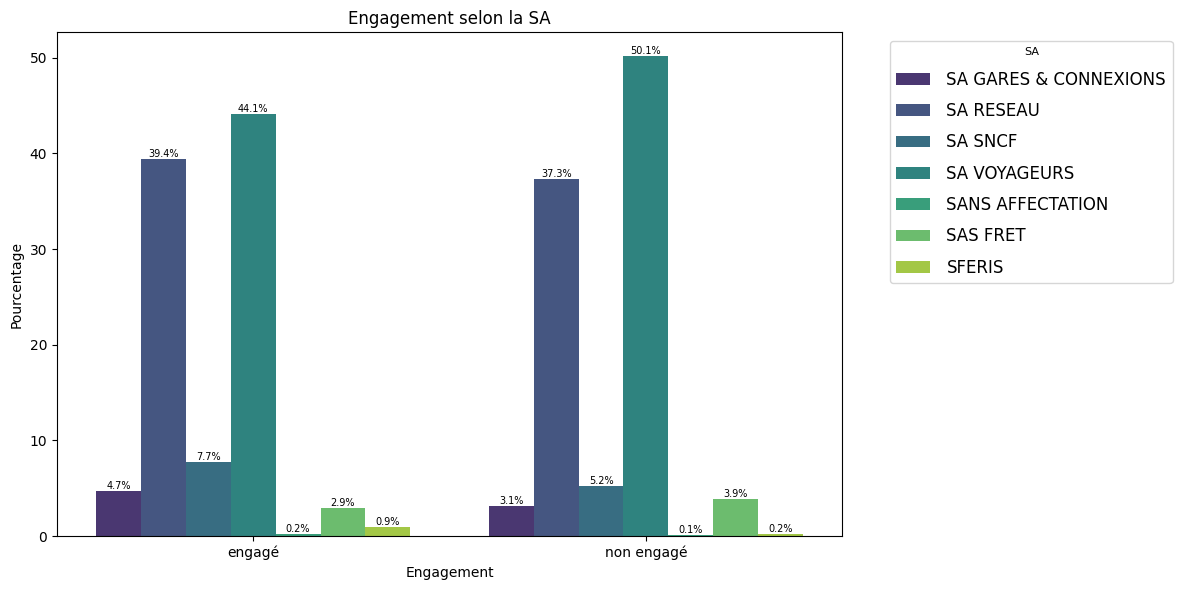

,ID BDD,ANNEE,SEXE,CLASSE,SNCF_Group,Niveau SA,Niveau 3,etat_desprit,aimer_travailler_pour_SNCF,etre_fier_de_travailler_pour_SNCF,...,satisfaction_soutient_descollegues_bis,satisfaction_soutient_mon_manage_bis,satisfaction_acces_informations_metiers_bis,satisfaction_temps_bis,benefier_informations_necessaires_montravail_bis,QVT_somme,QVT_indicateur,QVT_indicateur_bis,classe_QVT,SEXE_label
0,1,2023,1,4,1,5.0,32.0,Inquiet,3,3,...,0,0,0,0,0,0,0,0.000000,NaN,homme
1,2,2023,1,2,1,5.0,34.0,motivé,1,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme
2,3,2023,1,4,1,5.0,32.0,Neutre,2,3,...,1,1,1,0,1,7,1,0.583333,Qualité de vie moyenne,homme
3,4,2023,1,5,1,5.0,34.0,Neutre,2,2,...,1,1,1,1,1,11,1,0.916667,Qualité de vie élevée,homme
4,5,2023,1,2,1,5.0,32.0,motivé,1,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99118,99119,2023,1,15,1,2.0,1.0,motivé,1,1,...,1,1,0,1,0,6,1,0.500000,Qualité de vie faible,homme
99119,99120,2023,1,6,1,3.0,36.0,Inquiet,1,1,...,1,1,1,0,1,8,1,0.666667,Qualité de vie moyenne,homme
99120,99121,2023,2,5,1,5.0,34.0,Neutre,2,2,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme
99121,99122,2023,2,1,1,4.0,24.0,Neutre,2,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme


In [ ]:
##Engagement suivant la SA

label_SA = {1:'SAS FRET',2:'SA GARES & CONNEXIONS',3:'SA RESEAU',4: 'SA SNCF',5: 'SA VOYAGEURS',6:'SFERIS',8:'SANS AFFECTATION'}

# Appliquer les mappings

Base_2023_renamed['Niveau_SA_label'] = Base_2023_renamed['Niveau SA'].map(label_SA)

#Base_2023_renamed['etat_desprit'] = Base_2023_renamed['etat_desprit'].map(labels_mapping)

# Calculer les pourcentages

percentage_df_SA = (
    Base_2023_renamed.groupby(['engagement_indicateur', 'Niveau_SA_label'])
    .size()
    .reset_index(name='count')
    .groupby('engagement_indicateur')
    .apply(lambda x: x.assign(percentage_sa=100 * x['count'] / x['count'].sum()))
    .reset_index(drop=True)
)

# Vérifiez les pourcentages calculés
print(percentage_df_SA.head())

# Définir une palette de couleurs
palette = sns.color_palette('viridis', n_colors=7)

# Tracer le graphique
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=percentage_df_SA, x='engagement_indicateur', y='percentage_sa', hue='Niveau_SA_label', palette=palette)

# Ajustements esthétiques
plt.title("Engagement selon la SA")
plt.xlabel('Engagement')
plt.ylabel('Pourcentage')

plt.xticks(rotation=0)

#legend_patches = [Patch(color=legend_colors[i], label=legend_labels[i], edgecolor='black', linewidth=1.5) for i in range(len(legend_labels))]
plt.legend(title='SA', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large', title_fontsize='8', labelspacing=0.8, handletextpad=1)

# Annoter les barres avec les pourcentages
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=7)

# Ajustement de la mise en page
plt.tight_layout()

# Affichage
plt.show()

Base_2023_renamed.drop(columns='Niveau_SA_label')

  engagement_indicateur        Niveau_SA_label  count  percentage_sa
0                engagé  SA GARES & CONNEXIONS   3248      77.351750
1            non engagé  SA GARES & CONNEXIONS    951      22.648250
2                engagé              SA RESEAU  26957      70.237103
3            non engagé              SA RESEAU  11423      29.762897
4                engagé                SA SNCF   5274      76.757386


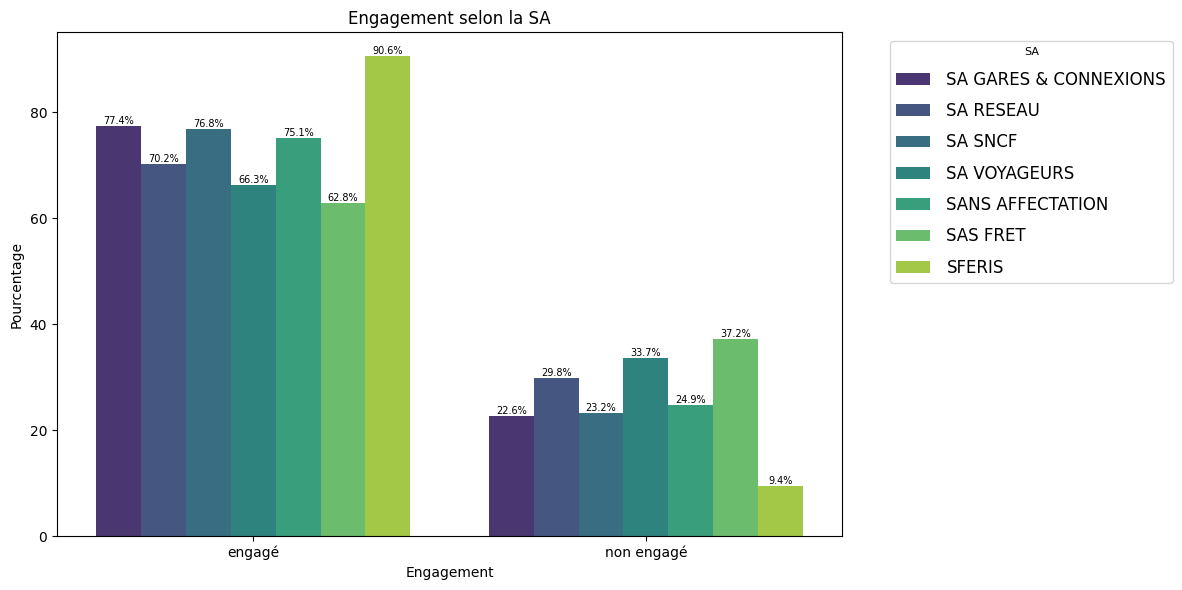

,ID BDD,ANNEE,SEXE,CLASSE,SNCF_Group,Niveau SA,Niveau 3,etat_desprit,aimer_travailler_pour_SNCF,etre_fier_de_travailler_pour_SNCF,...,satisfaction_soutient_descollegues_bis,satisfaction_soutient_mon_manage_bis,satisfaction_acces_informations_metiers_bis,satisfaction_temps_bis,benefier_informations_necessaires_montravail_bis,QVT_somme,QVT_indicateur,QVT_indicateur_bis,classe_QVT,SEXE_label
0,1,2023,1,4,1,5.0,32.0,Inquiet,3,3,...,0,0,0,0,0,0,0,0.000000,NaN,homme
1,2,2023,1,2,1,5.0,34.0,motivé,1,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme
2,3,2023,1,4,1,5.0,32.0,Neutre,2,3,...,1,1,1,0,1,7,1,0.583333,Qualité de vie moyenne,homme
3,4,2023,1,5,1,5.0,34.0,Neutre,2,2,...,1,1,1,1,1,11,1,0.916667,Qualité de vie élevée,homme
4,5,2023,1,2,1,5.0,32.0,motivé,1,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99118,99119,2023,1,15,1,2.0,1.0,motivé,1,1,...,1,1,0,1,0,6,1,0.500000,Qualité de vie faible,homme
99119,99120,2023,1,6,1,3.0,36.0,Inquiet,1,1,...,1,1,1,0,1,8,1,0.666667,Qualité de vie moyenne,homme
99120,99121,2023,2,5,1,5.0,34.0,Neutre,2,2,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme
99121,99122,2023,2,1,1,4.0,24.0,Neutre,2,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme


In [ ]:
##Engagement suivant la SA

label_SA = {1:'SAS FRET',2:'SA GARES & CONNEXIONS',3:'SA RESEAU',4: 'SA SNCF',5: 'SA VOYAGEURS',6:'SFERIS',8:'SANS AFFECTATION'}

# Appliquer les mappings

#Base_2023_renamed['Niveau_SA_label'] = Base_2023_renamed['Niveau SA'].map(label_SA)

#Base_2023_renamed['etat_desprit'] = Base_2023_renamed['etat_desprit'].map(labels_mapping)

# Calculer les pourcentages

percentage_df_SA = (
    Base_2023_renamed.groupby(['engagement_indicateur', 'Niveau_SA_label'])
    .size()
    .reset_index(name='count')
    .groupby('Niveau_SA_label')
    .apply(lambda x: x.assign(percentage_sa=100 * x['count'] / x['count'].sum()))
    .reset_index(drop=True)
)

# Vérifiez les pourcentages calculés
print(percentage_df_SA.head())

# Définir une palette de couleurs
palette = sns.color_palette('viridis', n_colors=7)

# Tracer le graphique
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=percentage_df_SA, x='engagement_indicateur', y='percentage_sa', hue='Niveau_SA_label', palette=palette)

# Ajustements esthétiques
plt.title("Engagement selon la SA")
plt.xlabel('Engagement')
plt.ylabel('Pourcentage')

plt.xticks(rotation=0)

#legend_patches = [Patch(color=legend_colors[i], label=legend_labels[i], edgecolor='black', linewidth=1.5) for i in range(len(legend_labels))]
plt.legend(title='SA', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large', title_fontsize='8', labelspacing=0.8, handletextpad=1)

# Annoter les barres avec les pourcentages
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=7)

# Ajustement de la mise en page
plt.tight_layout()

# Affichage
plt.show()

Base_2023_renamed.drop(columns='Niveau_SA_label')

    classe_engagement        Niveau_SA_label  count  percentage_sa
0   faiblement engagé  SA GARES & CONNEXIONS    635      16.353335
1  moyennement engagé  SA GARES & CONNEXIONS   1386      35.694051
2    fortement engagé  SA GARES & CONNEXIONS   1862      47.952614
3   faiblement engagé              SA RESEAU   7873      22.604077
4  moyennement engagé              SA RESEAU  13363      38.366351


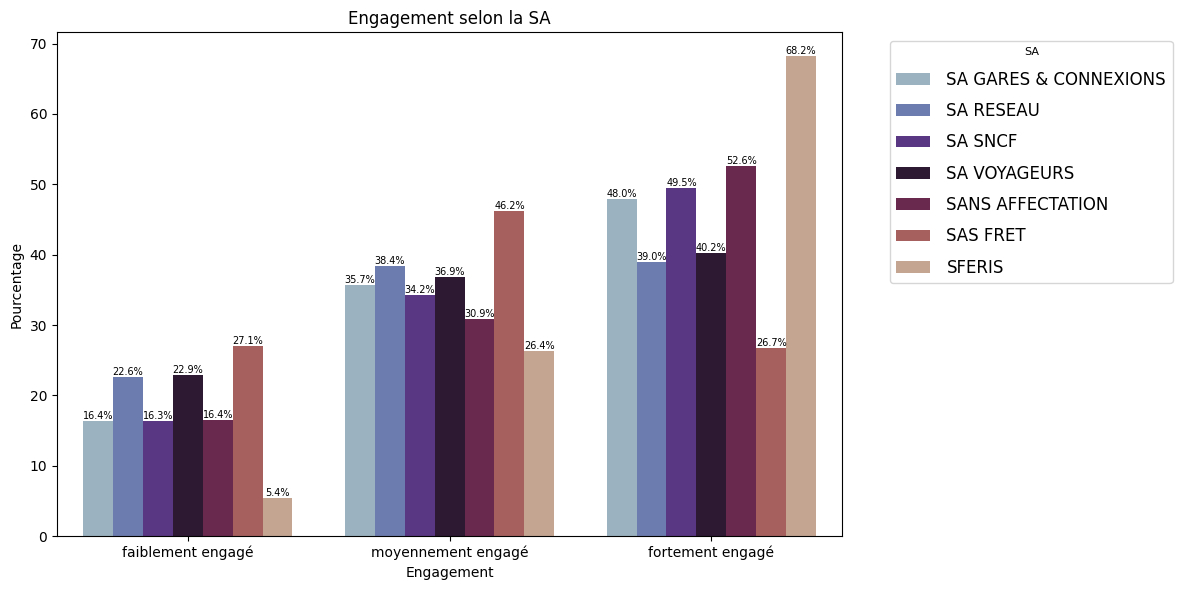

,ID BDD,ANNEE,SEXE,CLASSE,SNCF_Group,Niveau SA,Niveau 3,etat_desprit,aimer_travailler_pour_SNCF,etre_fier_de_travailler_pour_SNCF,...,satisfaction_soutient_descollegues_bis,satisfaction_soutient_mon_manage_bis,satisfaction_acces_informations_metiers_bis,satisfaction_temps_bis,benefier_informations_necessaires_montravail_bis,QVT_somme,QVT_indicateur,QVT_indicateur_bis,classe_QVT,SEXE_label
0,1,2023,1,4,1,5.0,32.0,Inquiet,3,3,...,0,0,0,0,0,0,0,0.000000,NaN,homme
1,2,2023,1,2,1,5.0,34.0,motivé,1,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme
2,3,2023,1,4,1,5.0,32.0,Neutre,2,3,...,1,1,1,0,1,7,1,0.583333,Qualité de vie moyenne,homme
3,4,2023,1,5,1,5.0,34.0,Neutre,2,2,...,1,1,1,1,1,11,1,0.916667,Qualité de vie élevée,homme
4,5,2023,1,2,1,5.0,32.0,motivé,1,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99118,99119,2023,1,15,1,2.0,1.0,motivé,1,1,...,1,1,0,1,0,6,1,0.500000,Qualité de vie faible,homme
99119,99120,2023,1,6,1,3.0,36.0,Inquiet,1,1,...,1,1,1,0,1,8,1,0.666667,Qualité de vie moyenne,homme
99120,99121,2023,2,5,1,5.0,34.0,Neutre,2,2,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme
99121,99122,2023,2,1,1,4.0,24.0,Neutre,2,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme


In [ ]:
###classe d'engagement selon la SA

##Engagement suivant la SA

label_SA = {1:'SAS FRET',2:'SA GARES & CONNEXIONS',3:'SA RESEAU',4: 'SA SNCF',5: 'SA VOYAGEURS',6:'SFERIS',8:'SANS AFFECTATION'}

# Appliquer les mappings

#Base_2023_renamed['Niveau_SA_label'] = Base_2023_renamed['Niveau SA'].map(label_SA)

#Base_2023_renamed['etat_desprit'] = Base_2023_renamed['etat_desprit'].map(labels_mapping)

# Calculer les pourcentages

percentage_df_SA = (
    Base_2023_renamed.groupby(['classe_engagement', 'Niveau_SA_label'])
    .size()
    .reset_index(name='count')
    .groupby('Niveau_SA_label')
    .apply(lambda x: x.assign(percentage_sa=100 * x['count'] / x['count'].sum()))
    .reset_index(drop=True)
)

# Vérifiez les pourcentages calculés
print(percentage_df_SA.head())

# Définir une palette de couleurs
palette = sns.color_palette('twilight', n_colors=7)

# Tracer le graphique
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=percentage_df_SA, x='classe_engagement', y='percentage_sa', hue='Niveau_SA_label', palette=palette)

# Ajustements esthétiques
plt.title("Engagement selon la SA")
plt.xlabel('Engagement')
plt.ylabel('Pourcentage')

plt.xticks(rotation=0)

#legend_patches = [Patch(color=legend_colors[i], label=legend_labels[i], edgecolor='black', linewidth=1.5) for i in range(len(legend_labels))]
plt.legend(title='SA', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large', title_fontsize='8', labelspacing=0.8, handletextpad=1)

# Annoter les barres avec les pourcentages
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=7)

# Ajustement de la mise en page
plt.tight_layout()

# Affichage
plt.show()

Base_2023_renamed.drop(columns='Niveau_SA_label')



   classe_engagement        Niveau_SA_label  count  percentage_sa
0  faiblement engagé  SA GARES & CONNEXIONS    635       3.286579
1  faiblement engagé              SA RESEAU   7873      40.748408
2  faiblement engagé                SA SNCF   1029       5.325811
3  faiblement engagé           SA VOYAGEURS   8978      46.467574
4  faiblement engagé       SANS AFFECTATION     25       0.129393


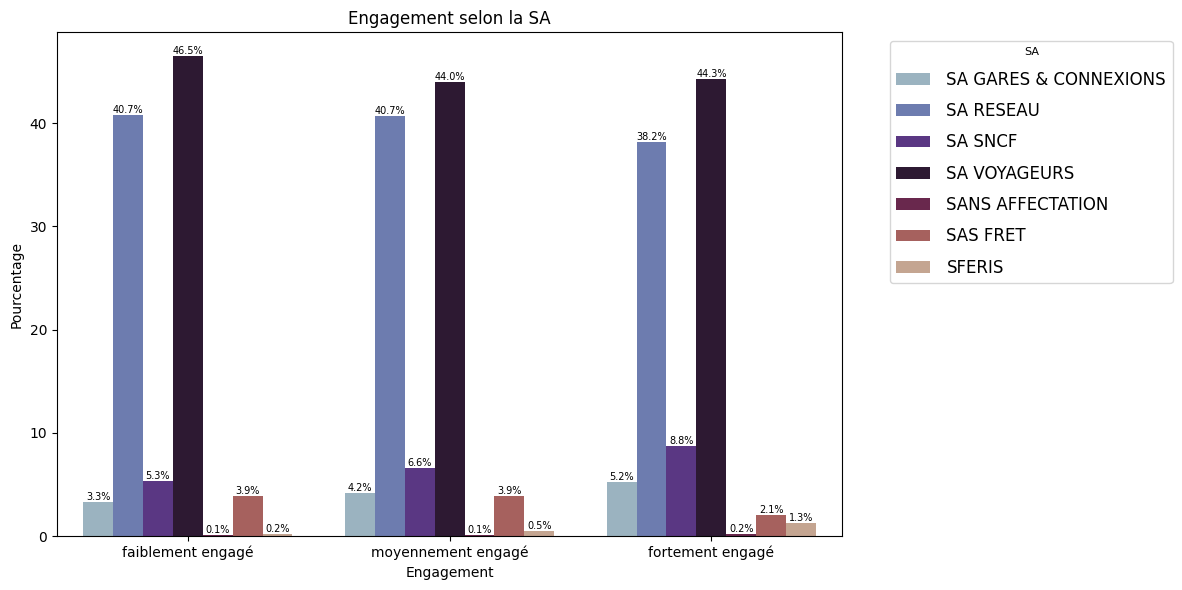

,ID BDD,ANNEE,SEXE,CLASSE,SNCF_Group,Niveau SA,Niveau 3,etat_desprit,aimer_travailler_pour_SNCF,etre_fier_de_travailler_pour_SNCF,...,satisfaction_soutient_descollegues_bis,satisfaction_soutient_mon_manage_bis,satisfaction_acces_informations_metiers_bis,satisfaction_temps_bis,benefier_informations_necessaires_montravail_bis,QVT_somme,QVT_indicateur,QVT_indicateur_bis,classe_QVT,SEXE_label
0,1,2023,1,4,1,5.0,32.0,Inquiet,3,3,...,0,0,0,0,0,0,0,0.000000,NaN,homme
1,2,2023,1,2,1,5.0,34.0,motivé,1,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme
2,3,2023,1,4,1,5.0,32.0,Neutre,2,3,...,1,1,1,0,1,7,1,0.583333,Qualité de vie moyenne,homme
3,4,2023,1,5,1,5.0,34.0,Neutre,2,2,...,1,1,1,1,1,11,1,0.916667,Qualité de vie élevée,homme
4,5,2023,1,2,1,5.0,32.0,motivé,1,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99118,99119,2023,1,15,1,2.0,1.0,motivé,1,1,...,1,1,0,1,0,6,1,0.500000,Qualité de vie faible,homme
99119,99120,2023,1,6,1,3.0,36.0,Inquiet,1,1,...,1,1,1,0,1,8,1,0.666667,Qualité de vie moyenne,homme
99120,99121,2023,2,5,1,5.0,34.0,Neutre,2,2,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme
99121,99122,2023,2,1,1,4.0,24.0,Neutre,2,1,...,1,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme


In [ ]:
###classe d'engagement selon la SA

##Engagement suivant la SA

label_SA = {1:'SAS FRET',2:'SA GARES & CONNEXIONS',3:'SA RESEAU',4: 'SA SNCF',5: 'SA VOYAGEURS',6:'SFERIS',8:'SANS AFFECTATION'}

# Appliquer les mappings

#Base_2023_renamed['Niveau_SA_label'] = Base_2023_renamed['Niveau SA'].map(label_SA)

#Base_2023_renamed['etat_desprit'] = Base_2023_renamed['etat_desprit'].map(labels_mapping)

# Calculer les pourcentages

percentage_df_SA = (
    Base_2023_renamed.groupby(['classe_engagement', 'Niveau_SA_label'])
    .size()
    .reset_index(name='count')
    .groupby('classe_engagement')
    .apply(lambda x: x.assign(percentage_sa=100 * x['count'] / x['count'].sum()))
    .reset_index(drop=True)
)

# Vérifiez les pourcentages calculés
print(percentage_df_SA.head())

# Définir une palette de couleurs
palette = sns.color_palette('twilight', n_colors=7)

# Tracer le graphique
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=percentage_df_SA, x='classe_engagement', y='percentage_sa', hue='Niveau_SA_label', palette=palette)

# Ajustements esthétiques
plt.title("Engagement selon la SA")
plt.xlabel('Engagement')
plt.ylabel('Pourcentage')

plt.xticks(rotation=0)

#legend_patches = [Patch(color=legend_colors[i], label=legend_labels[i], edgecolor='black', linewidth=1.5) for i in range(len(legend_labels))]
plt.legend(title='SA', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large', title_fontsize='8', labelspacing=0.8, handletextpad=1)

# Annoter les barres avec les pourcentages
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=7)

# Ajustement de la mise en page
plt.tight_layout()

# Affichage
plt.show()

Base_2023_renamed.drop(columns='Niveau_SA_label')



In [ ]:
##Taux d'engagement moyen par SA

#label_sex = {1: 'homme', 2: 'femme', 3: 'autre'}

Base_2023_renamed['Niveau_SA_label'] = Base_2023_renamed['Niveau SA'].map(label_SA)

# Calculer les pourcentages
percentage_df_enga= (
    Base_2023_renamed.groupby(['Niveau_SA_label'])
    .mean('engagement_bis'))

# Vérifiez les pourcentages calculés
print(percentage_df_enga['engagement_bis'].head())


Niveau_SA_label
SA GARES & CONNEXIONS    0.728983
SA RESEAU                0.664502
SA SNCF                  0.726357
SA VOYAGEURS             0.632034
SANS AFFECTATION         0.732544
Name: engagement_bis, dtype: float64


#####qualité de vie selon le sexe

In [ ]:
print(Base_2023_renamed['SEXE'].value_counts())

SEXE
1    75504
2    22704
3      915
Name: count, dtype: int64


                 QVT_indicateur_label SEXE_label  count  percentage_sa
0  Mauvaise qualité de vie au travail      autre     60       0.380300
1  Mauvaise qualité de vie au travail      femme   3416      21.651772
2  Mauvaise qualité de vie au travail      homme  12301      77.967928
3     bonne qualité de vie au travail      autre    855       1.025844
4     bonne qualité de vie au travail      femme  19288      23.142082
5     bonne qualité de vie au travail      homme  63203      75.832074


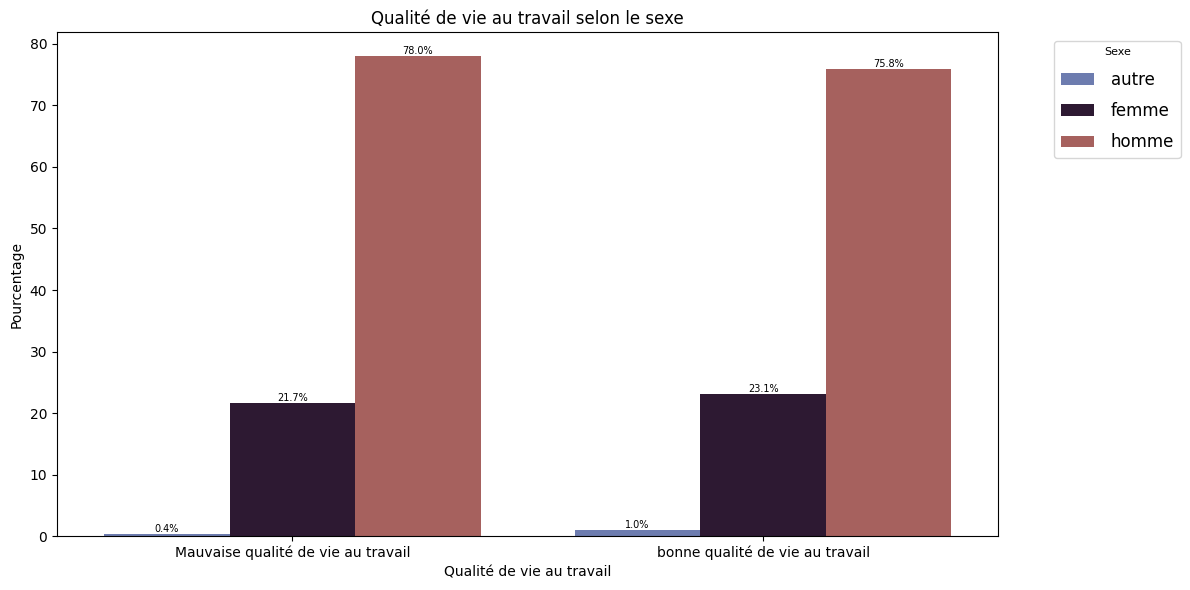

,ID BDD,ANNEE,CLASSE,SNCF_Group,Niveau SA,Niveau 3,etat_desprit,aimer_travailler_pour_SNCF,etre_fier_de_travailler_pour_SNCF,recommander_SNCF,...,satisfaction_soutient_mon_manage_bis,satisfaction_acces_informations_metiers_bis,satisfaction_temps_bis,benefier_informations_necessaires_montravail_bis,QVT_somme,QVT_indicateur,QVT_indicateur_bis,classe_QVT,SEXE_label,Niveau_SA_label
0,1,2023,4,1,5.0,32.0,Inquiet,3,3,4,...,0,0,0,0,0,0,0.000000,NaN,homme,SA VOYAGEURS
1,2,2023,2,1,5.0,34.0,motivé,1,1,1,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme,SA VOYAGEURS
2,3,2023,4,1,5.0,32.0,Neutre,2,3,4,...,1,1,0,1,7,1,0.583333,Qualité de vie moyenne,homme,SA VOYAGEURS
3,4,2023,5,1,5.0,34.0,Neutre,2,2,3,...,1,1,1,1,11,1,0.916667,Qualité de vie élevée,homme,SA VOYAGEURS
4,5,2023,2,1,5.0,32.0,motivé,1,1,1,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme,SA VOYAGEURS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99118,99119,2023,15,1,2.0,1.0,motivé,1,1,1,...,1,0,1,0,6,1,0.500000,Qualité de vie faible,homme,SA GARES & CONNEXIONS
99119,99120,2023,6,1,3.0,36.0,Inquiet,1,1,3,...,1,1,0,1,8,1,0.666667,Qualité de vie moyenne,homme,SA RESEAU
99120,99121,2023,5,1,5.0,34.0,Neutre,2,2,2,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme,SA VOYAGEURS
99121,99122,2023,1,1,4.0,24.0,Neutre,2,1,2,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme,SA SNCF


In [ ]:
###classe d'engagement selon la SA

##Engagement suivant la SA

label_QVT = {1:'bonne qualité de vie au travail',0:'Mauvaise qualité de vie au travail'}

# Appliquer les mappings

Base_2023_renamed['QVT_indicateur_label'] = Base_2023_renamed['QVT_indicateur'].map(label_QVT)

Base_2023_renamed['SEXE_label'] = Base_2023_renamed['SEXE'].map(label_sex)
#Base_2023_renamed['etat_desprit'] = Base_2023_renamed['etat_desprit'].map(labels_mapping)

# Calculer les pourcentages

percentage_df_SA = (
    Base_2023_renamed.groupby(['QVT_indicateur_label', 'SEXE_label'])
    .size()
    .reset_index(name='count')
    .groupby('QVT_indicateur_label')
    .apply(lambda x: x.assign(percentage_sa=100 * x['count'] / x['count'].sum()))
    .reset_index(drop=True)
)

# Vérifiez les pourcentages calculés
print(percentage_df_SA)

# Définir une palette de couleurs
palette = sns.color_palette('twilight', n_colors=3)

# Tracer le graphique
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=percentage_df_SA, x='QVT_indicateur_label', y='percentage_sa', hue='SEXE_label', palette=palette)

# Ajustements esthétiques
plt.title("Qualité de vie au travail selon le sexe")
plt.xlabel('Qualité de vie au travail')
plt.ylabel('Pourcentage')

plt.xticks(rotation=0)

#legend_patches = [Patch(color=legend_colors[i], label=legend_labels[i], edgecolor='black', linewidth=1.5) for i in range(len(legend_labels))]
plt.legend(title='Sexe', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large', title_fontsize='8', labelspacing=0.8, handletextpad=1)

# Annoter les barres avec les pourcentages
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=7)

# Ajustement de la mise en page
plt.tight_layout()

# Affichage
plt.show()

Base_2023_renamed.drop(columns=['QVT_indicateur_label','SEXE'])



                 QVT_indicateur_label SEXE_label  count  percentage_sa
0  Mauvaise qualité de vie au travail      autre     60       6.557377
1     bonne qualité de vie au travail      autre    855      93.442623
2  Mauvaise qualité de vie au travail      femme   3416      15.045807
3     bonne qualité de vie au travail      femme  19288      84.954193
4  Mauvaise qualité de vie au travail      homme  12301      16.291852
5     bonne qualité de vie au travail      homme  63203      83.708148


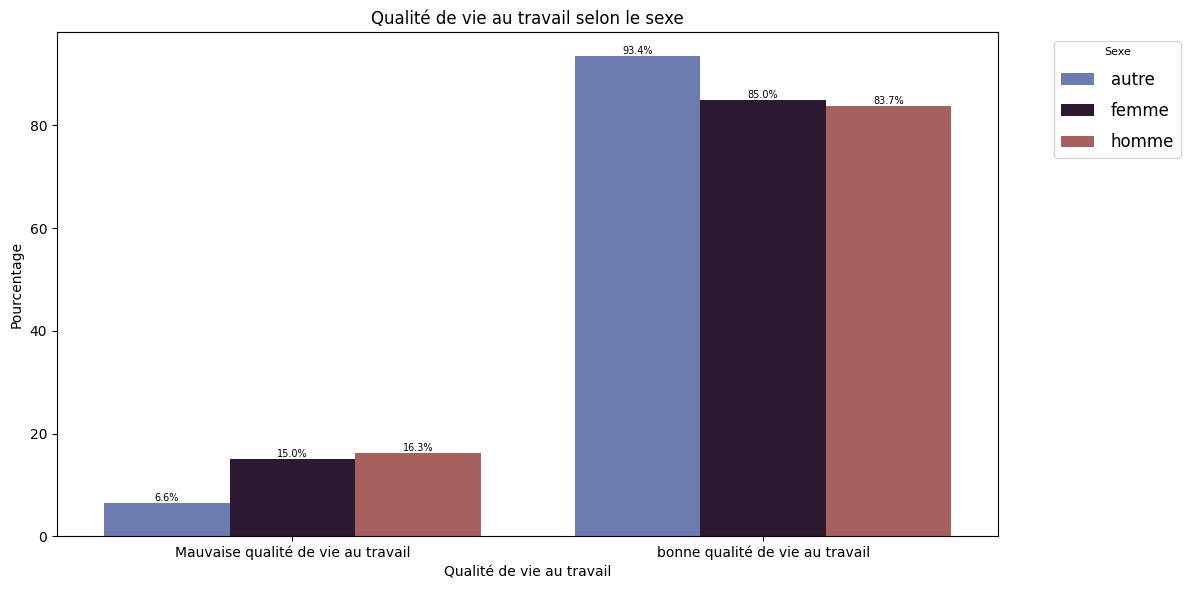

,ID BDD,ANNEE,CLASSE,SNCF_Group,Niveau SA,Niveau 3,etat_desprit,aimer_travailler_pour_SNCF,etre_fier_de_travailler_pour_SNCF,recommander_SNCF,...,satisfaction_soutient_mon_manage_bis,satisfaction_acces_informations_metiers_bis,satisfaction_temps_bis,benefier_informations_necessaires_montravail_bis,QVT_somme,QVT_indicateur,QVT_indicateur_bis,classe_QVT,SEXE_label,Niveau_SA_label
0,1,2023,4,1,5.0,32.0,Inquiet,3,3,4,...,0,0,0,0,0,0,0.000000,NaN,homme,SA VOYAGEURS
1,2,2023,2,1,5.0,34.0,motivé,1,1,1,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme,SA VOYAGEURS
2,3,2023,4,1,5.0,32.0,Neutre,2,3,4,...,1,1,0,1,7,1,0.583333,Qualité de vie moyenne,homme,SA VOYAGEURS
3,4,2023,5,1,5.0,34.0,Neutre,2,2,3,...,1,1,1,1,11,1,0.916667,Qualité de vie élevée,homme,SA VOYAGEURS
4,5,2023,2,1,5.0,32.0,motivé,1,1,1,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme,SA VOYAGEURS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99118,99119,2023,15,1,2.0,1.0,motivé,1,1,1,...,1,0,1,0,6,1,0.500000,Qualité de vie faible,homme,SA GARES & CONNEXIONS
99119,99120,2023,6,1,3.0,36.0,Inquiet,1,1,3,...,1,1,0,1,8,1,0.666667,Qualité de vie moyenne,homme,SA RESEAU
99120,99121,2023,5,1,5.0,34.0,Neutre,2,2,2,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme,SA VOYAGEURS
99121,99122,2023,1,1,4.0,24.0,Neutre,2,1,2,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme,SA SNCF


In [ ]:
###classe d'engagement selon la SA

##Engagement suivant la SA

label_QVT = {1:'bonne qualité de vie au travail',0:'Mauvaise qualité de vie au travail'}

# Appliquer les mappings

Base_2023_renamed['QVT_indicateur_label'] = Base_2023_renamed['QVT_indicateur'].map(label_QVT)

Base_2023_renamed['SEXE_label'] = Base_2023_renamed['SEXE'].map(label_sex)
#Base_2023_renamed['etat_desprit'] = Base_2023_renamed['etat_desprit'].map(labels_mapping)

# Calculer les pourcentages

percentage_df_SA = (
    Base_2023_renamed.groupby(['QVT_indicateur_label', 'SEXE_label'])
    .size()
    .reset_index(name='count')
    .groupby('SEXE_label')
    .apply(lambda x: x.assign(percentage_sa=100 * x['count'] / x['count'].sum()))
    .reset_index(drop=True)
)

# Vérifiez les pourcentages calculés
print(percentage_df_SA)

# Définir une palette de couleurs
palette = sns.color_palette('twilight', n_colors=3)

# Tracer le graphique
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=percentage_df_SA, x='QVT_indicateur_label', y='percentage_sa', hue='SEXE_label', palette=palette)

# Ajustements esthétiques
plt.title("Qualité de vie au travail selon le sexe")
plt.xlabel('Qualité de vie au travail')
plt.ylabel('Pourcentage')

plt.xticks(rotation=0)

#legend_patches = [Patch(color=legend_colors[i], label=legend_labels[i], edgecolor='black', linewidth=1.5) for i in range(len(legend_labels))]
plt.legend(title='Sexe', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large', title_fontsize='8', labelspacing=0.8, handletextpad=1)

# Annoter les barres avec les pourcentages
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=7)

# Ajustement de la mise en page
plt.tight_layout()

# Affichage
plt.show()

Base_2023_renamed.drop(columns=['QVT_indicateur_label','SEXE'])



                    classe_QVT SEXE_label  count  percentage_sa
0        Qualité de vie faible      autre     71       7.888889
1       Qualité de vie moyenne      autre    138      15.333333
2        Qualité de vie élevée      autre    267      29.666667
3   Qualité de vie très elevée      autre    424      47.111111
4        Qualité de vie faible      femme   4384      19.567934
5       Qualité de vie moyenne      femme   6032      26.923764
6        Qualité de vie élevée      femme   6172      27.548652
7   Qualité de vie très elevée      femme   5816      25.959650
8        Qualité de vie faible      homme  15285      20.644804
9       Qualité de vie moyenne      homme  20218      27.307599
10       Qualité de vie élevée      homme  20614      27.842459
11  Qualité de vie très elevée      homme  17921      24.205138


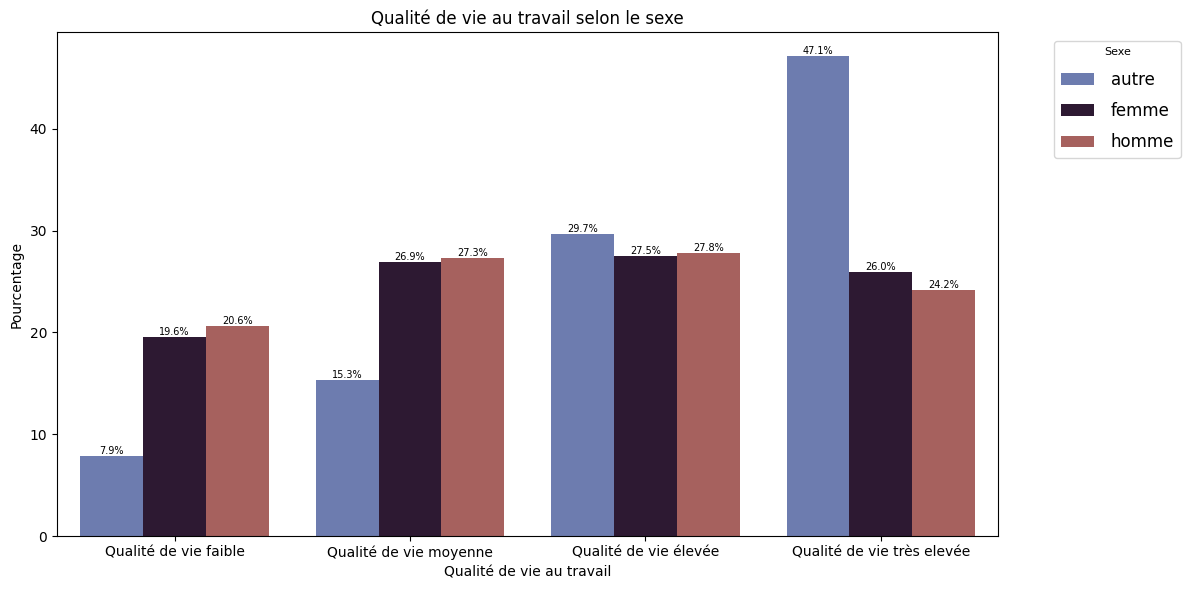

,ID BDD,ANNEE,CLASSE,SNCF_Group,Niveau SA,Niveau 3,etat_desprit,aimer_travailler_pour_SNCF,etre_fier_de_travailler_pour_SNCF,recommander_SNCF,...,satisfaction_soutient_mon_manage_bis,satisfaction_acces_informations_metiers_bis,satisfaction_temps_bis,benefier_informations_necessaires_montravail_bis,QVT_somme,QVT_indicateur,QVT_indicateur_bis,classe_QVT,SEXE_label,Niveau_SA_label
0,1,2023,4,1,5.0,32.0,Inquiet,3,3,4,...,0,0,0,0,0,0,0.000000,NaN,homme,SA VOYAGEURS
1,2,2023,2,1,5.0,34.0,motivé,1,1,1,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme,SA VOYAGEURS
2,3,2023,4,1,5.0,32.0,Neutre,2,3,4,...,1,1,0,1,7,1,0.583333,Qualité de vie moyenne,homme,SA VOYAGEURS
3,4,2023,5,1,5.0,34.0,Neutre,2,2,3,...,1,1,1,1,11,1,0.916667,Qualité de vie élevée,homme,SA VOYAGEURS
4,5,2023,2,1,5.0,32.0,motivé,1,1,1,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme,SA VOYAGEURS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99118,99119,2023,15,1,2.0,1.0,motivé,1,1,1,...,1,0,1,0,6,1,0.500000,Qualité de vie faible,homme,SA GARES & CONNEXIONS
99119,99120,2023,6,1,3.0,36.0,Inquiet,1,1,3,...,1,1,0,1,8,1,0.666667,Qualité de vie moyenne,homme,SA RESEAU
99120,99121,2023,5,1,5.0,34.0,Neutre,2,2,2,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme,SA VOYAGEURS
99121,99122,2023,1,1,4.0,24.0,Neutre,2,1,2,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme,SA SNCF


In [ ]:

###classe d'engagement selon la SA

##Engagement suivant la SA

#label_QVT = {1:'bonne qualité de vie au travail',0:'Mauvaise qualité de vie au travail'}

# Appliquer les mappings

#Base_2023_renamed['QVT_indicateur_label'] = Base_2023_renamed['QVT_indicateur'].map(label_QVT)

Base_2023_renamed['SEXE_label'] = Base_2023_renamed['SEXE'].map(label_sex)
#Base_2023_renamed['etat_desprit'] = Base_2023_renamed['etat_desprit'].map(labels_mapping)

# Calculer les pourcentages

percentage_df_SA = (
    Base_2023_renamed.groupby(['classe_QVT', 'SEXE_label'])
    .size()
    .reset_index(name='count')
    .groupby('SEXE_label')
    .apply(lambda x: x.assign(percentage_sa=100 * x['count'] / x['count'].sum()))
    .reset_index(drop=True)
)

# Vérifiez les pourcentages calculés
print(percentage_df_SA)

# Définir une palette de couleurs
palette = sns.color_palette('twilight', n_colors=3)

# Tracer le graphique
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=percentage_df_SA, x='classe_QVT', y='percentage_sa', hue='SEXE_label', palette=palette)

# Ajustements esthétiques
plt.title("Qualité de vie au travail selon le sexe")
plt.xlabel('Qualité de vie au travail')
plt.ylabel('Pourcentage')

plt.xticks(rotation=0)

#legend_patches = [Patch(color=legend_colors[i], label=legend_labels[i], edgecolor='black', linewidth=1.5) for i in range(len(legend_labels))]
plt.legend(title='Sexe', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large', title_fontsize='8', labelspacing=0.8, handletextpad=1)

# Annoter les barres avec les pourcentages
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=7)

# Ajustement de la mise en page
plt.tight_layout()

# Affichage
plt.show()

Base_2023_renamed.drop(columns=['QVT_indicateur_label','SEXE'])



                    classe_QVT SEXE_label  count  percentage_sa
0        Qualité de vie faible      autre     71       0.359676
1        Qualité de vie faible      femme   4384      22.208713
2        Qualité de vie faible      homme  15285      77.431611
3       Qualité de vie moyenne      autre    138       0.522965
4       Qualité de vie moyenne      femme   6032      22.858875
5       Qualité de vie moyenne      homme  20218      76.618160
6        Qualité de vie élevée      autre    267       0.986952
7        Qualité de vie élevée      femme   6172      22.814475
8        Qualité de vie élevée      homme  20614      76.198573
9   Qualité de vie très elevée      autre    424       1.754894
10  Qualité de vie très elevée      femme   5816      24.071851
11  Qualité de vie très elevée      homme  17921      74.173254


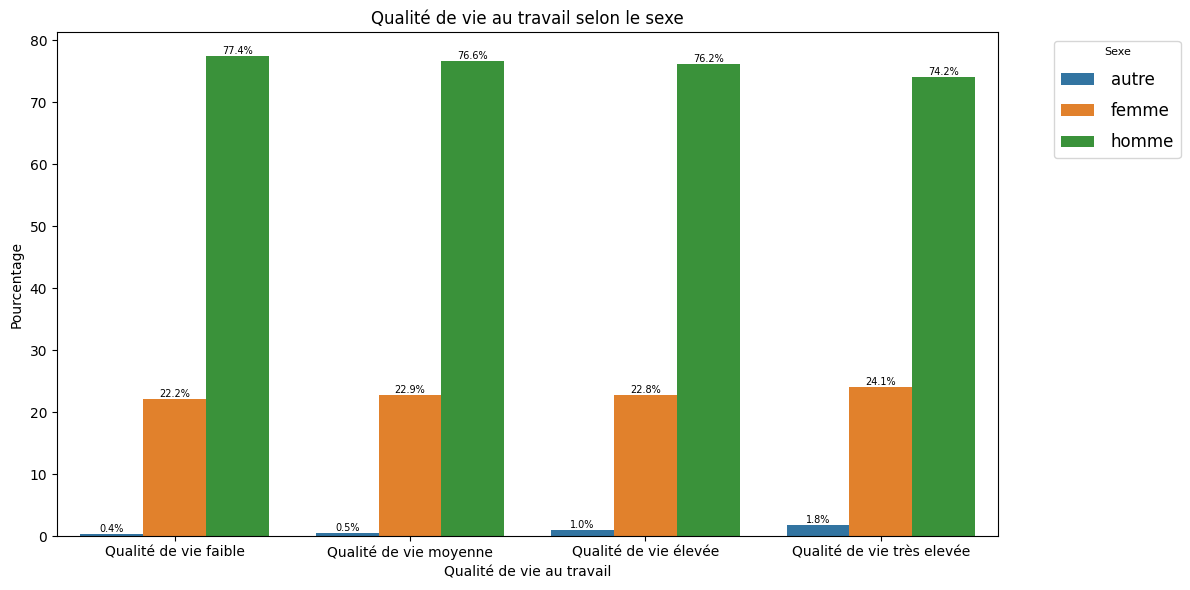

,ID BDD,ANNEE,CLASSE,SNCF_Group,Niveau SA,Niveau 3,etat_desprit,aimer_travailler_pour_SNCF,etre_fier_de_travailler_pour_SNCF,recommander_SNCF,...,satisfaction_soutient_mon_manage_bis,satisfaction_acces_informations_metiers_bis,satisfaction_temps_bis,benefier_informations_necessaires_montravail_bis,QVT_somme,QVT_indicateur,QVT_indicateur_bis,classe_QVT,SEXE_label,Niveau_SA_label
0,1,2023,4,1,5.0,32.0,Inquiet,3,3,4,...,0,0,0,0,0,0,0.000000,NaN,homme,SA VOYAGEURS
1,2,2023,2,1,5.0,34.0,motivé,1,1,1,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme,SA VOYAGEURS
2,3,2023,4,1,5.0,32.0,Neutre,2,3,4,...,1,1,0,1,7,1,0.583333,Qualité de vie moyenne,homme,SA VOYAGEURS
3,4,2023,5,1,5.0,34.0,Neutre,2,2,3,...,1,1,1,1,11,1,0.916667,Qualité de vie élevée,homme,SA VOYAGEURS
4,5,2023,2,1,5.0,32.0,motivé,1,1,1,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme,SA VOYAGEURS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99118,99119,2023,15,1,2.0,1.0,motivé,1,1,1,...,1,0,1,0,6,1,0.500000,Qualité de vie faible,homme,SA GARES & CONNEXIONS
99119,99120,2023,6,1,3.0,36.0,Inquiet,1,1,3,...,1,1,0,1,8,1,0.666667,Qualité de vie moyenne,homme,SA RESEAU
99120,99121,2023,5,1,5.0,34.0,Neutre,2,2,2,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme,SA VOYAGEURS
99121,99122,2023,1,1,4.0,24.0,Neutre,2,1,2,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme,SA SNCF


In [ ]:

###classe d'engagement selon la SA

##Engagement suivant la SA

#label_QVT = {1:'bonne qualité de vie au travail',0:'Mauvaise qualité de vie au travail'}

# Appliquer les mappings

#Base_2023_renamed['QVT_indicateur_label'] = Base_2023_renamed['QVT_indicateur'].map(label_QVT)

Base_2023_renamed['SEXE_label'] = Base_2023_renamed['SEXE'].map(label_sex)
#Base_2023_renamed['etat_desprit'] = Base_2023_renamed['etat_desprit'].map(labels_mapping)

# Calculer les pourcentages

percentage_df_SA = (
    Base_2023_renamed.groupby(['classe_QVT', 'SEXE_label'])
    .size()
    .reset_index(name='count')
    .groupby('classe_QVT')
    .apply(lambda x: x.assign(percentage_sa=100 * x['count'] / x['count'].sum()))
    .reset_index(drop=True)
)

# Vérifiez les pourcentages calculés
print(percentage_df_SA)

# Définir une palette de couleurs
palette = sns.color_palette('tab10', n_colors=3)

# Tracer le graphique
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=percentage_df_SA, x='classe_QVT', y='percentage_sa', hue='SEXE_label', palette=palette)

# Ajustements esthétiques
plt.title("Qualité de vie au travail selon le sexe")
plt.xlabel('Qualité de vie au travail')
plt.ylabel('Pourcentage')

plt.xticks(rotation=0)

#legend_patches = [Patch(color=legend_colors[i], label=legend_labels[i], edgecolor='black', linewidth=1.5) for i in range(len(legend_labels))]
plt.legend(title='Sexe', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large', title_fontsize='8', labelspacing=0.8, handletextpad=1)

# Annoter les barres avec les pourcentages
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=7)

# Ajustement de la mise en page
plt.tight_layout()

# Affichage
plt.show()

Base_2023_renamed.drop(columns=['QVT_indicateur_label','SEXE'])



In [ ]:
#quanlité de vie moyenne par sexe

##Taux d'engagement moyen par SA

label_sex = {1: 'homme', 2: 'femme', 3: 'autre'}

Base_2023_renamed['SEXE_label'] = Base_2023_renamed['SEXE'].map(label_sex)

# Calculer les pourcentages
percentage_df_enga= (
    Base_2023_renamed.groupby(['SEXE_label'])
    .mean('QVT_indicateur_bis'))

# Vérifiez les pourcentages calculés
print(percentage_df_enga['QVT_indicateur_bis'].head())


SEXE_label
autre    0.856922
femme    0.744781
homme    0.730505
Name: QVT_indicateur_bis, dtype: float64


######Qualité de vie au travail selon la SA

In [ ]:
#qualité de vie moyenne par sexe

##Taux d'engagement moyen par SA

label_sex = {1: 'homme', 2: 'femme', 3: 'autre'}

Base_2023_renamed['Niveau_SA_label'] = Base_2023_renamed['Niveau SA'].map(label_SA)

# Calculer les pourcentages
percentage_df_enga= (
    Base_2023_renamed.groupby(['Niveau_SA_label'])
    .mean('QVT_indicateur_bis'))

# Vérifiez les pourcentages calculés

print(percentage_df_enga['QVT_indicateur_bis'].head())


Niveau_SA_label
SA GARES & CONNEXIONS    0.800965
SA RESEAU                0.749409
SA SNCF                  0.793395
SA VOYAGEURS             0.707153
SANS AFFECTATION         0.789941
Name: QVT_indicateur_bis, dtype: float64


                  QVT_indicateur_label        Niveau_SA_label  count  \
0   Mauvaise qualité de vie au travail  SA GARES & CONNEXIONS    345   
1   Mauvaise qualité de vie au travail              SA RESEAU   5010   
2   Mauvaise qualité de vie au travail                SA SNCF    667   
3   Mauvaise qualité de vie au travail           SA VOYAGEURS   9089   
4   Mauvaise qualité de vie au travail       SANS AFFECTATION     22   
5   Mauvaise qualité de vie au travail               SAS FRET    599   
6   Mauvaise qualité de vie au travail                 SFERIS     44   
7      bonne qualité de vie au travail  SA GARES & CONNEXIONS   3854   
8      bonne qualité de vie au travail              SA RESEAU  33370   
9      bonne qualité de vie au travail                SA SNCF   6204   
10     bonne qualité de vie au travail           SA VOYAGEURS  36482   
11     bonne qualité de vie au travail       SANS AFFECTATION    147   
12     bonne qualité de vie au travail               SAS FRET   

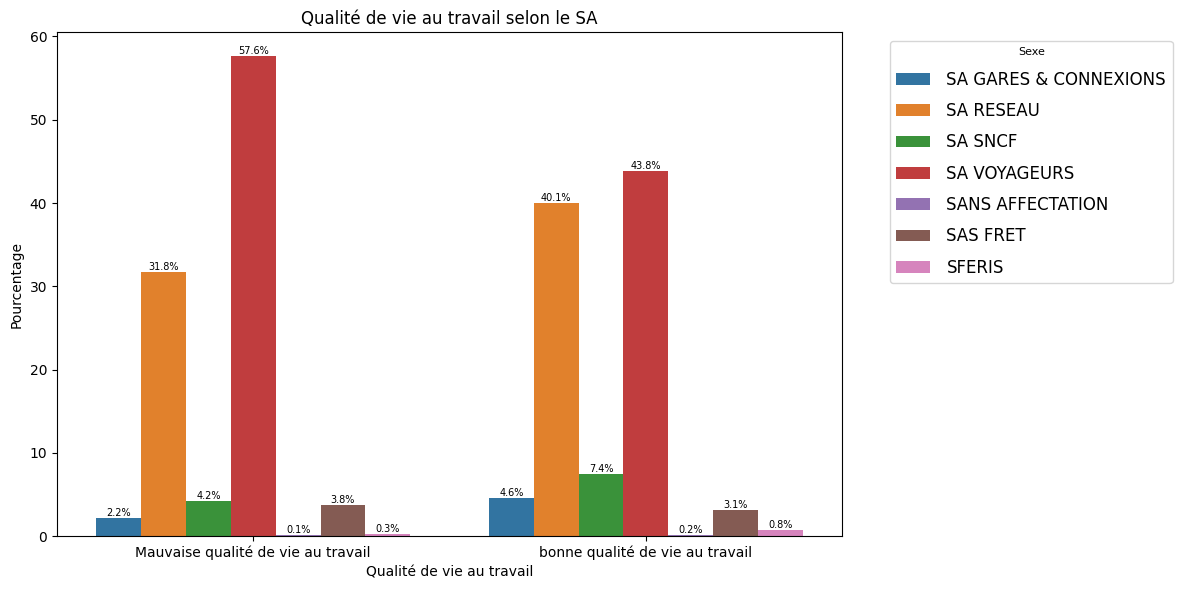

,ID BDD,ANNEE,CLASSE,SNCF_Group,Niveau SA,Niveau 3,etat_desprit,aimer_travailler_pour_SNCF,etre_fier_de_travailler_pour_SNCF,recommander_SNCF,...,satisfaction_soutient_mon_manage_bis,satisfaction_acces_informations_metiers_bis,satisfaction_temps_bis,benefier_informations_necessaires_montravail_bis,QVT_somme,QVT_indicateur,QVT_indicateur_bis,classe_QVT,SEXE_label,Niveau_SA_label
0,1,2023,4,1,5.0,32.0,Inquiet,3,3,4,...,0,0,0,0,0,0,0.000000,NaN,homme,SA VOYAGEURS
1,2,2023,2,1,5.0,34.0,motivé,1,1,1,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme,SA VOYAGEURS
2,3,2023,4,1,5.0,32.0,Neutre,2,3,4,...,1,1,0,1,7,1,0.583333,Qualité de vie moyenne,homme,SA VOYAGEURS
3,4,2023,5,1,5.0,34.0,Neutre,2,2,3,...,1,1,1,1,11,1,0.916667,Qualité de vie élevée,homme,SA VOYAGEURS
4,5,2023,2,1,5.0,32.0,motivé,1,1,1,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme,SA VOYAGEURS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99118,99119,2023,15,1,2.0,1.0,motivé,1,1,1,...,1,0,1,0,6,1,0.500000,Qualité de vie faible,homme,SA GARES & CONNEXIONS
99119,99120,2023,6,1,3.0,36.0,Inquiet,1,1,3,...,1,1,0,1,8,1,0.666667,Qualité de vie moyenne,homme,SA RESEAU
99120,99121,2023,5,1,5.0,34.0,Neutre,2,2,2,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme,SA VOYAGEURS
99121,99122,2023,1,1,4.0,24.0,Neutre,2,1,2,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme,SA SNCF


In [ ]:

###classe d'engagement selon la SA

##Engagement suivant la SA

label_QVT = {1:'bonne qualité de vie au travail',0:'Mauvaise qualité de vie au travail'}

# Appliquer les mappings

Base_2023_renamed['QVT_indicateur_label'] = Base_2023_renamed['QVT_indicateur'].map(label_QVT)

#Base_2023_renamed['etat_desprit'] = Base_2023_renamed['etat_desprit'].map(labels_mapping)

# Calculer les pourcentages

percentage_df_SA = (
    Base_2023_renamed.groupby(['QVT_indicateur_label', 'Niveau_SA_label'])
    .size()
    .reset_index(name='count')
    .groupby('QVT_indicateur_label')
    .apply(lambda x: x.assign(percentage_sa=100 * x['count'] / x['count'].sum()))
    .reset_index(drop=True)
)

# Vérifiez les pourcentages calculés
print(percentage_df_SA)

# Définir une palette de couleurs
palette = sns.color_palette('tab10', n_colors=7)

# Tracer le graphique
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=percentage_df_SA, x='QVT_indicateur_label', y='percentage_sa', hue='Niveau_SA_label', palette=palette)

# Ajustements esthétiques
plt.title("Qualité de vie au travail selon le SA")
plt.xlabel('Qualité de vie au travail')
plt.ylabel('Pourcentage')

plt.xticks(rotation=0)

#legend_patches = [Patch(color=legend_colors[i], label=legend_labels[i], edgecolor='black', linewidth=1.5) for i in range(len(legend_labels))]
plt.legend(title='Sexe', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large', title_fontsize='8', labelspacing=0.8, handletextpad=1)

# Annoter les barres avec les pourcentages
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=7)

# Ajustement de la mise en page
plt.tight_layout()

# Affichage
plt.show()

Base_2023_renamed.drop(columns=['QVT_indicateur_label','SEXE'])



                  QVT_indicateur_label        Niveau_SA_label  count  \
0   Mauvaise qualité de vie au travail  SA GARES & CONNEXIONS    345   
1      bonne qualité de vie au travail  SA GARES & CONNEXIONS   3854   
2   Mauvaise qualité de vie au travail              SA RESEAU   5010   
3      bonne qualité de vie au travail              SA RESEAU  33370   
4   Mauvaise qualité de vie au travail                SA SNCF    667   
5      bonne qualité de vie au travail                SA SNCF   6204   
6   Mauvaise qualité de vie au travail           SA VOYAGEURS   9089   
7      bonne qualité de vie au travail           SA VOYAGEURS  36482   
8   Mauvaise qualité de vie au travail       SANS AFFECTATION     22   
9      bonne qualité de vie au travail       SANS AFFECTATION    147   
10  Mauvaise qualité de vie au travail               SAS FRET    599   
11     bonne qualité de vie au travail               SAS FRET   2591   
12  Mauvaise qualité de vie au travail                 SFERIS   

<ipython-input-77-0fa66aa05bd4>:32: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  bar_plot = sns.barplot(data=percentage_df_SA, x='QVT_indicateur_label', y='percentage_sa', hue='Niveau_SA_label', palette=palette)


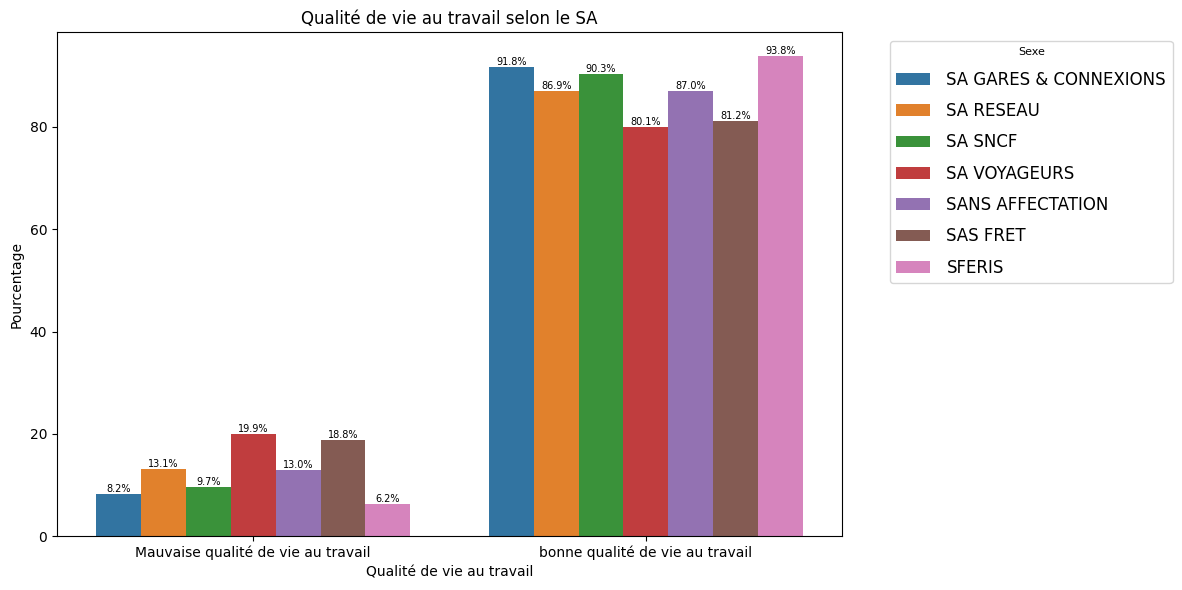

,ID BDD,ANNEE,CLASSE,SNCF_Group,Niveau SA,Niveau 3,etat_desprit,aimer_travailler_pour_SNCF,etre_fier_de_travailler_pour_SNCF,recommander_SNCF,...,satisfaction_soutient_mon_manage_bis,satisfaction_acces_informations_metiers_bis,satisfaction_temps_bis,benefier_informations_necessaires_montravail_bis,QVT_somme,QVT_indicateur,QVT_indicateur_bis,classe_QVT,SEXE_label,Niveau_SA_label
0,1,2023,4,1,5.0,32.0,Inquiet,3,3,4,...,0,0,0,0,0,0,0.000000,NaN,homme,SA VOYAGEURS
1,2,2023,2,1,5.0,34.0,motivé,1,1,1,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme,SA VOYAGEURS
2,3,2023,4,1,5.0,32.0,Neutre,2,3,4,...,1,1,0,1,7,1,0.583333,Qualité de vie moyenne,homme,SA VOYAGEURS
3,4,2023,5,1,5.0,34.0,Neutre,2,2,3,...,1,1,1,1,11,1,0.916667,Qualité de vie élevée,homme,SA VOYAGEURS
4,5,2023,2,1,5.0,32.0,motivé,1,1,1,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme,SA VOYAGEURS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99118,99119,2023,15,1,2.0,1.0,motivé,1,1,1,...,1,0,1,0,6,1,0.500000,Qualité de vie faible,homme,SA GARES & CONNEXIONS
99119,99120,2023,6,1,3.0,36.0,Inquiet,1,1,3,...,1,1,0,1,8,1,0.666667,Qualité de vie moyenne,homme,SA RESEAU
99120,99121,2023,5,1,5.0,34.0,Neutre,2,2,2,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme,SA VOYAGEURS
99121,99122,2023,1,1,4.0,24.0,Neutre,2,1,2,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme,SA SNCF


In [ ]:

###classe d'engagement selon la SA

##Engagement suivant la SA

label_QVT = {1:'bonne qualité de vie au travail',0:'Mauvaise qualité de vie au travail'}

# Appliquer les mappings

Base_2023_renamed['QVT_indicateur_label'] = Base_2023_renamed['QVT_indicateur'].map(label_QVT)

#Base_2023_renamed['etat_desprit'] = Base_2023_renamed['etat_desprit'].map(labels_mapping)

# Calculer les pourcentages

percentage_df_SA = (
    Base_2023_renamed.groupby(['QVT_indicateur_label', 'Niveau_SA_label'])
    .size()
    .reset_index(name='count')
    .groupby('Niveau_SA_label')
    .apply(lambda x: x.assign(percentage_sa=100 * x['count'] / x['count'].sum()))
    .reset_index(drop=True)
)

# Vérifiez les pourcentages calculés
print(percentage_df_SA)

# Définir une palette de couleurs
palette = sns.color_palette('tab10', n_colors=8)

# Tracer le graphique
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=percentage_df_SA, x='QVT_indicateur_label', y='percentage_sa', hue='Niveau_SA_label', palette=palette)

# Ajustements esthétiques
plt.title("Qualité de vie au travail selon le SA")
plt.xlabel('Qualité de vie au travail')
plt.ylabel('Pourcentage')

plt.xticks(rotation=0)

#legend_patches = [Patch(color=legend_colors[i], label=legend_labels[i], edgecolor='black', linewidth=1.5) for i in range(len(legend_labels))]
plt.legend(title='Sexe', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large', title_fontsize='8', labelspacing=0.8, handletextpad=1)

# Annoter les barres avec les pourcentages
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=7)

# Ajustement de la mise en page
plt.tight_layout()

# Affichage
plt.show()

Base_2023_renamed.drop(columns=['QVT_indicateur_label','SEXE'])



                    classe_QVT        Niveau_SA_label  count  percentage_sa
0        Qualité de vie faible  SA GARES & CONNEXIONS    477       2.416658
1        Qualité de vie faible              SA RESEAU   6814      34.522241
2        Qualité de vie faible                SA SNCF    926       4.691458
3        Qualité de vie faible           SA VOYAGEURS  10722      54.321613
4        Qualité de vie faible       SANS AFFECTATION     26       0.131726
5        Qualité de vie faible               SAS FRET    719       3.642720
6        Qualité de vie faible                 SFERIS     54       0.273584
7       Qualité de vie moyenne  SA GARES & CONNEXIONS   1072       4.063531
8       Qualité de vie moyenne              SA RESEAU  11036      41.833137
9       Qualité de vie moyenne                SA SNCF   1652       6.262083
10      Qualité de vie moyenne           SA VOYAGEURS  11625      44.065805
11      Qualité de vie moyenne       SANS AFFECTATION     36       0.136462
12      Qual

<ipython-input-78-f79d238669e2>:25: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  bar_plot = sns.barplot(data=percentage_df_SA, x='classe_QVT', y='percentage_sa', hue='Niveau_SA_label', palette=palette)


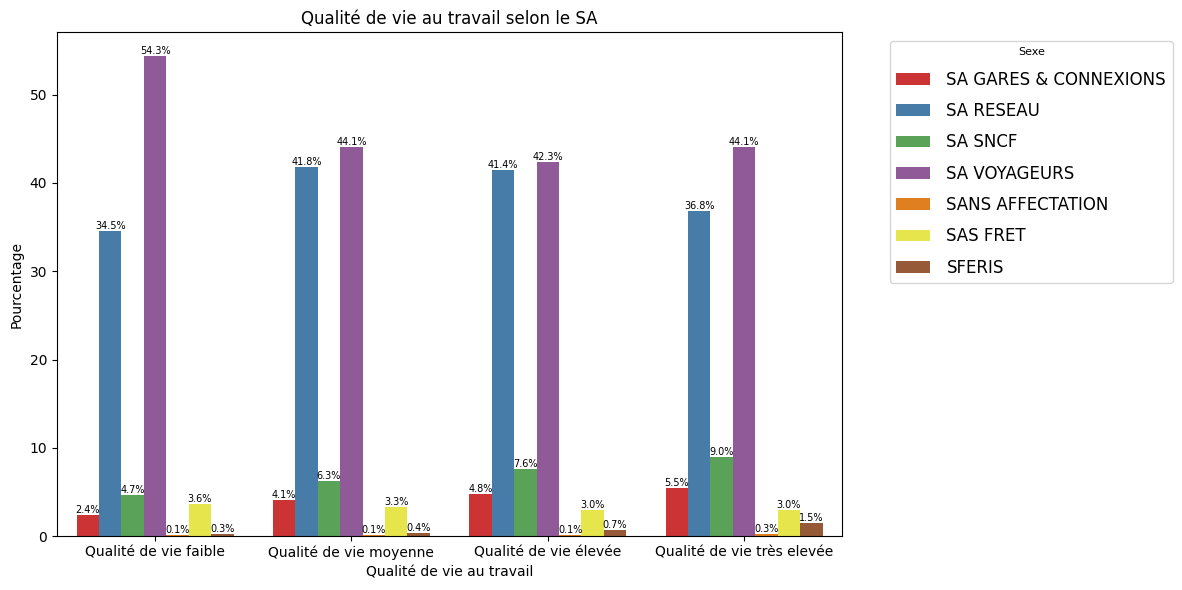

,ID BDD,ANNEE,CLASSE,SNCF_Group,Niveau SA,Niveau 3,etat_desprit,aimer_travailler_pour_SNCF,etre_fier_de_travailler_pour_SNCF,recommander_SNCF,...,satisfaction_soutient_mon_manage_bis,satisfaction_acces_informations_metiers_bis,satisfaction_temps_bis,benefier_informations_necessaires_montravail_bis,QVT_somme,QVT_indicateur,QVT_indicateur_bis,classe_QVT,SEXE_label,Niveau_SA_label
0,1,2023,4,1,5.0,32.0,Inquiet,3,3,4,...,0,0,0,0,0,0,0.000000,NaN,homme,SA VOYAGEURS
1,2,2023,2,1,5.0,34.0,motivé,1,1,1,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme,SA VOYAGEURS
2,3,2023,4,1,5.0,32.0,Neutre,2,3,4,...,1,1,0,1,7,1,0.583333,Qualité de vie moyenne,homme,SA VOYAGEURS
3,4,2023,5,1,5.0,34.0,Neutre,2,2,3,...,1,1,1,1,11,1,0.916667,Qualité de vie élevée,homme,SA VOYAGEURS
4,5,2023,2,1,5.0,32.0,motivé,1,1,1,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme,SA VOYAGEURS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99118,99119,2023,15,1,2.0,1.0,motivé,1,1,1,...,1,0,1,0,6,1,0.500000,Qualité de vie faible,homme,SA GARES & CONNEXIONS
99119,99120,2023,6,1,3.0,36.0,Inquiet,1,1,3,...,1,1,0,1,8,1,0.666667,Qualité de vie moyenne,homme,SA RESEAU
99120,99121,2023,5,1,5.0,34.0,Neutre,2,2,2,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme,SA VOYAGEURS
99121,99122,2023,1,1,4.0,24.0,Neutre,2,1,2,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme,SA SNCF


In [ ]:

###classe d'engagement selon la SA


#Base_2023_renamed['etat_desprit'] = Base_2023_renamed['etat_desprit'].map(labels_mapping)

# Calculer les pourcentages

percentage_df_SA = (
    Base_2023_renamed.groupby(['classe_QVT', 'Niveau_SA_label'])
    .size()
    .reset_index(name='count')
    .groupby('classe_QVT')
    .apply(lambda x: x.assign(percentage_sa=100 * x['count'] / x['count'].sum()))
    .reset_index(drop=True)
)

# Vérifiez les pourcentages calculés
print(percentage_df_SA)

# Définir une palette de couleurs
palette = sns.color_palette('Set1', n_colors=8)

# Tracer le graphique
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=percentage_df_SA, x='classe_QVT', y='percentage_sa', hue='Niveau_SA_label', palette=palette)

# Ajustements esthétiques
plt.title("Qualité de vie au travail selon le SA")
plt.xlabel('Qualité de vie au travail')
plt.ylabel('Pourcentage')

plt.xticks(rotation=0)

#legend_patches = [Patch(color=legend_colors[i], label=legend_labels[i], edgecolor='black', linewidth=1.5) for i in range(len(legend_labels))]
plt.legend(title='Sexe', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large', title_fontsize='8', labelspacing=0.8, handletextpad=1)

# Annoter les barres avec les pourcentages
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=7)

# Ajustement de la mise en page
plt.tight_layout()

# Affichage
plt.show()

Base_2023_renamed.drop(columns=['QVT_indicateur_label','SEXE'])



                    classe_QVT        Niveau_SA_label  count  percentage_sa
0        Qualité de vie faible  SA GARES & CONNEXIONS    477      11.477382
1       Qualité de vie moyenne  SA GARES & CONNEXIONS   1072      25.794033
2        Qualité de vie élevée  SA GARES & CONNEXIONS   1288      30.991338
3   Qualité de vie très elevée  SA GARES & CONNEXIONS   1319      31.737247
4        Qualité de vie faible              SA RESEAU   6814      17.960884
5       Qualité de vie moyenne              SA RESEAU  11036      29.089567
6        Qualité de vie élevée              SA RESEAU  11208      29.542938
7   Qualité de vie très elevée              SA RESEAU   8880      23.406611
8        Qualité de vie faible                SA SNCF    926      13.617647
9       Qualité de vie moyenne                SA SNCF   1652      24.294118
10       Qualité de vie élevée                SA SNCF   2060      30.294118
11  Qualité de vie très elevée                SA SNCF   2162      31.794118
12       Qua

<ipython-input-79-378649fc3742>:25: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  bar_plot = sns.barplot(data=percentage_df_SA, x='classe_QVT', y='percentage_sa', hue='Niveau_SA_label', palette=palette)


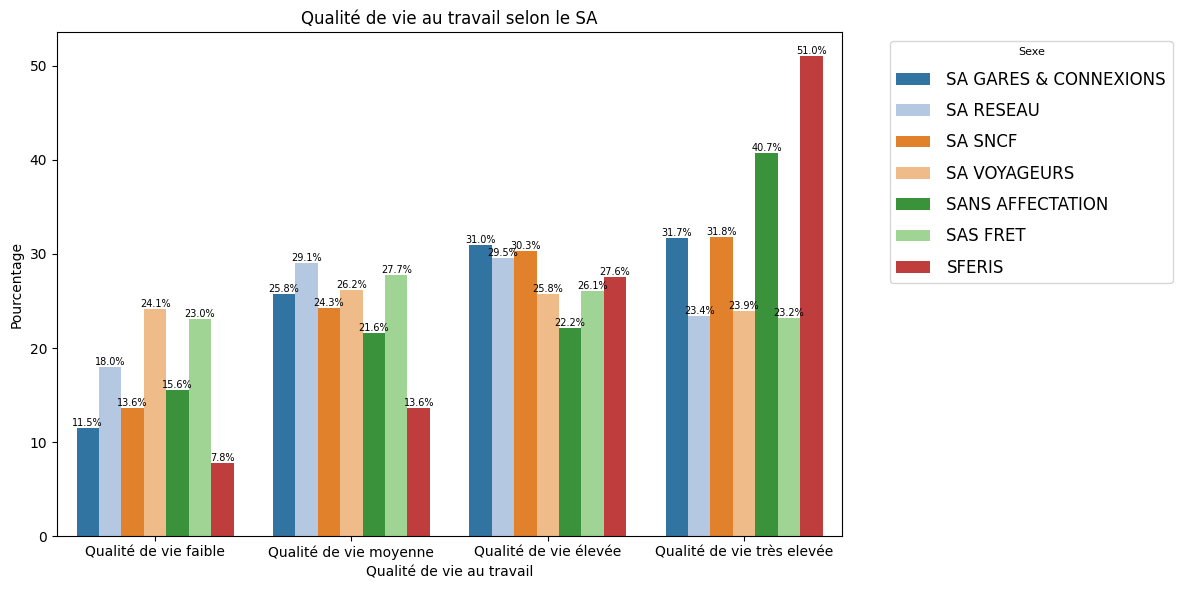

,ID BDD,ANNEE,CLASSE,SNCF_Group,Niveau SA,Niveau 3,etat_desprit,aimer_travailler_pour_SNCF,etre_fier_de_travailler_pour_SNCF,recommander_SNCF,...,satisfaction_soutient_mon_manage_bis,satisfaction_acces_informations_metiers_bis,satisfaction_temps_bis,benefier_informations_necessaires_montravail_bis,QVT_somme,QVT_indicateur,QVT_indicateur_bis,classe_QVT,SEXE_label,Niveau_SA_label
0,1,2023,4,1,5.0,32.0,Inquiet,3,3,4,...,0,0,0,0,0,0,0.000000,NaN,homme,SA VOYAGEURS
1,2,2023,2,1,5.0,34.0,motivé,1,1,1,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme,SA VOYAGEURS
2,3,2023,4,1,5.0,32.0,Neutre,2,3,4,...,1,1,0,1,7,1,0.583333,Qualité de vie moyenne,homme,SA VOYAGEURS
3,4,2023,5,1,5.0,34.0,Neutre,2,2,3,...,1,1,1,1,11,1,0.916667,Qualité de vie élevée,homme,SA VOYAGEURS
4,5,2023,2,1,5.0,32.0,motivé,1,1,1,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,homme,SA VOYAGEURS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99118,99119,2023,15,1,2.0,1.0,motivé,1,1,1,...,1,0,1,0,6,1,0.500000,Qualité de vie faible,homme,SA GARES & CONNEXIONS
99119,99120,2023,6,1,3.0,36.0,Inquiet,1,1,3,...,1,1,0,1,8,1,0.666667,Qualité de vie moyenne,homme,SA RESEAU
99120,99121,2023,5,1,5.0,34.0,Neutre,2,2,2,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme,SA VOYAGEURS
99121,99122,2023,1,1,4.0,24.0,Neutre,2,1,2,...,1,1,1,1,12,1,1.000000,Qualité de vie très elevée,femme,SA SNCF


In [ ]:

###classe d'engagement selon la SA


#Base_2023_renamed['etat_desprit'] = Base_2023_renamed['etat_desprit'].map(labels_mapping)

# Calculer les pourcentages

percentage_df_SA = (
    Base_2023_renamed.groupby(['classe_QVT', 'Niveau_SA_label'])
    .size()
    .reset_index(name='count')
    .groupby('Niveau_SA_label')
    .apply(lambda x: x.assign(percentage_sa=100 * x['count'] / x['count'].sum()))
    .reset_index(drop=True)
)

# Vérifiez les pourcentages calculés
print(percentage_df_SA)

# Définir une palette de couleurs
palette = sns.color_palette('tab20', n_colors=8)

# Tracer le graphique
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=percentage_df_SA, x='classe_QVT', y='percentage_sa', hue='Niveau_SA_label', palette=palette)

# Ajustements esthétiques
plt.title("Qualité de vie au travail selon le SA")
plt.xlabel('Qualité de vie au travail')
plt.ylabel('Pourcentage')

plt.xticks(rotation=0)

#legend_patches = [Patch(color=legend_colors[i], label=legend_labels[i], edgecolor='black', linewidth=1.5) for i in range(len(legend_labels))]
plt.legend(title='Sexe', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large', title_fontsize='8', labelspacing=0.8, handletextpad=1)

# Annoter les barres avec les pourcentages
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=7)

# Ajustement de la mise en page
plt.tight_layout()

# Affichage
plt.show()

Base_2023_renamed.drop(columns=['QVT_indicateur_label','SEXE'])



##Analyse des corrélations/liens avec le projet TOUS SNCF

######Connaissance du projet TOUS SNCF en lien avec l’engagement

In [ ]:
def cramers_v(contingency_table):
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

In [ ]:
#au niveau etablissement: indicateur d'engagement

label_connaisssance={1:'connait le projet',0:'Ne connait pas le projet'}
#Base_2023_renamed['connaisance_projet_etablissement']=Base_2023_renamed['connaisance_projet_etablissement'].map(label_connaisssance)
contingency_table = pd.crosstab(Base_2023_renamed['connaisance_projet_etablissement'],Base_2023_renamed['engagement_indicateur'])

print(contingency_table)

# Test du Chi-2
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-2: {chi2}, p-value: {p}")

print(cramers_v(contingency_table))

# Fréquences relatives par ligne
relative_freq_by_row = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("Fréquences Relatives par Ligne")
print(relative_freq_by_row)

# Fréquences relatives par colonne
relative_freq_by_col = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100

print("Fréquences Relatives par Colonne")
print(relative_freq_by_col)


engagement_indicateur             engagé  non engagé
connaisance_projet_etablissement                    
0                                  16936       14004
1                                  51569       16614
Chi-2: 4351.707075520508, p-value: 0.0
0.2095282608693823
Fréquences Relatives par Ligne
engagement_indicateur                engagé  non engagé
connaisance_projet_etablissement                       
0                                 54.738203   45.261797
1                                 75.633222   24.366778
Fréquences Relatives par Colonne
engagement_indicateur                engagé  non engagé
connaisance_projet_etablissement                       
0                                 24.722283   45.737801
1                                 75.277717   54.262199


In [ ]:
#au niveau etablissement: classe d'engagement  et connaissance projet etablissement

label_connaisssance={1:'connait le projet',0:'Ne connait pas le projet'}

#Base_2023_renamed['connaisance_projet_etablissement']=Base_2023_renamed['connaisance_projet_etablissement'].map(label_connaisssance)

contingency_table = pd.crosstab(Base_2023_renamed['connaisance_projet_etablissement'],Base_2023_renamed['classe_engagement'])

print(contingency_table)

# Test du Chi-2

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-2: {chi2}, p-value: {p}")
print(cramers_v(contingency_table))
# Fréquences relatives par ligne

relative_freq_by_row = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("Fréquences Relatives par Ligne")
print(relative_freq_by_row)

# Fréquences relatives par colonne
relative_freq_by_col = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100

print("Fréquences Relatives par Colonne")
print(relative_freq_by_col)



classe_engagement                 faiblement engagé  moyennement engagé  \
connaisance_projet_etablissement                                          
0                                              7805                9898   
1                                             11521               22978   

classe_engagement                 fortement engagé  
connaisance_projet_etablissement                    
0                                             7038  
1                                            28591  
Chi-2: 2733.623940468553, p-value: 0.0
0.1764190466678552
Fréquences Relatives par Ligne
classe_engagement                 faiblement engagé  moyennement engagé  \
connaisance_projet_etablissement                                          
0                                         31.546825           40.006467   
1                                         18.261214           36.420986   

classe_engagement                 fortement engagé  
connaisance_projet_etablissement            

In [ ]:
print(Base_2023_renamed['connaissance_projet_equipe'].value_counts())

connaissance_projet_equipe
1    52723
0    46400
Name: count, dtype: int64


In [ ]:
##Au niveau equipe: connaissance du projet TOUS SNCF et engagement indicateur

label_connaisssance={1:'connait le projet',0:'Ne connait pas le projet'}
#Base_2023_renamed['connaissance_projet_equipe']=Base_2023_renamed['connaissance_projet_equipe'].map(label_connaisssance)
contingency_table = pd.crosstab(Base_2023_renamed['connaissance_projet_equipe'],Base_2023_renamed['engagement_indicateur'])

print(contingency_table)

# Test du Chi-2
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-2: {chi2}, p-value: {p}")
print(cramers_v(contingency_table))

# Fréquences relatives par ligne
relative_freq_by_row = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("Fréquences Relatives par Ligne")
print(relative_freq_by_row)

# Fréquences relatives par colonne
relative_freq_by_col = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100

print("Fréquences Relatives par Colonne")
print(relative_freq_by_col)


engagement_indicateur       engagé  non engagé
connaissance_projet_equipe                    
0                            27245       19155
1                            41260       11463
Chi-2: 4413.366418154402, p-value: 0.0
0.21100744275312322
Fréquences Relatives par Ligne
engagement_indicateur          engagé  non engagé
connaissance_projet_equipe                       
0                           58.717672   41.282328
1                           78.258066   21.741934
Fréquences Relatives par Colonne
engagement_indicateur         engagé  non engagé
connaissance_projet_equipe                      
0                           39.77082   62.561238
1                           60.22918   37.438762


In [ ]:
#au niveau equipe: classe d'engagement  et connaissance projet etablissement

label_connaisssance={1:'connait le projet',0:'Ne connait pas le projet'}

contingency_table = pd.crosstab(Base_2023_renamed['connaissance_projet_equipe'],Base_2023_renamed['classe_engagement'])

print(contingency_table)

# Test du Chi-2

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-2: {chi2}, p-value: {p}")
print(cramers_v(contingency_table))
# Fréquences relatives par ligne

relative_freq_by_row = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("Fréquences Relatives par Ligne")
print(relative_freq_by_row)

# Fréquences relatives par colonne
relative_freq_by_col = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100

print("Fréquences Relatives par Colonne")
print(relative_freq_by_col)


classe_engagement           faiblement engagé  moyennement engagé  \
connaissance_projet_equipe                                          
0                                       11248               15340   
1                                        8078               17536   

classe_engagement           fortement engagé  
connaissance_projet_equipe                    
0                                      11905  
1                                      23724  
Chi-2: 3298.495790384421, p-value: 0.0
0.19379120061524652
Fréquences Relatives par Ligne
classe_engagement           faiblement engagé  moyennement engagé  \
connaissance_projet_equipe                                          
0                                   29.220897           39.851402   
1                                   16.372776           35.542584   

classe_engagement           fortement engagé  
connaissance_projet_equipe                    
0                                  30.927701  
1                          

###Croyance au projet TOUS SNCF et engagement

In [ ]:
#print(Base_2023_renamed['croire_aux_orientations_du_projet_TOUSSNCF_dans_mon_établissement_ou_entité_ou_équipe_les_soutenir'].value_counts())

label_croyance={1:"croit fortement",2:"croit moyennement",3:"N'y croit pas moyennement",4:"N'y croit pas du tout"}
#Base_2023_renamed['croire_aux_orientations_du_projet_TOUSSNCF_dans_mon_établissement_ou_entité_ou_équipe_les_soutenir']=Base_2023_renamed['croire_aux_orientations_du_projet_TOUSSNCF_dans_mon_établissement_ou_entité_ou_équipe_les_soutenir'].map(label_croyance)

contingency_table = pd.crosstab(Base_2023_renamed['croire_aux_orientations_du_projet_TOUSSNCF_dans_mon_établissement_ou_entité_ou_équipe_les_soutenir'],Base_2023_renamed['engagement_indicateur'])

print(contingency_table)

# Test du Chi-2

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-2: {chi2}, p-value: {p}")
print(f"v de Cramer: {cramers_v(contingency_table)}")
# Fréquences relatives par ligne

relative_freq_by_row = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("Fréquences Relatives par Ligne")
print(relative_freq_by_row)

# Fréquences relatives par colonne

relative_freq_by_col = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100

print("Fréquences Relatives par Colonne")
print(relative_freq_by_col)


engagement_indicateur                               engagé  non engagé
croire_aux_orientations_du_projet_TOUSSNCF_dans...                    
1                                                     8798         482
2                                                    37812        6455
3                                                    13799       11522
4                                                     4654       10380
5                                                     3442        1779
Chi-2: 21194.689673940862, p-value: 0.0
v de Cramer: 0.4624090361388854
Fréquences Relatives par Ligne
engagement_indicateur                                  engagé  non engagé
croire_aux_orientations_du_projet_TOUSSNCF_dans...                       
1                                                   94.806034    5.193966
2                                                   85.418031   14.581969
3                                                   54.496268   45.503732
4                             

In [ ]:
#print(Base_2023_renamed['croire_aux_orientations_du_projet_TOUSSNCF_dans_mon_établissement_ou_entité_ou_équipe_les_soutenir'].value_counts())

contingency_table = pd.crosstab(Base_2023_renamed['croire_aux_orientations_du_projet_TOUSSNCF_dans_mon_établissement_ou_entité_ou_équipe_les_soutenir'],Base_2023_renamed['classe_engagement'])

print(contingency_table)

# Test du Chi-2

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-2: {chi2}, p-value: {p}")
print(f"v de Cramer: {cramers_v(contingency_table)}")
# Fréquences relatives par ligne

relative_freq_by_row = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("Fréquences Relatives par Ligne")
print(relative_freq_by_row)

# Fréquences relatives par colonne

relative_freq_by_col = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100

print("Fréquences Relatives par Colonne")
print(relative_freq_by_col)


classe_engagement                                   faiblement engagé  \
croire_aux_orientations_du_projet_TOUSSNCF_dans...                      
1                                                                 396   
2                                                                5162   
3                                                                7747   
4                                                                4913   
5                                                                1108   

classe_engagement                                   moyennement engagé  \
croire_aux_orientations_du_projet_TOUSSNCF_dans...                       
1                                                                 2013   
2                                                                15962   
3                                                                 9485   
4                                                                 3482   
5                                           

###Etat d’esprit en lien avec la connaissance du projet TOUS SNCF

In [ ]:
contingency_table = pd.crosstab(Base_2023_renamed['etat_desprit'],Base_2023_renamed['engagement_indicateur'])

print(contingency_table)

# Test du Chi-2

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-2: {chi2}, p-value: {p}")
print(f"v de Cramer: {cramers_v(contingency_table)}")
# Fréquences relatives par ligne

relative_freq_by_row = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("Fréquences Relatives par Ligne")
print(relative_freq_by_row)

# Fréquences relatives par colonne

relative_freq_by_col = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100

print("Fréquences Relatives par Colonne")
print(relative_freq_by_col)


engagement_indicateur  engagé  non engagé
etat_desprit                             
Démotivé                 2857       12044
Inquiet                  9537        9815
Neutre                  15368        6435
confiant                16316        1065
motivé                  24355        1149
sans reponse               72         110
Chi-2: 34373.62675639082, p-value: 0.0
v de Cramer: 0.5888781761061515
Fréquences Relatives par Ligne
engagement_indicateur     engagé  non engagé
etat_desprit                                
Démotivé               19.173210   80.826790
Inquiet                49.281728   50.718272
Neutre                 70.485713   29.514287
confiant               93.872620    6.127380
motivé                 95.494824    4.505176
sans reponse           39.560440   60.439560
Fréquences Relatives par Colonne
engagement_indicateur     engagé  non engagé
etat_desprit                                
Démotivé                4.170499   39.336338
Inquiet                13.921612  

In [ ]:
contingency_table = pd.crosstab(Base_2023_renamed['etat_desprit'],Base_2023_renamed['classe_engagement'])

print(contingency_table)

# Test du Chi-2

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-2: {chi2}, p-value: {p}")
print(f"v de Cramer: {cramers_v(contingency_table)}")
# Fréquences relatives par ligne

relative_freq_by_row = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("Fréquences Relatives par Ligne")
print(relative_freq_by_row)

# Fréquences relatives par colonne

relative_freq_by_col = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100

print("Fréquences Relatives par Colonne")
print(relative_freq_by_col)


classe_engagement  faiblement engagé  moyennement engagé  fortement engagé
etat_desprit                                                              
Démotivé                        5101                2432               425
Inquiet                         6997                7859              1678
Neutre                          5176               10142              5226
confiant                         982                5747             10569
motivé                          1050                6659             17696
sans reponse                      20                  37                35
Chi-2: 32119.174774084397, p-value: 0.0
v de Cramer: 0.4276054952064048
Fréquences Relatives par Ligne
classe_engagement  faiblement engagé  moyennement engagé  fortement engagé
etat_desprit                                                              
Démotivé                   64.099020           30.560442          5.340538
Inquiet                    42.318858           47.532358         10.1487

###Qualité de vie au travail en lien avec la connaissance du projet TOUS SNCF de l'etablissement

In [ ]:
contingency_table = pd.crosstab(Base_2023_renamed['QVT_indicateur'],Base_2023_renamed['connaisance_projet_etablissement'])

print(contingency_table)

# Test du Chi-2

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-2: {chi2}, p-value: {p}")
print(f"v de Cramer: {cramers_v(contingency_table)}")
# Fréquences relatives par ligne

relative_freq_by_row = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("Fréquences Relatives par Ligne")
print(relative_freq_by_row)

# Fréquences relatives par colonne

relative_freq_by_col = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100

print("Fréquences Relatives par Colonne")
print(relative_freq_by_col)


connaisance_projet_etablissement      0      1
QVT_indicateur                                
0                                  8462   7315
1                                 22478  60868
Chi-2: 4392.02820352605, p-value: 0.0
v de Cramer: 0.2104967240421123
Fréquences Relatives par Ligne
connaisance_projet_etablissement          0          1
QVT_indicateur                                        
0                                 53.635038  46.364962
1                                 26.969501  73.030499
Fréquences Relatives par Colonne
connaisance_projet_etablissement          0          1
QVT_indicateur                                        
0                                 27.349709  10.728481
1                                 72.650291  89.271519


In [ ]:
contingency_table = pd.crosstab(Base_2023_renamed['connaisance_projet_etablissement'],Base_2023_renamed['classe_QVT'])

print(contingency_table)

# Test du Chi-2

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-2: {chi2}, p-value: {p}")
print(f"v de Cramer: {cramers_v(contingency_table)}")
# Fréquences relatives par ligne

relative_freq_by_row = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("Fréquences Relatives par Ligne")
print(relative_freq_by_row)

# Fréquences relatives par colonne

relative_freq_by_col = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100

print("Fréquences Relatives par Colonne")
print(relative_freq_by_col)


classe_QVT                        Qualité de vie faible  \
connaisance_projet_etablissement                          
0                                                  9500   
1                                                 10240   

classe_QVT                        Qualité de vie moyenne  \
connaisance_projet_etablissement                           
0                                                   8485   
1                                                  17903   

classe_QVT                        Qualité de vie élevée  \
connaisance_projet_etablissement                          
0                                                  6924   
1                                                 20129   

classe_QVT                        Qualité de vie très elevée  
connaisance_projet_etablissement                              
0                                                       4780  
1                                                      19381  
Chi-2: 4543.166963418559, p-value

###Qualité de vie au travail en lien avec la connaissance du projet TOUS SNCF de l'equipe

In [ ]:
contingency_table = pd.crosstab(Base_2023_renamed['connaissance_projet_equipe'],Base_2023_renamed['QVT_indicateur'])

print(contingency_table)

# Test du Chi-2

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-2: {chi2}, p-value: {p}")
print(f"v de Cramer: {cramers_v(contingency_table)}")
# Fréquences relatives par ligne

relative_freq_by_row = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("Fréquences Relatives par Ligne")
print(relative_freq_by_row)

# Fréquences relatives par colonne

relative_freq_by_col = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100

print("Fréquences Relatives par Colonne")
print(relative_freq_by_col)


QVT_indicateur                  0      1
connaissance_projet_equipe              
0                           11022  35378
1                            4755  47968
Chi-2: 4003.061473804966, p-value: 0.0
v de Cramer: 0.2009596709306781
Fréquences Relatives par Ligne
QVT_indicateur                      0          1
connaissance_projet_equipe                      
0                           23.754310  76.245690
1                            9.018834  90.981166
Fréquences Relatives par Colonne
QVT_indicateur                     0          1
connaissance_projet_equipe                     
0                           69.86119  42.447148
1                           30.13881  57.552852


In [ ]:
contingency_table = pd.crosstab(Base_2023_renamed['connaissance_projet_equipe'],Base_2023_renamed['classe_QVT'])

print(contingency_table)

# Test du Chi-2

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-2: {chi2}, p-value: {p}")
print(f"v de Cramer: {cramers_v(contingency_table)}")
# Fréquences relatives par ligne

relative_freq_by_row = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("Fréquences Relatives par Ligne")
print(relative_freq_by_row)

# Fréquences relatives par colonne

relative_freq_by_col = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100

print("Fréquences Relatives par Colonne")
print(relative_freq_by_col)


classe_QVT                  Qualité de vie faible  Qualité de vie moyenne  \
connaissance_projet_equipe                                                  
0                                           12978                   13069   
1                                            6762                   13319   

classe_QVT                  Qualité de vie élevée  Qualité de vie très elevée  
connaissance_projet_equipe                                                     
0                                           11079                        7838  
1                                           15974                       16323  
Chi-2: 5291.277040597768, p-value: 0.0
v de Cramer: 0.23314715372217762
Fréquences Relatives par Ligne
classe_QVT                  Qualité de vie faible  Qualité de vie moyenne  \
connaissance_projet_equipe                                                  
0                                        28.86309               29.065475   
1                                    

###Sens au travail en lien avec la connaissance du projet TOUS SNCF

In [ ]:
##petite transformation pour la variable travail_adu_sens_pour_moi

group_map_sens={1:'1',2:'1',3:'0',4:'0',5:'0'}

Base_2023_renamed['travail_adu_sens_pour_moi_bis']=Base_2023_renamed['travail_adu_sens_pour_moi'].map(group_map_sens)

print(Base_2023_renamed['travail_adu_sens_pour_moi_bis'].value_counts())

map_sens={1:"Totalement d'accord",2:"plutot d'accord",3:"plutot pasd'accord",4:"pas du tout d'accord",5:"neutre"}
Base_2023_renamed['travail_adu_sens_pour_moi']=Base_2023_renamed['travail_adu_sens_pour_moi'].map(map_sens)
print(Base_2023_renamed['travail_adu_sens_pour_moi'].value_counts())
print(Base_2023_renamed['travail_adu_sens_pour_moi_bis'].value_counts())

travail_adu_sens_pour_moi_bis
1    79989
0    19134
Name: count, dtype: int64
travail_adu_sens_pour_moi
plutot d'accord         51571
Totalement d'accord     28418
plutot pasd'accord      12931
pas du tout d'accord     5491
neutre                    712
Name: count, dtype: int64
travail_adu_sens_pour_moi_bis
1    79989
0    19134
Name: count, dtype: int64


In [ ]:
contingency_table = pd.crosstab(Base_2023_renamed['connaisance_projet_etablissement'],Base_2023_renamed['travail_adu_sens_pour_moi'])

print(contingency_table)

# Test du Chi-2

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-2: {chi2}, p-value: {p}")
print(f"v de Cramer: {cramers_v(contingency_table)}")
# Fréquences relatives par ligne

relative_freq_by_row = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("Fréquences Relatives par Ligne")
print(relative_freq_by_row)

# Fréquences relatives par colonne

relative_freq_by_col = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100

print("Fréquences Relatives par Colonne")
print(relative_freq_by_col)


travail_adu_sens_pour_moi         Totalement d'accord  neutre  \
connaisance_projet_etablissement                                
0                                                6272     371   
1                                               22146     341   

travail_adu_sens_pour_moi         pas du tout d'accord  plutot d'accord  \
connaisance_projet_etablissement                                          
0                                                 3151            15806   
1                                                 2340            35765   

travail_adu_sens_pour_moi         plutot pasd'accord  
connaisance_projet_etablissement                      
0                                               5340  
1                                               7591  
Chi-2: 3622.769220682951, p-value: 0.0
v de Cramer: 0.19117588785482575
Fréquences Relatives par Ligne
travail_adu_sens_pour_moi         Totalement d'accord    neutre  \
connaisance_projet_etablissement                

In [ ]:
contingency_table = pd.crosstab(Base_2023_renamed['connaissance_projet_equipe'],Base_2023_renamed['travail_adu_sens_pour_moi'])

print(contingency_table)

# Test du Chi-2

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-2: {chi2}, p-value: {p}")
print(f"v de Cramer: {cramers_v(contingency_table)}")
# Fréquences relatives par ligne

relative_freq_by_row = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("Fréquences Relatives par Ligne")
print(relative_freq_by_row)

# Fréquences relatives par colonne

relative_freq_by_col = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100

print("Fréquences Relatives par Colonne")
print(relative_freq_by_col)


travail_adu_sens_pour_moi   Totalement d'accord  neutre  pas du tout d'accord  \
connaissance_projet_equipe                                                      
0                                         10304     450                  4011   
1                                         18114     262                  1480   

travail_adu_sens_pour_moi   plutot d'accord  plutot pasd'accord  
connaissance_projet_equipe                                       
0                                     24019                7616  
1                                     27552                5315  
Chi-2: 3625.558631071904, p-value: 0.0
v de Cramer: 0.19124947319315613
Fréquences Relatives par Ligne
travail_adu_sens_pour_moi   Totalement d'accord    neutre  \
connaissance_projet_equipe                                  
0                                     22.206897  0.969828   
1                                     34.356922  0.496937   

travail_adu_sens_pour_moi   pas du tout d'accord  plutot d'acco

In [ ]:
contingency_table = pd.crosstab(Base_2023_renamed['connaissance_projet_equipe'],Base_2023_renamed['travail_adu_sens_pour_moi_bis'])

print(contingency_table)

# Test du Chi-2

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-2: {chi2}, p-value: {p}")
print(f"v de Cramer: {cramers_v(contingency_table)}")
# Fréquences relatives par ligne

relative_freq_by_row = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("Fréquences Relatives par Ligne")
print(relative_freq_by_row)

# Fréquences relatives par colonne

relative_freq_by_col = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100

print("Fréquences Relatives par Colonne")
print(relative_freq_by_col)


travail_adu_sens_pour_moi_bis      0      1
connaissance_projet_equipe                 
0                              12077  34323
1                               7057  45666
Chi-2: 2531.7179060423537, p-value: 0.0
v de Cramer: 0.1598160666723935
Fréquences Relatives par Ligne
travail_adu_sens_pour_moi_bis          0          1
connaissance_projet_equipe                         
0                              26.028017  73.971983
1                              13.385050  86.614950
Fréquences Relatives par Colonne
travail_adu_sens_pour_moi_bis         0         1
connaissance_projet_equipe                       
0                              63.11801  42.90965
1                              36.88199  57.09035


In [ ]:
contingency_table = pd.crosstab(Base_2023_renamed['connaisance_projet_etablissement'],Base_2023_renamed['travail_adu_sens_pour_moi_bis'])

print(contingency_table)

# Test du Chi-2

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-2: {chi2}, p-value: {p}")
print(f"v de Cramer: {cramers_v(contingency_table)}")
# Fréquences relatives par ligne

relative_freq_by_row = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("Fréquences Relatives par Ligne")
print(relative_freq_by_row)

# Fréquences relatives par colonne

relative_freq_by_col = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100

print("Fréquences Relatives par Colonne")
print(relative_freq_by_col)


travail_adu_sens_pour_moi_bis         0      1
connaisance_projet_etablissement              
0                                  8862  22078
1                                 10272  57911
Chi-2: 2517.7037151134828, p-value: 0.0
v de Cramer: 0.15937312614965976
Fréquences Relatives par Ligne
travail_adu_sens_pour_moi_bis             0          1
connaisance_projet_etablissement                      
0                                 28.642534  71.357466
1                                 15.065339  84.934661
Fréquences Relatives par Colonne
travail_adu_sens_pour_moi_bis             0          1
connaisance_projet_etablissement                      
0                                 46.315459  27.601295
1                                 53.684541  72.398705


####Transformation managériale en lien avec la connaissance du projet TOUS SNCF

In [ ]:
##contribution reconnue par mon manager et lien avec la connaissance

#'effort_contribution_resultats_reconnues_parmanager','Q16':'comprendre_montravail_contribue_objectifs_equipe',
#'Q17':'echanges_reguliers_manager_pointfs_fortsetfaibles','Q18':'monmanager_ttentif_auxretours',
#'Q19':'monmanager_valorise','Q20_1_1':'sentiment_etretrate_equitable_Promotion_professionnelle',
#'Q20_2_2':'sentiment_etretrate_equitable_remuneration','Q20_3_3':'sentiment_etretrate_equitable_repartition_charge_tvl',
#'Q20_4_4':'sentiment_etretrate_equitable_dvpmt_competences','Q21_01':'premier_point_fort_avec_monmanager',

contingency_table = pd.crosstab(Base_2023_renamed['connaissance_projet_equipe'],Base_2023_renamed['effort_contribution_resultats_reconnues_parmanager'])

print(contingency_table)

# Test du Chi-2

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-2: {chi2}, p-value: {p}")
print(f"v de Cramer: {cramers_v(contingency_table)}")
# Fréquences relatives par ligne

relative_freq_by_row = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("Fréquences Relatives par Ligne")
print(relative_freq_by_row)

# Fréquences relatives par colonne

relative_freq_by_col = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100

print("Fréquences Relatives par Colonne")
print(relative_freq_by_col)



effort_contribution_resultats_reconnues_parmanager      1      2     3     4  \
connaissance_projet_equipe                                                     
0                                                    9523  22308  9154  4789   
1                                                   18960  26204  5707  1565   

effort_contribution_resultats_reconnues_parmanager    5  
connaissance_projet_equipe                               
0                                                   626  
1                                                   287  
Chi-2: 5620.336984753173, p-value: 0.0
v de Cramer: 0.23811895013064163
Fréquences Relatives par Ligne
effort_contribution_resultats_reconnues_parmanager          1          2  \
connaissance_projet_equipe                                                 
0                                                   20.523707  48.077586   
1                                                   35.961535  49.701269   

effort_contribution_resultats_reconnues

In [ ]:
###comprendre en quoi mon travail contribue aux objectifs et lien avec la connaissance du projet

##contribution reconnue par mon manager et lien avec la connaissance

#'effort_contribution_resultats_reconnues_parmanager','Q16':'',
#'Q17':'echanges_reguliers_manager_pointfs_fortsetfaibles','Q18':'monmanager_ttentif_auxretours',
#'Q19':'monmanager_valorise','Q20_1_1':'sentiment_etretrate_equitable_Promotion_professionnelle',
#'Q20_2_2':'sentiment_etretrate_equitable_remuneration','Q20_3_3':'sentiment_etretrate_equitable_repartition_charge_tvl',
#'Q20_4_4':'sentiment_etretrate_equitable_dvpmt_competences','Q21_01':'premier_point_fort_avec_monmanager',

contingency_table = pd.crosstab(Base_2023_renamed['connaissance_projet_equipe'],Base_2023_renamed['comprendre_montravail_contribue_objectifs_equipe'])

print(contingency_table)

# Test du Chi-2

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-2: {chi2}, p-value: {p}")
print(f"v de Cramer: {cramers_v(contingency_table)}")
# Fréquences relatives par ligne

relative_freq_by_row = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("Fréquences Relatives par Ligne")
print(relative_freq_by_row)

# Fréquences relatives par colonne

relative_freq_by_col = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100

print("Fréquences Relatives par Colonne")
print(relative_freq_by_col)




comprendre_montravail_contribue_objectifs_equipe      1      2     3     4  \
connaissance_projet_equipe                                                   
0                                                 10567  25675  6684  2832   
1                                                 20132  28489  3144   652   

comprendre_montravail_contribue_objectifs_equipe    5  
connaissance_projet_equipe                             
0                                                 642  
1                                                 306  
Chi-2: 5503.697726806371, p-value: 0.0
v de Cramer: 0.23563514607241848
Fréquences Relatives par Ligne
comprendre_montravail_contribue_objectifs_equipe          1          2  \
connaissance_projet_equipe                                               
0                                                 22.773707  55.334052   
1                                                 38.184474  54.035241   

comprendre_montravail_contribue_objectifs_equipe          3    

In [ ]:
###avoir des temps d'echanges reguliers avec le manager

###comprendre en quoi mon travail contribue aux objectifs et lien avec la connaissance du projet

##contribution reconnue par mon manager et lien avec la connaissance

#'effort_contribution_resultats_reconnues_parmanager','Q16':'',
#'Q17':'','Q18':'monmanager_ttentif_auxretours',
#'Q19':'monmanager_valorise','Q20_1_1':'sentiment_etretrate_equitable_Promotion_professionnelle',
#'Q20_2_2':'sentiment_etretrate_equitable_remuneration','Q20_3_3':'sentiment_etretrate_equitable_repartition_charge_tvl',
#'Q20_4_4':'sentiment_etretrate_equitable_dvpmt_competences','Q21_01':'premier_point_fort_avec_monmanager',

contingency_table = pd.crosstab(Base_2023_renamed['connaissance_projet_equipe'],Base_2023_renamed['echanges_reguliers_manager_pointfs_fortsetfaibles'])

print(contingency_table)

# Test du Chi-2

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-2: {chi2}, p-value: {p}")
print(f"v de Cramer: {cramers_v(contingency_table)}")
# Fréquences relatives par ligne

relative_freq_by_row = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("Fréquences Relatives par Ligne")
print(relative_freq_by_row)

# Fréquences relatives par colonne

relative_freq_by_col = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100

print("Fréquences Relatives par Colonne")
print(relative_freq_by_col)


echanges_reguliers_manager_pointfs_fortsetfaibles      1      2      3     4  \
connaissance_projet_equipe                                                     
0                                                   9489  20719  10428  5098   
1                                                  18784  25067   6809  1712   

echanges_reguliers_manager_pointfs_fortsetfaibles    5  
connaissance_projet_equipe                              
0                                                  666  
1                                                  351  
Chi-2: 5629.228237479066, p-value: 0.0
v de Cramer: 0.23830722523764727
Fréquences Relatives par Ligne
echanges_reguliers_manager_pointfs_fortsetfaibles          1          2  \
connaissance_projet_equipe                                                
0                                                  20.450431  44.653017   
1                                                  35.627715  47.544715   

echanges_reguliers_manager_pointfs_fortsetfaibl

In [ ]:
####Manager attentif aux retours que je lui fais

#'Q19':'monmanager_valorise','Q20_1_1':'sentiment_etretrate_equitable_Promotion_professionnelle',
#'Q20_2_2':'sentiment_etretrate_equitable_remuneration','Q20_3_3':'sentiment_etretrate_equitable_repartition_charge_tvl',
#'Q20_4_4':'sentiment_etretrate_equitable_dvpmt_competences','Q21_01':'premier_point_fort_avec_monmanager',

contingency_table = pd.crosstab(Base_2023_renamed['connaissance_projet_equipe'],Base_2023_renamed['monmanager_ttentif_auxretours'])

print(contingency_table)

# Test du Chi-2

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-2: {chi2}, p-value: {p}")
print(f"v de Cramer: {cramers_v(contingency_table)}")
# Fréquences relatives par ligne

relative_freq_by_row = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("Fréquences Relatives par Ligne")
print(relative_freq_by_row)

# Fréquences relatives par colonne

relative_freq_by_col = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100

print("Fréquences Relatives par Colonne")
print(relative_freq_by_col)


monmanager_ttentif_auxretours      1      2     3     4    5
connaissance_projet_equipe                                  
0                              11963  22082  7377  4285  693
1                              21697  24637  4662  1389  338
Chi-2: 4783.417472829964, p-value: 0.0
v de Cramer: 0.2196756519431235
Fréquences Relatives par Ligne
monmanager_ttentif_auxretours          1          2          3         4  \
connaissance_projet_equipe                                                 
0                              25.782328  47.590517  15.898707  9.234914   
1                              41.152818  46.729131   8.842441  2.634524   

monmanager_ttentif_auxretours         5  
connaissance_projet_equipe               
0                              1.493534  
1                              0.641086  
Fréquences Relatives par Colonne
monmanager_ttentif_auxretours          1          2          3          4  \
connaissance_projet_equipe                                             

In [ ]:
####Manager valorise les initiatives

contingency_table = pd.crosstab(Base_2023_renamed['connaissance_projet_equipe'],Base_2023_renamed['monmanager_valorise'])

print(contingency_table)

# Test du Chi-2

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-2: {chi2}, p-value: {p}")
print(f"v de Cramer: {cramers_v(contingency_table)}")
# Fréquences relatives par ligne

relative_freq_by_row = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("Fréquences Relatives par Ligne")
print(relative_freq_by_row)

# Fréquences relatives par colonne

relative_freq_by_col = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100

print("Fréquences Relatives par Colonne")
print(relative_freq_by_col)


In [ ]:
##Etre traité de maniere equitable en terme de remunération

contingency_table = pd.crosstab(Base_2023_renamed['connaissance_projet_equipe'],Base_2023_renamed['sentiment_etretrate_equitable_remuneration'])

print(contingency_table)

# Test du Chi-2

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-2: {chi2}, p-value: {p}")
print(f"v de Cramer: {cramers_v(contingency_table)}")
# Fréquences relatives par ligne

relative_freq_by_row = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("Fréquences Relatives par Ligne")
print(relative_freq_by_row)

# Fréquences relatives par colonne

relative_freq_by_col = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100

print("Fréquences Relatives par Colonne")
print(relative_freq_by_col)


In [ ]:
##Etre traité de maniere equitable en matière de promotion professionnelle

contingency_table = pd.crosstab(Base_2023_renamed['connaissance_projet_equipe'],Base_2023_renamed['sentiment_etretrate_equitable_Promotion_professionnelle'])

print(contingency_table)

# Test du Chi-2

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-2: {chi2}, p-value: {p}")
print(f"v de Cramer: {cramers_v(contingency_table)}")
# Fréquences relatives par ligne

relative_freq_by_row = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("Fréquences Relatives par Ligne")
print(relative_freq_by_row)

# Fréquences relatives par colonne

relative_freq_by_col = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100

print("Fréquences Relatives par Colonne")
print(relative_freq_by_col)


In [ ]:
##Etre traité de maniere equitable en matiere de charge de travail

contingency_table = pd.crosstab(Base_2023_renamed['connaissance_projet_equipe'],Base_2023_renamed['sentiment_etretrate_equitable_repartition_charge_tvl'])

print(contingency_table)

# Test du Chi-2

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-2: {chi2}, p-value: {p}")
print(f"v de Cramer: {cramers_v(contingency_table)}")
# Fréquences relatives par ligne

relative_freq_by_row = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("Fréquences Relatives par Ligne")
print(relative_freq_by_row)

# Fréquences relatives par colonne

relative_freq_by_col = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100

print("Fréquences Relatives par Colonne")
print(relative_freq_by_col)


In [ ]:
##Etre traité de maniere equitable en terme de developpement des competences

contingency_table = pd.crosstab(Base_2023_renamed['connaissance_projet_equipe'],Base_2023_renamed['sentiment_etretrate_equitable_dvpmt_competences'])

print(contingency_table)

# Test du Chi-2

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-2: {chi2}, p-value: {p}")
print(f"v de Cramer: {cramers_v(contingency_table)}")
# Fréquences relatives par ligne

relative_freq_by_row = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("Fréquences Relatives par Ligne")
print(relative_freq_by_row)

# Fréquences relatives par colonne

relative_freq_by_col = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100

print("Fréquences Relatives par Colonne")
print(relative_freq_by_col)


#####fonction pour calculer les V de Cramer

In [ ]:
def calculate_cramers_v(df,columns):
    n = len(columns)
    cramers_v_matrix = np.zeros((n, n))
    chi2_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):
            confusion_matrix = pd.crosstab(df[columns[i]], df[columns[j]])
            if i == j:
                cramers_v_matrix[i, j] = 1.0
                chi2_matrix[i, j] = (confusion_matrix.sum().sum())*(min(confusion_matrix.shape))
            else:
                # Créer une table de contingence entre les deux variables
                cramers_v_matrix[i, j] = cramers_v(confusion_matrix)
                cramers_v_matrix[j, i] = cramers_v(confusion_matrix)
                chi2, p, dof, expected = chi2_contingency(confusion_matrix)
                chi2_matrix[i, j] = chi2
                chi2_matrix[j, i] = chi2

    cramers_v_df = pd.DataFrame(cramers_v_matrix, index=columns, columns=columns)
    chi2_df = pd.DataFrame(chi2_matrix, index=columns, columns=columns)

    return cramers_v_df, chi2_df

In [ ]:
columns=['aimer_travailler_pour_SNCF','SEXE','QVT_indicateur','engagement_indicateur','classe_engagement','connaisance_projet_etablissement',
         'connaissance_projet_equipe','etat_desprit','QVT_indicateur','sentiment_etretrate_equitable_repartition_charge_tvl','sentiment_etretrate_equitable_dvpmt_competences',
         'sentiment_etretrate_equitable_Promotion_professionnelle', 'sentiment_etretrate_equitable_remuneration', 'monmanager_valorise', 'travail_adu_sens_pour_moi_bis', 'classe_QVT',
         'engagement_indicateur', 'croire_aux_orientations_du_projet_TOUSSNCF_dans_mon_établissement_ou_entité_ou_équipe_les_soutenir']

cramers_v_matrix,chi2_matrix = calculate_cramers_v(Base_2023_renamed,columns)

# Heatmap du V de Cramér
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1, linewidths=.5, fmt=".2f", cbar_kws={"shrink": .8})
plt.title('Heatmap du V de Cramér entre variables qualitatives')
plt.show()


###ACM

In [ ]:
# 4. Effectuer l'ACM
columns=['aimer_travailler_pour_SNCF','SEXE','QVT_indicateur','engagement_indicateur','classe_engagement','connaisance_projet_etablissement',
         'connaissance_projet_equipe','etat_desprit','QVT_indicateur','sentiment_etretrate_equitable_repartition_charge_tvl','sentiment_etretrate_equitable_dvpmt_competences',
         'sentiment_etretrate_equitable_Promotion_professionnelle', 'sentiment_etretrate_equitable_remuneration', 'monmanager_valorise', 'travail_adu_sens_pour_moi_bis', 'classe_QVT',
         'engagement_indicateur', 'croire_aux_orientations_du_projet_TOUSSNCF_dans_mon_établissement_ou_entité_ou_équipe_les_soutenir']

Base_ACM=as.dataframe(Base_2023_renamed[columns])

mca = prince.MCA(
    n_components=2, # Nombre de dimensions à conserver
    n_iter=3, # Nombre d'itérations pour stabiliser les vecteurs
    copy=True, # Garde une copie de l'original
    check_input=True, # Vérifie l'entrée
    engine='auto', # Utilise Numba si disponible, sinon une autre implémentation
    random_state=42
)

mca = mca.fit(Base_ACM)
mca_transformed = mca.transform(Base_ACM)

# 5. Visualiser les résultats

fig, ax = plt.subplots()
ax.scatter(mca.row_coordinates(Base_ACM)[0], mca.row_coordinates(Base_ACM)[1], alpha=0.5, label='Rows')
ax.scatter(mca.column_coordinates(Base_ACM)[0], mca.column_coordinates(Base_ACM)[1], alpha=0.5, label='Columns')

# Ajouter des labels

for i, (x, y) in enumerate(zip(mca.row_coordinates(Base_ACM)[0], mca.row_coordinates(Base_ACM)[1])):
    ax.text(x, y, Base_ACM.index[i], fontsize=8)

for i, (x, y) in enumerate(zip(mca.column_coordinates(Base_ACM)[0], mca.column_coordinates(Base_ACM)[1])):
    ax.text(x, y, Base_ACM.columns[i], fontsize=8, color='red')

ax.set_title('MCA - Multiple Correspondence Analysis')
ax.legend()
plt.show()


SyntaxError: invalid syntax (<ipython-input-112-47286a2d87ea>, line 7)

###Profilage des managers

In [ ]:
Base_manager=Base_2023_renamed[Base_2023_renamed['encadrez_vous_uneouplusieurs_personnes']==1]
print(Base_manager.shape)
Base_manager.to_csv('C:\\Users\\0104865J\\OneDrive-SNCF\\Documents\\Documents stage Fernand SCNF\\Code Stage Fernand\\Stage Fernand SNCF\\Base_manager.csv', index=False)

(22917, 348)


####Base au niveau etablissement: tous les indicateurs (variables) sont pris en moyenne

In [ ]:
Base_niveau_etablissement = Base_2023_renamed.groupby('ETABLISSEMENT').mean().reset_index()
Base_niveau_etablissement.to_csv('C:\\Users\\0104865J\\OneDrive-SNCF\\Documents\\Documents stage Fernand SCNF\\Code Stage Fernand\\Stage Fernand SNCF\\Base_niveau_etablissement.csv', index=False)

TypeError: Could not convert motivéconfiantmotivémotivémotivéconfiantNeutreInquietmotivémotivéNeutremotivéconfiantmotivéconfiantconfiantmotivéNeutreInquietNeutremotivéInquietconfiantmotivéNeutreInquietconfiantmotivéconfiantmotivémotivémotivéconfiantInquietmotivéNeutreNeutremotivémotivéconfiantmotivémotivéInquietmotivéInquietDémotivéInquietmotivéInquietmotivéconfiantDémotivéNeutreconfiantmotivéNeutreInquietDémotivéInquietmotivémotivémotivéconfiantconfiantNeutreInquietNeutreconfiantNeutreInquietInquietmotivéconfiantconfiantInquietInquietconfiantmotivéconfiantmotivéNeutremotivéconfiantNeutreInquietNeutreDémotivémotivéInquietDémotivéconfiantconfiantmotivéInquietmotivémotivéDémotivéconfiantNeutremotivémotivémotivéInquietconfiantInquietconfiantmotivéNeutreconfiantNeutremotivéconfiantDémotivéNeutreDémotivéconfiantconfiantmotivéInquietmotivémotivéNeutreInquietmotivémotivémotivéDémotivéconfiantmotivéNeutremotivémotivémotivéNeutreDémotivémotivéconfiantconfiantconfiantmotivéconfiantconfiantmotivémotivéNeutreNeutreconfiantmotivémotivémotivéconfiantconfiantNeutremotivéconfiantmotivémotivémotivéInquietInquietconfiantmotivéconfiantDémotivéInquietNeutreInquietmotivéNeutreconfiantmotivéNeutreNeutreNeutreNeutreconfiantInquietconfiantmotivéNeutreNeutremotivéconfiantconfiantmotivémotivémotivéDémotivéNeutremotivémotivéconfiantmotivéNeutremotivémotivéconfiantconfiantconfiantmotivémotivéInquietInquietInquietInquietInquietsans reponsemotivéNeutreconfiantmotivéNeutreDémotivémotivéDémotivéNeutreNeutreInquietmotivéconfiantInquietInquietconfiantNeutremotivéconfiantNeutremotivéInquietInquietInquietmotivémotivémotivémotivémotivémotivémotivémotivéconfiantNeutremotivémotivéDémotivéNeutremotivéNeutreDémotivéInquietconfiantNeutreconfiantmotivémotivéconfiantmotivémotivémotivémotivémotivémotivémotivéconfiant to numeric